In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from typing import List, Dict, Union
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from openai import OpenAI
from metrics import *
from agent import *
from prompt import *

/home/yl3427/miniconda3/envs/llm_env/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Filter data for Qualitative Analysis

### T14

In [2]:
t_train_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset0.csv")
memory_dict_t = {}
for idx, row in t_train_df.iterrows():
    memory_dict_t[f"{idx+1}"] = row['cmem_t_memory_str']


for i in ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
    print(f"Memory at {i}")
    print(memory_dict_t[i])
    print()
    print(len(memory_dict_t[i]))
    print("--------------------------------------------------")

Memory at 10
T1: If the tumor size is 2 cm or less, then the T stage is T1.
T2: If the tumor size is more than 2 cm but not more than 5 cm, then the T stage is T2.
T3: If the tumor size is more than 5 cm, then the T stage is T3.
T4: If the tumor has direct extension to the chest wall or skin, then the T stage is T4, regardless of the size of the tumor.

341
--------------------------------------------------
Memory at 20
T1: If the tumor is invasive ductal carcinoma and the tumor size is 2 cm or less, then the T stage is T1.
T2: If the tumor is invasive ductal carcinoma and the tumor size is more than 2 cm but not more than 5 cm, then the T stage is T2.
T3: If the tumor is invasive ductal carcinoma and the tumor size is more than 5 cm, then the T stage is T3.
T4: If the tumor is invasive ductal carcinoma and has direct extension to the chest wall or skin, then the T stage is T4.

466
--------------------------------------------------
Memory at 30
T1: If the tumor is invasive and the tum

In [35]:
t_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_0_outof_10runs.csv").sort_values(by="patient_filename")
t_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv").sort_values(by="patient_filename")

split_ids = t_test_df.patient_filename
t_zscot_df = t_zscot_df[t_zscot_df.patient_filename.isin(split_ids)]
for memory_patient, zs_patient in zip(t_test_df.patient_filename, t_zscot_df.patient_filename):
    assert memory_patient == zs_patient

output_dir = "/secure/shared_data/studio_label/kepa_error_t"
os.makedirs(output_dir, exist_ok=True)

ids_set = set()
for idx, (filename, label, memory_ans, zs_ans, memory_rsn, zs_rsn) in enumerate(zip(t_test_df.patient_filename, t_test_df.t, t_test_df.cmem_t_40reports_ans_str, t_zscot_df.zs_t_ans_str, t_test_df.cmem_t_40reasoning, t_zscot_df.zs_t_reasoning)):
    # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where both are correct
    # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where only memory was correct
    if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where only zs was correct
    # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where both were wrong
        ids_set.add(filename)
        # data = {
        #     "data": {
        #         "humanMachineDialogue": [
        #             {"author": "Patient filename", "text": filename},
        #             {"author": "Memory Reasoning", "text": memory_rsn},
        #             {"author": "ZS Reasoning", "text": zs_rsn}, 
        #             {"author": "Answer", "text": f"T{label+1}"},
        #             {"author": "Memory Answer", "text": memory_ans},
        #             {"author": "ZS Answer", "text": zs_ans}
        #         ]
        #     }
        # }
        
        # file_name = f"kepa_error_t_{idx}.json"
        # file_path = os.path.join(output_dir, file_name)
        # with open(file_path, 'w') as json_file:
        #     json.dump(data, json_file, indent=4)

In [36]:
len(ids_set)

21

In [18]:
for run in range(10):
    print(f"Run {run}, memory 40")
    t_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv").sort_values(by="patient_filename")
    t_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv").sort_values(by="patient_filename")

    split_ids = t_test_df.patient_filename
    t_zscot_df = t_zscot_df[t_zscot_df.patient_filename.isin(split_ids)]
    for memory_patient, zs_patient in zip(t_test_df.patient_filename, t_zscot_df.patient_filename):
        assert memory_patient == zs_patient

    output_dir = "/secure/shared_data/studio_label/kepa_error_t"
    os.makedirs(output_dir, exist_ok=True)

    ids_set = set()
    label_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    memory_pred_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    memory_correct_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    zscot_pred_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    zscot_correct_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    for idx, (filename, label, memory_ans, zs_ans, memory_rsn, zs_rsn) in enumerate(zip(t_test_df.patient_filename, t_test_df.t, t_test_df.cmem_t_40reports_ans_str, t_zscot_df.zs_t_ans_str, t_test_df.cmem_t_40reasoning, t_zscot_df.zs_t_reasoning)):
        if f"T{label+1}" == "T1":
            label_dict["T1"].add(filename)
        if f"T{label+1}" == "T2":
            label_dict["T2"].add(filename)
        if f"T{label+1}" == "T3":
            label_dict["T3"].add(filename)
        if f"T{label+1}" == "T4":
            label_dict["T4"].add(filename)
        # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where both are correct
        # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where only memory was correct
        # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where only zs was correct
        # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where both were wrong
        if "T1" in memory_ans.upper():
            memory_pred_dict["T1"].add(filename)
            if "T1" == f"T{label+1}":
                memory_correct_dict["T1"].add(filename)
        if "T2" in memory_ans.upper():
            memory_pred_dict["T2"].add(filename)
            if "T2" == f"T{label+1}":
                memory_correct_dict["T2"].add(filename)
        if "T3" in memory_ans.upper():
            memory_pred_dict["T3"].add(filename)
            if "T3" == f"T{label+1}":
                memory_correct_dict["T3"].add(filename)
        if "T4" in memory_ans.upper():
            memory_pred_dict["T4"].add(filename)
            if "T4" == f"T{label+1}":
                memory_correct_dict["T4"].add(filename)
        if "T1" in zs_ans.upper():
            zscot_pred_dict["T1"].add(filename)
            if "T1" == f"T{label+1}":
                zscot_correct_dict["T1"].add(filename)
        if "T2" in zs_ans.upper():
            zscot_pred_dict["T2"].add(filename)
            if "T2" == f"T{label+1}":
                zscot_correct_dict["T2"].add(filename)
        if "T3" in zs_ans.upper():
            zscot_pred_dict["T3"].add(filename)
            if "T3" == f"T{label+1}":
                zscot_correct_dict["T3"].add(filename)
        if "T4" in zs_ans.upper():
            zscot_pred_dict["T4"].add(filename)
            if "T4" == f"T{label+1}":
                zscot_correct_dict["T4"].add(filename)
            # ids_set.add(filename)
            # data = {
            #     "data": {
            #         "humanMachineDialogue": [
            #             {"author": "Patient filename", "text": filename},
            #             {"author": "Memory Reasoning", "text": memory_rsn},
            #             {"author": "ZS Reasoning", "text": zs_rsn}, 
            #             {"author": "Answer", "text": f"T{label+1}"},
            #             {"author": "Memory Answer", "text": memory_ans},
            #             {"author": "ZS Answer", "text": zs_ans}
            #         ]
            #     }
            # }
            
            # file_name = f"kepa_error_t_{idx}.json"
            # file_path = os.path.join(output_dir, file_name)
            # with open(file_path, 'w') as json_file:
            #     json.dump(data, json_file, indent=4)
    # print("KEPA")
    # for k, v in memory_pred_dict.items():
    #     print(f"{k}: total {len(v)} -> {len(memory_correct_dict[k])} correct (out of {len(label_dict[k])} ground truth)")

    # print("ZSCOT")
    # for k, v in zscot_pred_dict.items():
    #     print(f"{k}: total {len(v)} -> {len(zscot_correct_dict[k])} correct (out of {len(label_dict[k])} ground truth)")
    
    df = pd.DataFrame(
        {
            "T1": [f'{len(memory_pred_dict["T1"])} pred ({len(memory_correct_dict["T1"])} correct)', f'{len(zscot_pred_dict["T1"])} pred ({len(zscot_correct_dict["T1"])} correct)', f'{len(label_dict["T1"])}'],
            "T2": [f'{len(memory_pred_dict["T2"])} pred ({len(memory_correct_dict["T2"])} correct)', f'{len(zscot_pred_dict["T2"])} pred ({len(zscot_correct_dict["T2"])} correct)', f'{len(label_dict["T2"])}'],
            "T3": [f'{len(memory_pred_dict["T3"])} pred ({len(memory_correct_dict["T3"])} correct)', f'{len(zscot_pred_dict["T3"])} pred ({len(zscot_correct_dict["T3"])} correct)', f'{len(label_dict["T3"])}'],
            "T4": [f'{len(memory_pred_dict["T4"])} pred ({len(memory_correct_dict["T4"])} correct)', f'{len(zscot_pred_dict["T4"])} pred ({len(zscot_correct_dict["T4"])} correct)', f'{len(label_dict["T4"])}']
        },
        index=["KEPA", "ZSCOT", "Ground Truth"]
    )
    display(df.transpose())
    print()


Run 0, memory 40


KEPA                   ZSCOT Ground Truth
T1  164 pred (144 correct)  137 pred (127 correct)          169
T2  423 pred (378 correct)  473 pred (394 correct)          406
T3    91 pred (78 correct)    68 pred (64 correct)           92
T4    24 pred (21 correct)    22 pred (20 correct)           33


Run 1, memory 40


KEPA                   ZSCOT Ground Truth
T1  130 pred (119 correct)  125 pred (115 correct)          158
T2  470 pred (404 correct)  489 pred (408 correct)          419
T3    77 pred (71 correct)    66 pred (63 correct)           94
T4    24 pred (18 correct)    20 pred (18 correct)           29


Run 2, memory 40


KEPA                   ZSCOT Ground Truth
T1  135 pred (125 correct)  131 pred (121 correct)          167
T2  468 pred (392 correct)  478 pred (396 correct)          406
T3    75 pred (68 correct)    70 pred (68 correct)           96
T4    22 pred (20 correct)    21 pred (19 correct)           31


Run 3, memory 40


KEPA                   ZSCOT Ground Truth
T1  163 pred (145 correct)  130 pred (121 correct)          168
T2  411 pred (371 correct)  475 pred (392 correct)          404
T3   100 pred (81 correct)    74 pred (70 correct)           97
T4    29 pred (20 correct)    21 pred (18 correct)           31


Run 4, memory 40


KEPA                   ZSCOT Ground Truth
T1  156 pred (138 correct)  130 pred (119 correct)          165
T2  414 pred (374 correct)  474 pred (395 correct)          408
T3   111 pred (86 correct)    73 pred (70 correct)           97
T4    21 pred (18 correct)    23 pred (20 correct)           30


Run 5, memory 40


KEPA                   ZSCOT Ground Truth
T1  149 pred (135 correct)  133 pred (122 correct)          166
T2  438 pred (382 correct)  470 pred (391 correct)          404
T3    90 pred (76 correct)    75 pred (71 correct)          100
T4    26 pred (19 correct)    22 pred (19 correct)           30


Run 6, memory 40


KEPA                   ZSCOT Ground Truth
T1  144 pred (130 correct)  130 pred (120 correct)          162
T2  435 pred (386 correct)  480 pred (401 correct)          413
T3   101 pred (79 correct)    68 pred (64 correct)           92
T4    21 pred (19 correct)    22 pred (20 correct)           33


Run 7, memory 40


KEPA                   ZSCOT Ground Truth
T1   101 pred (89 correct)  126 pred (116 correct)          161
T2  475 pred (383 correct)  484 pred (404 correct)          415
T3    96 pred (74 correct)    69 pred (67 correct)           95
T4    28 pred (17 correct)    21 pred (19 correct)           29


Run 8, memory 40


KEPA                   ZSCOT Ground Truth
T1  153 pred (142 correct)  138 pred (128 correct)          171
T2  426 pred (384 correct)  478 pred (402 correct)          413
T3    94 pred (73 correct)    64 pred (61 correct)           88
T4    27 pred (20 correct)    20 pred (18 correct)           28


Run 9, memory 40


KEPA                   ZSCOT Ground Truth
T1  148 pred (130 correct)  128 pred (120 correct)          165
T2  419 pred (369 correct)  482 pred (399 correct)          407
T3   109 pred (80 correct)    72 pred (68 correct)           98
T4    24 pred (18 correct)    18 pred (17 correct)           30

In [ ]:
    label_dict 
    memory_pred_dict 
    memory_correct_dict 
    zscot_pred_dict 
    zscot_correct_dict 

In [4]:
print("KEPA")
for k, v in memory_pred_dict.items():
    print(f"{k}: total {len(v)} -> {len(memory_correct_dict[k])} correct")

KEPA
T1: total 148 -> 130 correct
T2: total 419 -> 369 correct
T3: total 109 -> 80 correct
T4: total 24 -> 18 correct


In [5]:
print("ZSCOT")
for k, v in zscot_pred_dict.items():
    print(f"{k}: total {len(v)} -> {len(zscot_correct_dict[k])} correct")

ZSCOT
T1: total 128 -> 120 correct
T2: total 482 -> 399 correct
T3: total 72 -> 68 correct
T4: total 18 -> 17 correct


In [4]:
len(ids_set)

21

### N03

In [24]:
n_train_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset1.csv")
memory_dict_n = {}
for idx, row in n_train_df.iterrows():
    memory_dict_n[f"{idx+1}"] = row['cmem_n_memory_str']


# for i in ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
#     print(f"Memory at {i}")
#     print(memory_dict_n[i])
#     print()
#     print(len(memory_dict_n[i]))
#     print("--------------------------------------------------")

print(memory_dict_n['40'])

N0: No regional lymph node metastasis identified histologically.
N1: Metastasis in 1-3 axillary lymph nodes or in internal mammary nodes with clinically negative axillary nodes.
N2: Metastasis in 4-9 axillary lymph nodes, or in clinically detected internal mammary nodes in the absence of axillary metastasis.
N3: Metastasis in 10 or more axillary lymph nodes, or in inframammary and/or ipsilateral supraclavicular lymph nodes.


In [44]:

n_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_1_outof_10runs.csv").sort_values(by="patient_filename")
n_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv").sort_values(by="patient_filename")

split_ids = n_test_df.patient_filename
n_zscot_df = n_zscot_df[n_zscot_df.patient_filename.isin(split_ids)]
for memory_patient, zs_patient in zip(n_test_df.patient_filename, n_zscot_df.patient_filename):
    assert memory_patient == zs_patient

output_dir = "/secure/shared_data/studio_label/kepa_error_n"
os.makedirs(output_dir, exist_ok=True)

ids_set = set()
for idx, (filename, label, memory_ans, zs_ans, memory_rsn, zs_rsn) in enumerate(zip(n_test_df.patient_filename, n_test_df.n, n_test_df[f"cmem_n_40reports_ans_str"], n_zscot_df.zs_n_ans_str, n_test_df[f"cmem_n_40reasoning"], n_zscot_df.zs_n_reasoning)):
    memory_ans = memory_ans.upper().replace("NO", "N0").replace("NL", "N1")
    zs_ans = zs_ans.upper().replace("NO", "N0").replace("NL", "N1")
    # if (f"N{label}" in zs_ans) and (f"N{label}" in memory_ans): # cases where both are correct
    # if (f"N{label}" not in zs_ans) and (f"N{label}" in memory_ans): # cases where only memory was correct
    if (f"N{label}" in zs_ans) and (f"N{label}" not in memory_ans): # cases where only zs was correct
    # if (f"N{label}" not in zs_ans) and (f"N{label}" not in memory_ans): # cases where both were wrong
        ids_set.add(filename)
        # data = {
        #     "data": {
        #         "humanMachineDialogue": [
        #             {"author": "Patient filename", "text": filename},
        #             {"author": "Memory Reasoning", "text": memory_rsn},
        #             {"author": "ZS Reasoning", "text": zs_rsn}, 
        #             {"author": "Answer", "text": f"N{label}"},
        #             {"author": "Memory Answer", "text": memory_ans},
        #             {"author": "ZS Answer", "text": zs_ans}
        #         ]
        #     }
        # }
        
        # file_name = f"kepa_error_n_{idx}.json"
        # file_path = os.path.join(output_dir, file_name)
        # with open(file_path, 'w') as json_file:
        #     json.dump(data, json_file, indent=4)

In [45]:
len(ids_set)

14

In [26]:
for run in range(10):
    print(f"Run {run}, memory 40")
    n_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv").sort_values(by="patient_filename")
    n_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv").sort_values(by="patient_filename")

    split_ids = n_test_df.patient_filename
    n_zscot_df = n_zscot_df[n_zscot_df.patient_filename.isin(split_ids)]
    for memory_patient, zs_patient in zip(n_test_df.patient_filename, n_zscot_df.patient_filename):
        assert memory_patient == zs_patient

    output_dir = "/secure/shared_data/studio_label/kepa_error_n"
    os.makedirs(output_dir, exist_ok=True)

    ids_set = set()
    label_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    memory_pred_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    memory_correct_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    zscot_pred_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    zscot_correct_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    for idx, (filename, label, memory_ans, zs_ans, memory_rsn, zs_rsn) in enumerate(zip(n_test_df.patient_filename, n_test_df.n, n_test_df[f"cmem_n_40reports_ans_str"], n_zscot_df.zs_n_ans_str, n_test_df[f"cmem_n_40reasoning"], n_zscot_df.zs_n_reasoning)):
        memory_ans = memory_ans.upper().replace("NO", "N0").replace("NL", "N1")
        zs_ans = zs_ans.upper().replace("NO", "N0").replace("NL", "N1")
        if f"N{label}" == "N0":
            label_dict["N0"].add(filename)
        if f"N{label}" == "N1":
            label_dict["N1"].add(filename)
        if f"N{label}" == "N2":
            label_dict["N2"].add(filename)
        if f"N{label}" == "N3":
            label_dict["N3"].add(filename)
        # if (f"N{label}" in zs_ans) and (f"N{label}" in memory_ans): # cases where both are correct
        # if (f"N{label}" not in zs_ans) and (f"N{label}" in memory_ans): # cases where only memory was correct
        # if (f"N{label}" in zs_ans) and (f"N{label}" not in memory_ans): # cases where only zs was correct
        # if (f"N{label}" not in zs_ans) and (f"N{label}" not in memory_ans): # cases where both were wrong
        if "N0" in memory_ans:
            memory_pred_dict["N0"].add(filename)
            if "N0" == f"N{label}":
                memory_correct_dict["N0"].add(filename)
        if "N1" in memory_ans:
            memory_pred_dict["N1"].add(filename)
            if "N1" == f"N{label}":
                memory_correct_dict["N1"].add(filename)
        if "N2" in memory_ans:
            memory_pred_dict["N2"].add(filename)
            if "N2" == f"N{label}":
                memory_correct_dict["N2"].add(filename)
        if "N3" in memory_ans:
            memory_pred_dict["N3"].add(filename)
            if "N3" == f"N{label}":
                memory_correct_dict["N3"].add(filename)
        if "N0" in zs_ans:
            zscot_pred_dict["N0"].add(filename)
            if "N0" == f"N{label}":
                zscot_correct_dict["N0"].add(filename)
        if "N1" in zs_ans:
            zscot_pred_dict["N1"].add(filename)
            if "N1" == f"N{label}":
                zscot_correct_dict["N1"].add(filename)
        if "N2" in zs_ans:
            zscot_pred_dict["N2"].add(filename)
            if "N2" == f"N{label}":
                zscot_correct_dict["N2"].add(filename)
        if "N3" in zs_ans:
            zscot_pred_dict["N3"].add(filename)
            if "N3" == f"N{label}":
                zscot_correct_dict["N3"].add(filename)
            # ids_set.add(filename)
            # data = {
            #     "data": {
            #         "humanMachineDialogue": [
            #             {"author": "Patient filename", "text": filename},
            #             {"author": "Memory Reasoning", "text": memory_rsn},
            #             {"author": "ZS Reasoning", "text": zs_rsn}, 
            #             {"author": "Answer", "text": f"N{label}"},
            #             {"author": "Memory Answer", "text": memory_ans},
            #             {"author": "ZS Answer", "text": zs_ans}
            #         ]
            #     }
            # }
            
            # file_name = f"kepa_error_n_{idx}.json"
            # file_path = os.path.join(output_dir, file_name)
            # with open(file_path, 'w') as json_file:
            #     json.dump(data, json_file, indent=4)
    # print("KEPA")
    # for k, v in memory_pred_dict.items():
    #     print(f"{k}: total {len(v)} -> {len(memory_correct_dict[k])} correct (out of {len(label_dict[k])} ground truth)")

    # print("ZSCOT")
    # for k, v in zscot_pred_dict.items():
    #     print(f"{k}: total {len(v)} -> {len(zscot_correct_dict[k])} correct (out of {len(label_dict[k])} ground truth)")

    df = pd.DataFrame(
        {
            "N0": [f'{len(memory_pred_dict["N0"])} pred ({len(memory_correct_dict["N0"])} correct)', f'{len(zscot_pred_dict["N0"])} pred ({len(zscot_correct_dict["N0"])} correct)', f'{len(label_dict["N0"])}'],
            "N1": [f'{len(memory_pred_dict["N1"])} pred ({len(memory_correct_dict["N1"])} correct)', f'{len(zscot_pred_dict["N1"])} pred ({len(zscot_correct_dict["N1"])} correct)', f'{len(label_dict["N1"])}'],
            "N2": [f'{len(memory_pred_dict["N2"])} pred ({len(memory_correct_dict["N2"])} correct)', f'{len(zscot_pred_dict["N2"])} pred ({len(zscot_correct_dict["N2"])} correct)', f'{len(label_dict["N2"])}'],
            "N3": [f'{len(memory_pred_dict["N3"])} pred ({len(memory_correct_dict["N3"])} correct)', f'{len(zscot_pred_dict["N3"])} pred ({len(zscot_correct_dict["N3"])} correct)', f'{len(label_dict["N3"])}']
        },
        index=["KEPA", "ZSCOT", "Ground Truth"]
    )
    display(df.transpose())
    print()

Run 0, memory 40


KEPA                   ZSCOT Ground Truth
N0  273 pred (258 correct)  282 pred (267 correct)          279
N1  272 pred (233 correct)  270 pred (232 correct)          259
N2   102 pred (75 correct)    97 pred (66 correct)           95
N3    53 pred (49 correct)    50 pred (49 correct)           67


Run 1, memory 40


KEPA                   ZSCOT Ground Truth
N0  284 pred (267 correct)  281 pred (266 correct)          278
N1  261 pred (231 correct)  270 pred (230 correct)          259
N2    97 pred (73 correct)    97 pred (64 correct)           98
N3    58 pred (51 correct)    50 pred (49 correct)           65


Run 2, memory 40


KEPA                   ZSCOT Ground Truth
N0  270 pred (251 correct)  277 pred (260 correct)          272
N1  274 pred (235 correct)  276 pred (237 correct)          267
N2    98 pred (70 correct)    96 pred (65 correct)           97
N3    58 pred (50 correct)    49 pred (48 correct)           64


Run 3, memory 40


KEPA                   ZSCOT Ground Truth
N0  287 pred (269 correct)  279 pred (263 correct)          276
N1  239 pred (220 correct)  278 pred (242 correct)          269
N2   114 pred (75 correct)    94 pred (66 correct)           94
N3    59 pred (51 correct)    47 pred (47 correct)           61


Run 4, memory 40


KEPA                   ZSCOT Ground Truth
N0  272 pred (255 correct)  272 pred (258 correct)          269
N1  280 pred (248 correct)  279 pred (243 correct)          272
N2    80 pred (60 correct)    97 pred (64 correct)           93
N3    68 pred (54 correct)    50 pred (49 correct)           66


Run 5, memory 40


KEPA                   ZSCOT Ground Truth
N0  279 pred (262 correct)  279 pred (262 correct)          274
N1  264 pred (236 correct)  275 pred (236 correct)          266
N2   103 pred (73 correct)    96 pred (64 correct)           96
N3    54 pred (49 correct)    49 pred (48 correct)           64


Run 6, memory 40


KEPA                   ZSCOT Ground Truth
N0  295 pred (282 correct)  292 pred (279 correct)          293
N1  253 pred (221 correct)  261 pred (222 correct)          249
N2    83 pred (60 correct)    93 pred (60 correct)           90
N3    69 pred (56 correct)    52 pred (51 correct)           68


Run 7, memory 40


KEPA                   ZSCOT Ground Truth
N0  284 pred (272 correct)  284 pred (272 correct)          281
N1  257 pred (232 correct)  273 pred (238 correct)          264
N2   105 pred (73 correct)    95 pred (63 correct)           94
N3    53 pred (49 correct)    47 pred (46 correct)           61


Run 8, memory 40


KEPA                   ZSCOT Ground Truth
N0  279 pred (265 correct)  286 pred (272 correct)          284
N1  268 pred (234 correct)  266 pred (228 correct)          257
N2    96 pred (71 correct)    97 pred (64 correct)           96
N3    57 pred (50 correct)    49 pred (48 correct)           63


Run 9, memory 40


KEPA                   ZSCOT Ground Truth
N0  265 pred (249 correct)  273 pred (257 correct)          270
N1  273 pred (235 correct)  273 pred (233 correct)          264
N2   114 pred (78 correct)   102 pred (69 correct)          100
N3    48 pred (47 correct)    50 pred (49 correct)           66

In [12]:
len(ids_set)

14

# Retrieve reports that satisfy a specific condition

In [8]:
def check_consistency(ans, lst):
    if len(lst) != 10:
        print(lst)
        raise ValueError("Exactly 10 arguments are required.")

    lst = [arg.upper().replace("NO", "N0").replace("NL", "N1") for arg in lst]
    if f"N{ans}" not in lst:
        return False
    
    count_dict = {}
    for arg in lst:
        if "N0" in arg:
            arg = "N0"
        elif "N1" in arg:
            arg = "N1"
        elif "N2" in arg:
            arg = "N2"
        elif "N3" in arg:
            arg = "N3"
            
        if arg in count_dict:
            count_dict[arg] += 1
        else:
            count_dict[arg] = 1

        if count_dict[arg] >= 7:
            return False

    print(count_dict)
    return True

In [35]:
def fun():
    file_name = "TCGA-GM-A2DA.F3CD8E6E-B02F-4D5D-B895-6DF063F61603"
    mem_reasoning = ""
    txt ="""...""" 
    weird_lst = {}
    for n in range(10):
        test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{n}_outof_10runs.csv")
        train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{n}.csv")
        weird_lst[f"{n}_split"] = {}
        for i in range(len(test_df)):
            if file_name == test_df.iloc[i].patient_filename:
            # if txt.strip() == report.strip():
                # print(file_name)
                # print(zs_predict_prompt_t14.format(report=test_df.iloc[i].text))
                print(test_df.iloc[i].text)
                return
                # print(report)
                # print(idx)
            # if check_consistency(test_df.loc[i].n, test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].tolist()):
            #     print(test_df.loc[i].patient_filename)
            #     print(test_df.loc[i].n)
            #     weird_lst[f"{n}_split"][test_df.loc[i].patient_filename] = {"answer": f"N{test_df.loc[i].n}", "report": test_df.loc[i].text, "kepa(mem_reas_pred)": [(mem, reas, pred) for mem, reas, pred in zip(train_df.cmem_n_memory_str.tolist()[9::10],test_df.loc[i][["cmem_n_10reasoning", "cmem_n_20reasoning", "cmem_n_30reasoning", "cmem_n_40reasoning", "cmem_n_50reasoning", "cmem_n_60reasoning", "cmem_n_70reasoning", "cmem_n_80reasoning", "cmem_n_90reasoning", "cmem_n_100reasoning"]].tolist(), test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].tolist())]}
                
fun()

i.b. FIRAL 114 th: CONSULTANT: TIME KFCn. Photo: VO. 14 CCPY TO:113. CLINIC COPY. (A) RIGHT BREAST AND AXILLARY CONTENTS: l''VASIVE PUCTAL CARCINOMA, BLACK'S NUCLEAR GRACE 11. (SEE COMPENT). Fibrocystic changes. NETASTATIO CARCINOMA IN [10) UF THIRTEFN AXILLARY LYYPH NONES. (SEE CONMENT). fargins of resection free of tumor. CURMMENT: The nain tumor mass measures 2.5 x 2.0 x 1.5 cm in greatest. dimensions and is located in the inner quadrant, A separate microscopic. focus of invasive tunor is located in the upper outer quadrant and neasures. 1.5 x 1.0 x 0.5 mm. The largest lymph node containing netastatic disease. neasures 1.5 x 1.0 x 0.5 cm and shows 50% reolacement by tumor. Une of the. lymoh nodes containing metastatic tumor shows several foci of extracapsular. extension with a cumulative area of 3.0 x 5.5 Tm. GROSS DESCRIPTION. ( A ) RIGHT BREAST AND AXILLAWY CONTENTS - The specimen 125 x 15 x 4 cm). consists of breast (15 x 13 x 2 cm) covered by an unremarkable skin elliose. (3 x 5

In [10]:
weird_lst

{'0_split': {'TCGA-E9-A1N6.910A4342-BBC1-47AE-9316-695B0CD0375D': {'answer': 'N1',
   'report': 'BREAST TISSUE CHECKLIST. Specimen type: Radical mastectomy. Specimen size: Not specified. Tumor site: Breast. Tumor size: 2.3 x 2.3 X 2 cm. Grossly evident lesion: Yes. Histologic type: Infiltrating ductal carcinoma. Histologic grade: Poorly differentiated. Tumor extent: Not specified. Lymph nodes: 2/10 positive for metastasis (Axillary 2/10). Left, upper. Extracapsular invasion of the lymph nodes: Not specified. outer. Margins: Not specified. quadrant. Nottingham Histologic Score. Tubule formation: Not specified. Nuclear pleomorphism: Not specified. Mitotic count (25x): Not specified. Mitotic count (40x): Not specified. Total Nottingham Score: Score cannot be determined. Evidence of neo-adjuvant treatment: Not specified. Additional pathologic findings: Not specified. Comments: Nope.',
   'kepa(mem_reas_pred)': [('N0: No cancer found in any lymph nodes.\nN1: Cancer is found in 1-3 axillary 

In [ ]:
# error_dict = {}
# id_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['Unnamed: 0'].tolist()
# answer_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['answer'].tolist()
# report_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['report'].tolist()

# for patient, answer, report in zip(id_lst, answer_lst, report_lst):
#     error_dict[patient] = {}
#     error_dict[patient]["answer"] = f"N{answer}"
#     error_dict[patient]["report"] = report
#     error_dict[patient]["kepa"] = {"N0": [], "N1": [], "N2": [], "N3": []}

# for patient in id_lst:
#     for i in range(10):
#         obj = weird_lst[f'{i}split'].get(patient)
#         if obj is not None:
#             error_dict[patient]["answer"] = obj["answer"]
#             error_dict[patient]["report"] = obj["report"]
#             for n in range(10):
#                 pred = obj["kepa(mem_reas_pred)"][n][2].upper().replace("NO", "N0").replace("NL", "N1")
#                 if "N0" in pred:
#                     error_dict[patient]["kepa"]["N0"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
#                 elif "N1" in pred:
#                     error_dict[patient]["kepa"]["N1"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
#                 elif "N2" in pred:
#                     error_dict[patient]["kepa"]["N2"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
#                 elif "N3" in pred:
#                     error_dict[patient]["kepa"]["N3"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})

In [ ]:
# with open('weird_n03.json', 'w') as json_file:
#     json.dump(error_dict, json_file, indent=4)

# Quantative Analysis

In [27]:
# zs cot
t_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['zs_t_ans_str']))

n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")
print(n03_calculate_metrics(n_df['n'], n_df['zs_n_ans_str']))

# zs
t_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['zs_t_ans_str']))

n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
print(n03_calculate_metrics(n_df['n'], n_df['zs_n_ans_str']))

# ensReas
t_df = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['sc_ans']))

n_df = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")
print(n03_calculate_metrics(n_df['n'], n_df['sc_ans']))

{'T2': {'precision': 0.833, 'recall': 0.972, 'f1': 0.897, 'support': 468, 'num_errors': 104}, 'T1': {'precision': 0.926, 'recall': 0.734, 'f1': 0.819, 'support': 188, 'num_errors': 61}, 'T3': {'precision': 0.95, 'recall': 0.704, 'f1': 0.809, 'support': 108, 'num_errors': 36}, 'T4': {'precision': 0.88, 'recall': 0.611, 'f1': 0.721, 'support': 36, 'num_errors': 17}, 'overall': {'macro_precision': 0.897, 'macro_recall': 0.755, 'macro_f1': 0.812, 'support': 800, 'num_errors': 218}}
{'N3': {'precision': 0.982, 'recall': 0.757, 'f1': 0.855, 'support': 74, 'num_errors': 19}, 'N1': {'precision': 0.856, 'recall': 0.89, 'f1': 0.873, 'support': 300, 'num_errors': 78}, 'N0': {'precision': 0.947, 'recall': 0.956, 'f1': 0.951, 'support': 316, 'num_errors': 31}, 'N2': {'precision': 0.673, 'recall': 0.673, 'f1': 0.673, 'support': 110, 'num_errors': 72}, 'overall': {'macro_precision': 0.864, 'macro_recall': 0.819, 'macro_f1': 0.838, 'support': 800, 'num_errors': 200}}
{'T2': {'precision': 0.817, 'recal

In [28]:
def calculate_mean_std(results, cat):
    precision_list = [result[cat]['precision'] for result in results]
    recall_list = [result[cat]['recall'] for result in results]
    f1_list = [result[cat]['f1'] for result in results]
    support_list = [result[cat]['support'] for result in results]
    num_errors_list = [result[cat]['num_errors'] for result in results]
    
    mean_precision = sum(precision_list) / len(precision_list)
    mean_recall = sum(recall_list) / len(recall_list)
    mean_f1 = sum(f1_list) / len(f1_list)
    
    std_precision = (sum([(x - mean_precision)**2 for x in precision_list]) / len(precision_list))**0.5
    std_recall = (sum([(x - mean_recall)**2 for x in recall_list]) / len(recall_list))**0.5
    std_f1 = (sum([(x - mean_f1)**2 for x in f1_list]) / len(f1_list))**0.5
    
    return {
        'mean_precision': round(mean_precision, 3),
        'mean_recall': round(mean_recall, 3),
        'mean_f1': round(mean_f1, 3),
        'std_precision': round(std_precision, 3),
        'std_recall': round(std_recall, 3),
        'std_f1': round(std_f1, 3),
        'sum_support': sum(support_list),
        'sum_num_errors': sum(num_errors_list),
        'raw_mean_precision': mean_precision,
        'raw_mean_recall': mean_recall,
        'raw_mean_f1': mean_f1,
    }

In [29]:
def calculate_mean_std(results, cat):
    precision_list = [result[cat]['precision'] for result in results]
    recall_list = [result[cat]['recall'] for result in results]
    f1_list = [result[cat]['f1'] for result in results]
    support_list = [result[cat]['support'] for result in results]
    num_errors_list = [result[cat]['num_errors'] for result in results]
    
    mean_precision = sum(precision_list) / len(precision_list)
    mean_recall = sum(recall_list) / len(recall_list)
    mean_f1 = sum(f1_list) / len(f1_list)
    
    std_precision = (sum([(x - mean_precision)**2 for x in precision_list]) / len(precision_list))**0.5
    std_recall = (sum([(x - mean_recall)**2 for x in recall_list]) / len(recall_list))**0.5
    std_f1 = (sum([(x - mean_f1)**2 for x in f1_list]) / len(f1_list))**0.5
    
    return {
        'mean_precision': round(mean_precision, 3),
        'mean_recall': round(mean_recall, 3),
        'mean_f1': round(mean_f1, 3),
        'std_precision': round(std_precision, 3),
        'std_recall': round(std_recall, 3),
        'std_f1': round(std_f1, 3),
        'sum_support': sum(support_list),
        'sum_num_errors': sum(num_errors_list),
        'raw_mean_precision': mean_precision,
        'raw_mean_recall': mean_recall,
        'raw_mean_f1': mean_f1,
    }

def output_tabular_performance(results, categories = ['T1', 'T2', 'T3', 'T4']):
    precisions =[]
    recalls = []
    f1s = []

    for category in categories:
        eval = calculate_mean_std(results, category)
        print("{} {:.3f}({:.3f}) {:.3f}({:.3f}) {:.3f}({:.3f})".format(category, eval["mean_precision"], eval["std_precision"], eval["mean_recall"], eval["std_recall"], eval["mean_f1"], eval["std_f1"]))
        
        # for calculating macro average
        precisions.append(eval['raw_mean_precision'])
        recalls.append(eval['raw_mean_recall'])
        f1s.append(eval['raw_mean_f1'])

    print("MacroAvg. {:.3f} {:.3f} {:.3f}".format(round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3)))

### T14

In [13]:
# t14
zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")
ensReas_t = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")

zs_t_results = []
zscot_t_results = []
ensReas_t_results = []
kepa_t_results = []

for run in range(8, 9):
    print(run)
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_test_{run}.csv").patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zs_t_results.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str']))

    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]
    zscot_t_results.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str']))

    ensReas_t_split = ensReas_t[ensReas_t.patient_filename.isin(split_ids)]
    ensReas_t_results.append(t14_calculate_metrics(ensReas_t_split['t'], ensReas_t_split['sc_ans']))

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    kepa_t_results.append(t14_calculate_metrics(test_df['t'], test_df['cmem_t_40reports_ans_str']))

8


In [16]:
results = zscot_t_results

categories = ['T1', 'T2', 'T3', 'T4']
metrics = {category: calculate_mean_std(results, category) for category in categories}
metrics

{'T1': {'mean_precision': 0.928,
  'mean_recall': 0.749,
  'mean_f1': 0.828,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 171,
  'sum_num_errors': 53,
  'raw_mean_precision': 0.928,
  'raw_mean_recall': 0.749,
  'raw_mean_f1': 0.828},
 'T2': {'mean_precision': 0.841,
  'mean_recall': 0.973,
  'mean_f1': 0.902,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 413,
  'sum_num_errors': 87,
  'raw_mean_precision': 0.841,
  'raw_mean_recall': 0.973,
  'raw_mean_f1': 0.902},
 'T3': {'mean_precision': 0.953,
  'mean_recall': 0.693,
  'mean_f1': 0.803,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 88,
  'sum_num_errors': 30,
  'raw_mean_precision': 0.953,
  'raw_mean_recall': 0.693,
  'raw_mean_f1': 0.803},
 'T4': {'mean_precision': 0.9,
  'mean_recall': 0.643,
  'mean_f1': 0.75,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 28,
  'sum_num_errors': 12,
  'raw_mean_p

In [15]:
precisions =[]
recalls = []
f1s = []
for key, value in metrics.items():
    precisions.append(value['raw_mean_precision'])
    recalls.append(value['raw_mean_recall'])
    f1s.append(value['raw_mean_f1'])
    
# print(round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3))
# print in dictionary
print({'macro_average_precision': round(sum(precisions)/len(precisions), 3), 'macro_average_recall': round(sum(recalls)/len(recalls), 3), 'macro_average_f1': round(sum(f1s)/len(f1s), 3)})

{'macro_average_precision': 0.837, 'macro_average_recall': 0.826, 'macro_average_f1': 0.83}


### N03

In [17]:
# n03
zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")
ensReas_n = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")

zs_n_results = []
zscot_n_results = []
ensReas_n_results = []
kepa_n_results = []

for run in range(3, 4):
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_test_{run}.csv").patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zs_n_results.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str']))

    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]
    zscot_n_results.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str']))

    ensReas_n_split = ensReas_n[ensReas_n.patient_filename.isin(split_ids)]
    ensReas_n_results.append(n03_calculate_metrics(ensReas_n_split['n'], ensReas_n_split['sc_ans']))

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    kepa_n_results.append(n03_calculate_metrics(test_df['n'], test_df['cmem_n_40reports_ans_str']))

In [21]:
results = kepa_n_results
categories = ['N0', 'N1', 'N2', 'N3']
metrics = {category: calculate_mean_std(results, category) for category in categories}
metrics

{'N0': {'mean_precision': 0.937,
  'mean_recall': 0.975,
  'mean_f1': 0.956,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 276,
  'sum_num_errors': 25,
  'raw_mean_precision': 0.937,
  'raw_mean_recall': 0.975,
  'raw_mean_f1': 0.956},
 'N1': {'mean_precision': 0.921,
  'mean_recall': 0.818,
  'mean_f1': 0.866,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 269,
  'sum_num_errors': 68,
  'raw_mean_precision': 0.921,
  'raw_mean_recall': 0.818,
  'raw_mean_f1': 0.866},
 'N2': {'mean_precision': 0.658,
  'mean_recall': 0.798,
  'mean_f1': 0.721,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 94,
  'sum_num_errors': 58,
  'raw_mean_precision': 0.658,
  'raw_mean_recall': 0.798,
  'raw_mean_f1': 0.721},
 'N3': {'mean_precision': 0.864,
  'mean_recall': 0.836,
  'mean_f1': 0.85,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 61,
  'sum_num_errors': 18,
  'raw_mean

In [23]:
precisions =[]
recalls = []
f1s = []
for key, value in metrics.items():
    precisions.append(value['raw_mean_precision'])
    recalls.append(value['raw_mean_recall'])
    f1s.append(value['raw_mean_f1'])

# round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3)
# print in dictionary
print({'macro_average_precision': round(sum(precisions)/len(precisions), 3), 'macro_average_recall': round(sum(recalls)/len(recalls), 3), 'macro_average_f1': round(sum(f1s)/len(f1s), 3)})

{'macro_average_precision': 0.845, 'macro_average_recall': 0.857, 'macro_average_f1': 0.848}


# Plot scores for 10 splits, given 10 memories

### T14

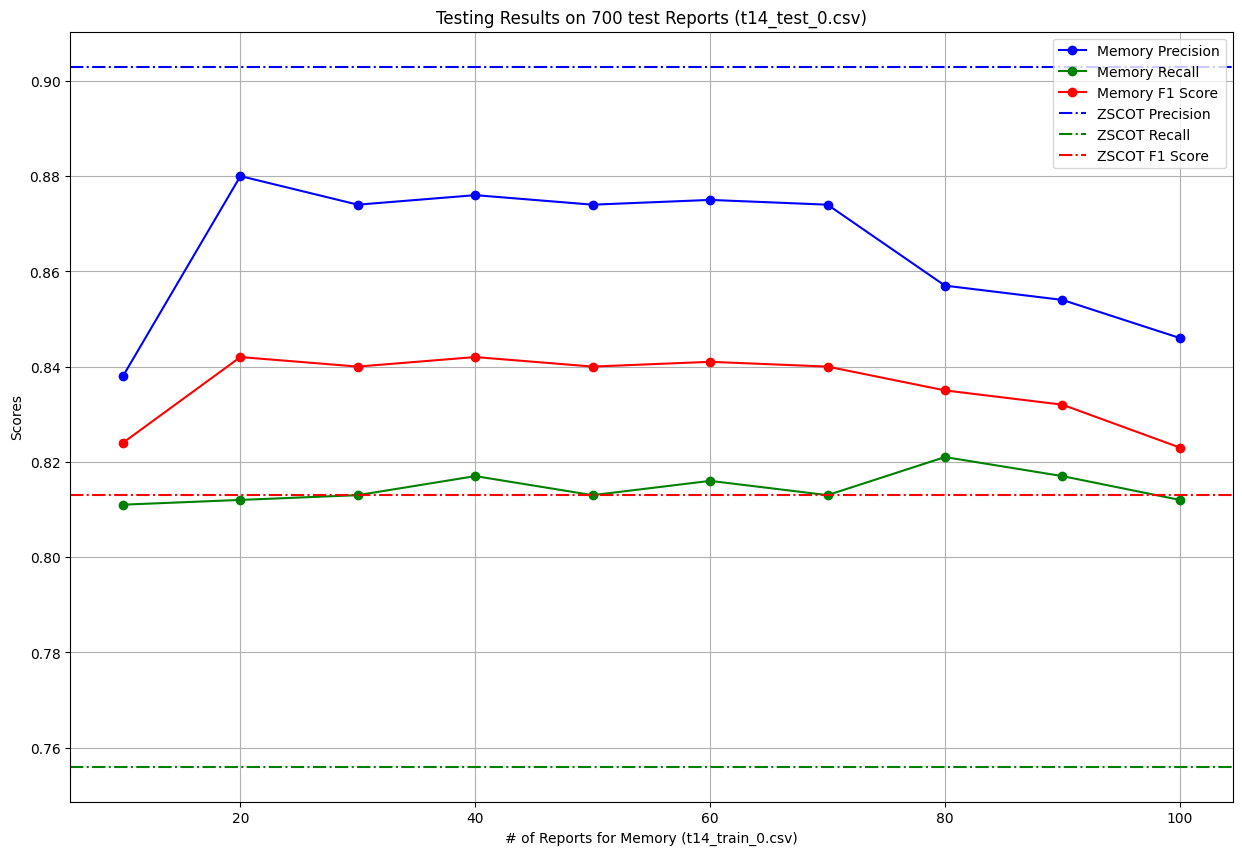

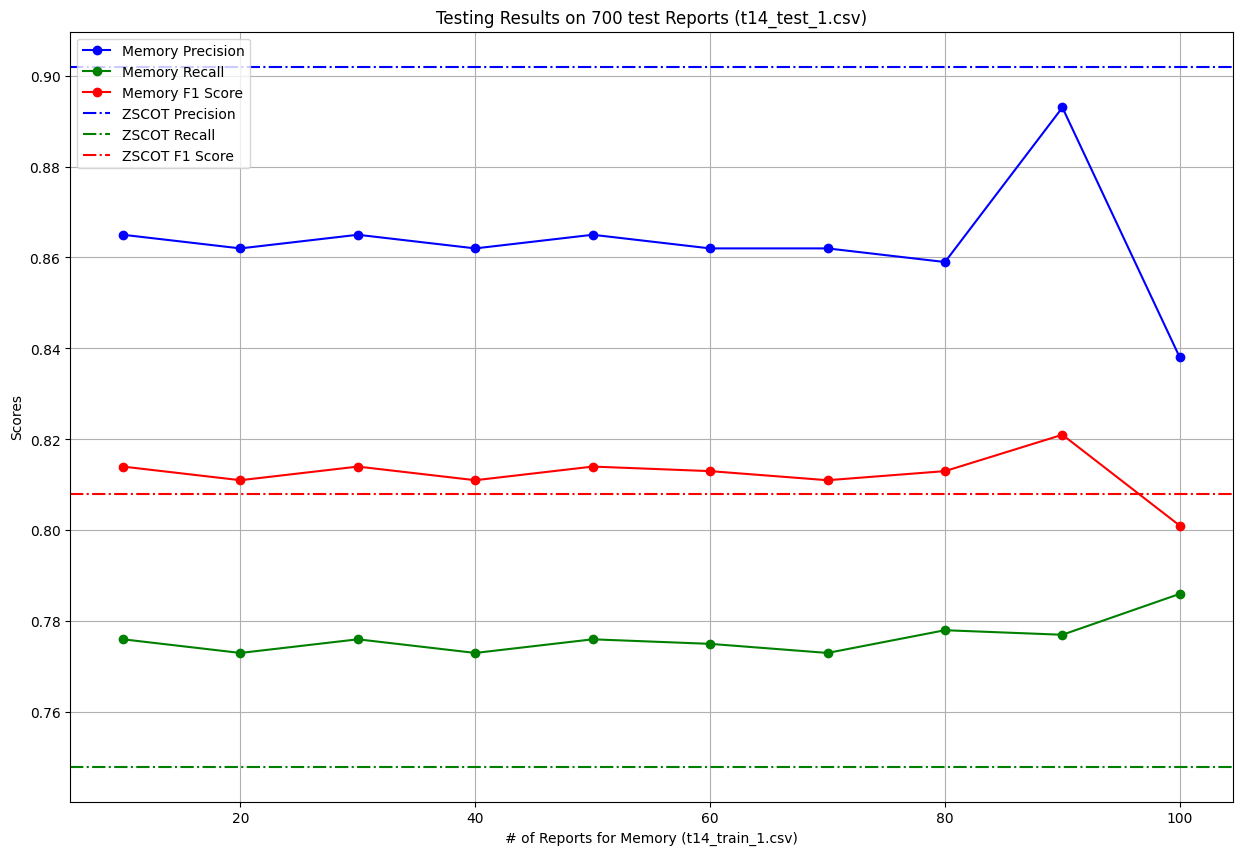

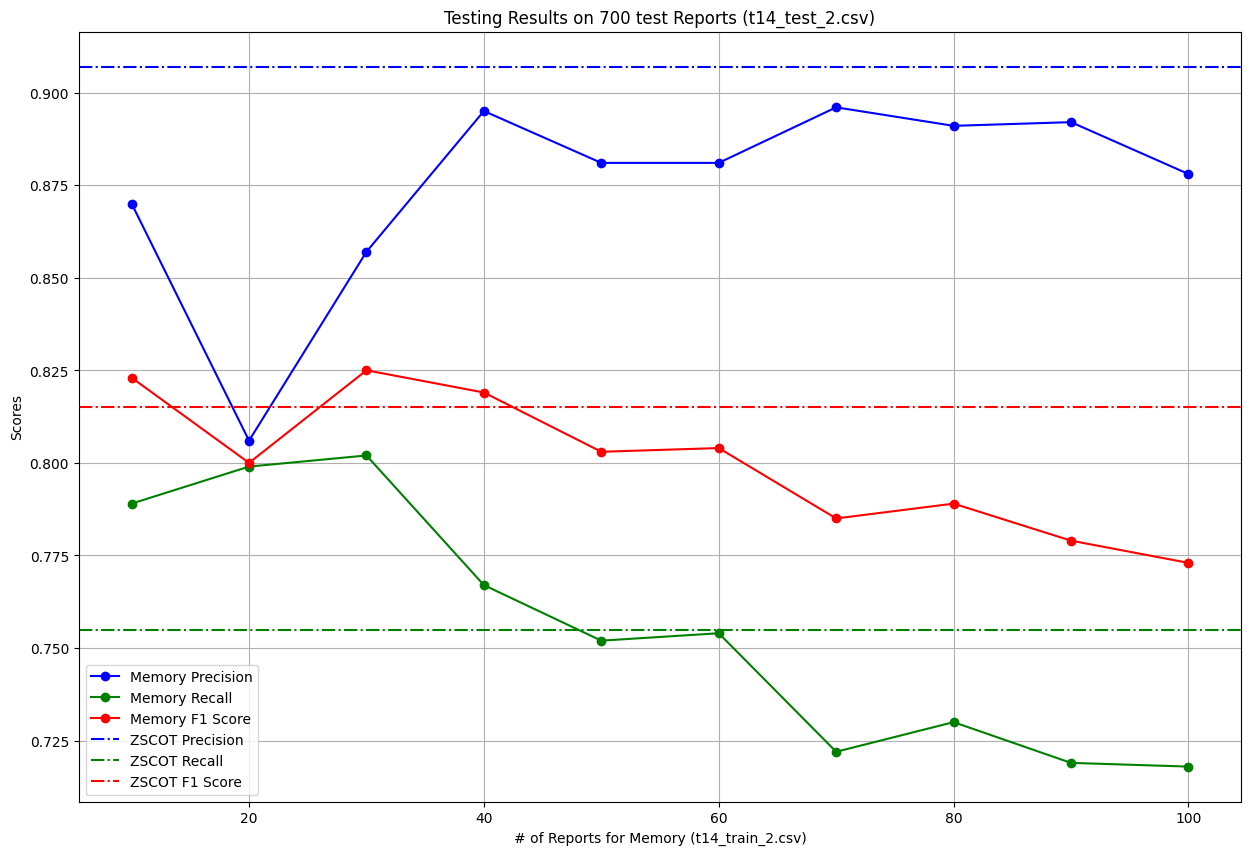

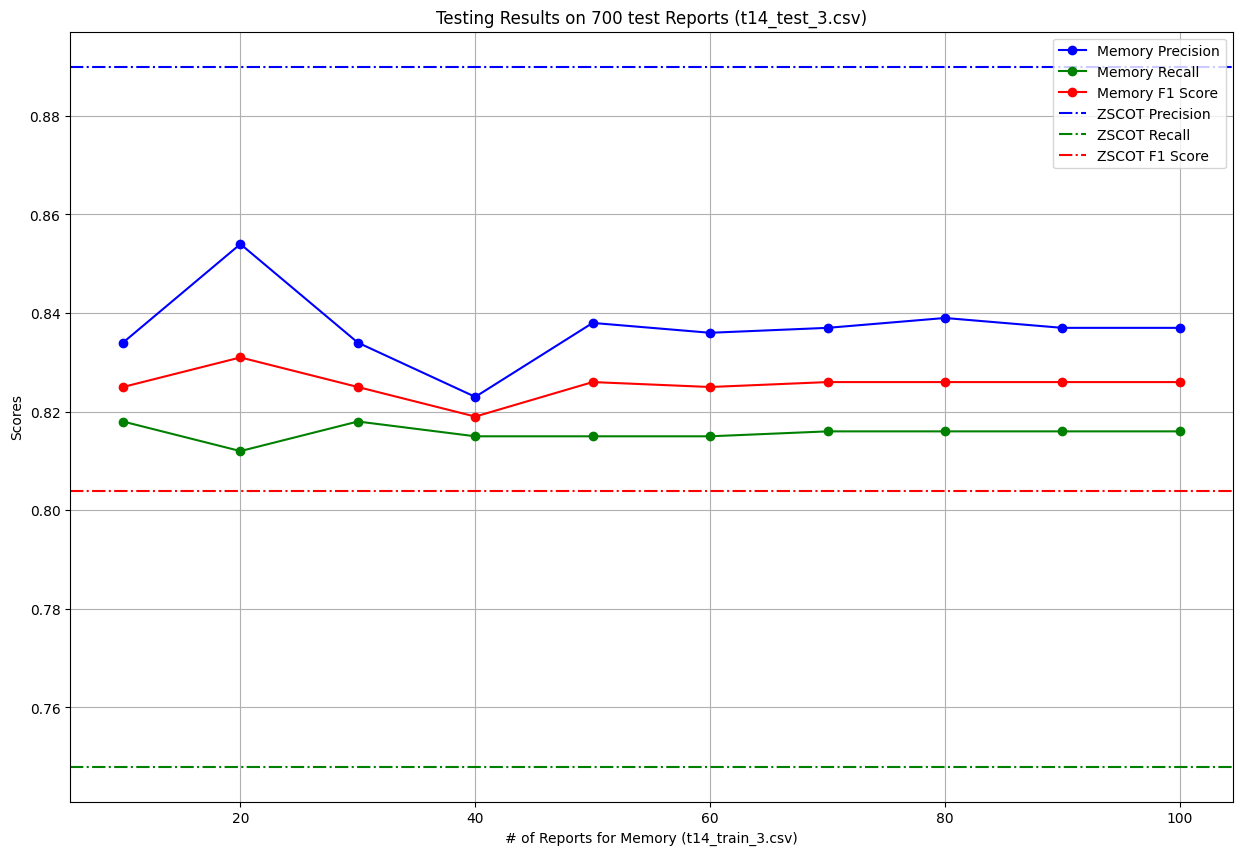

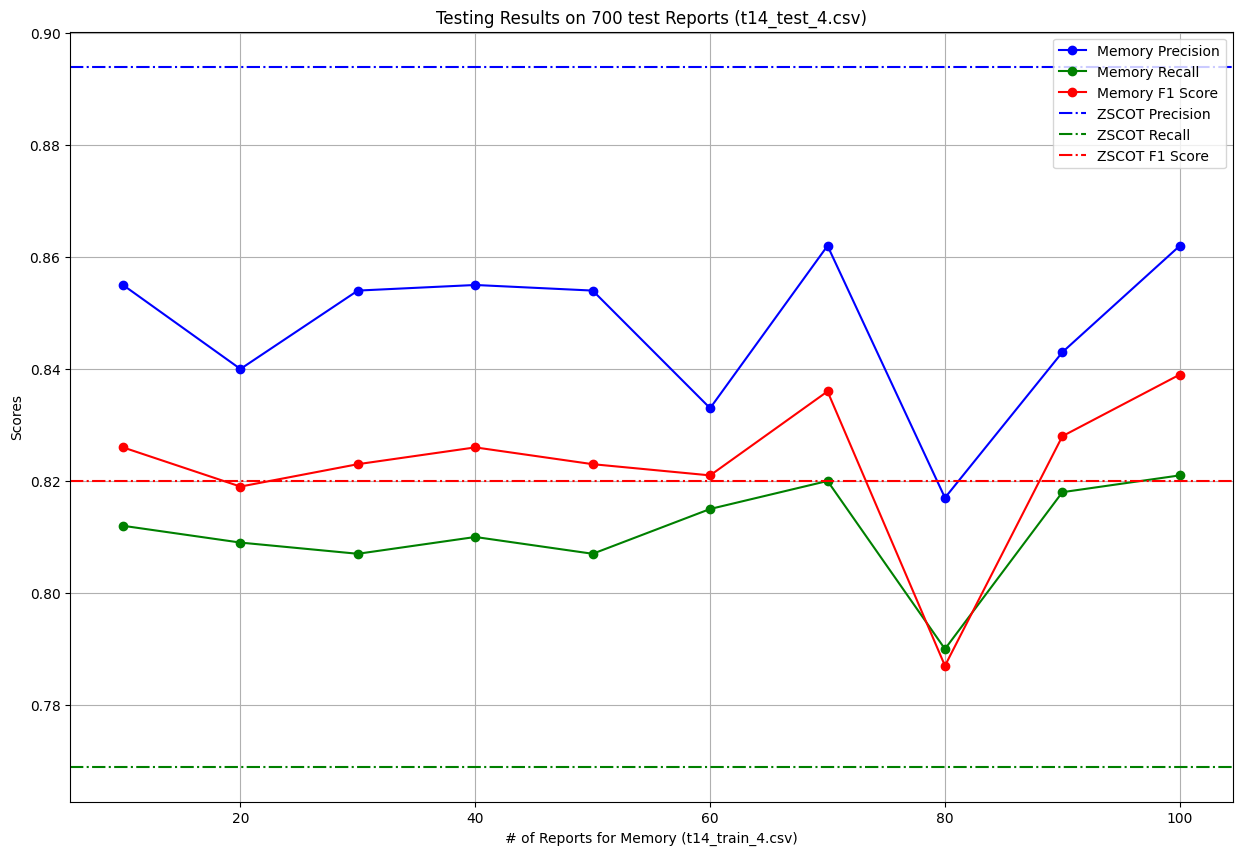

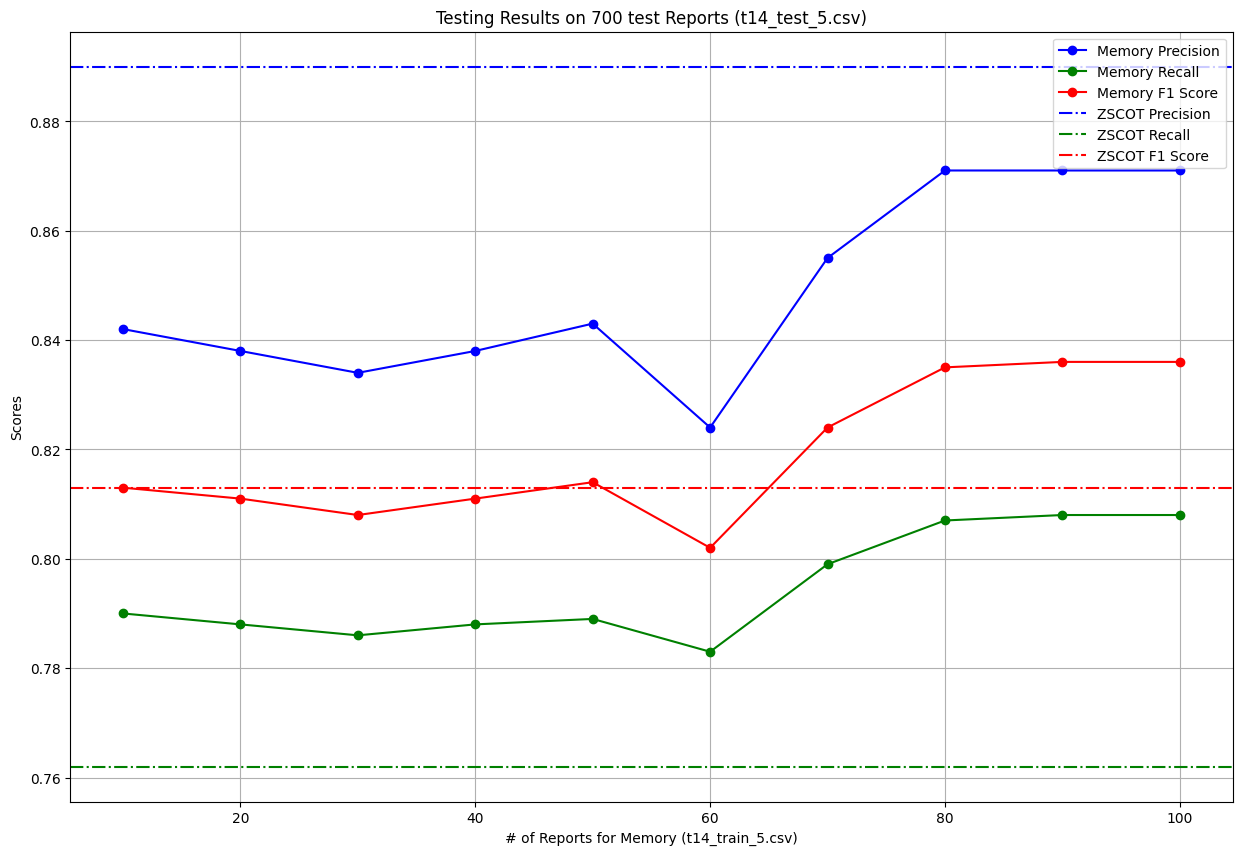

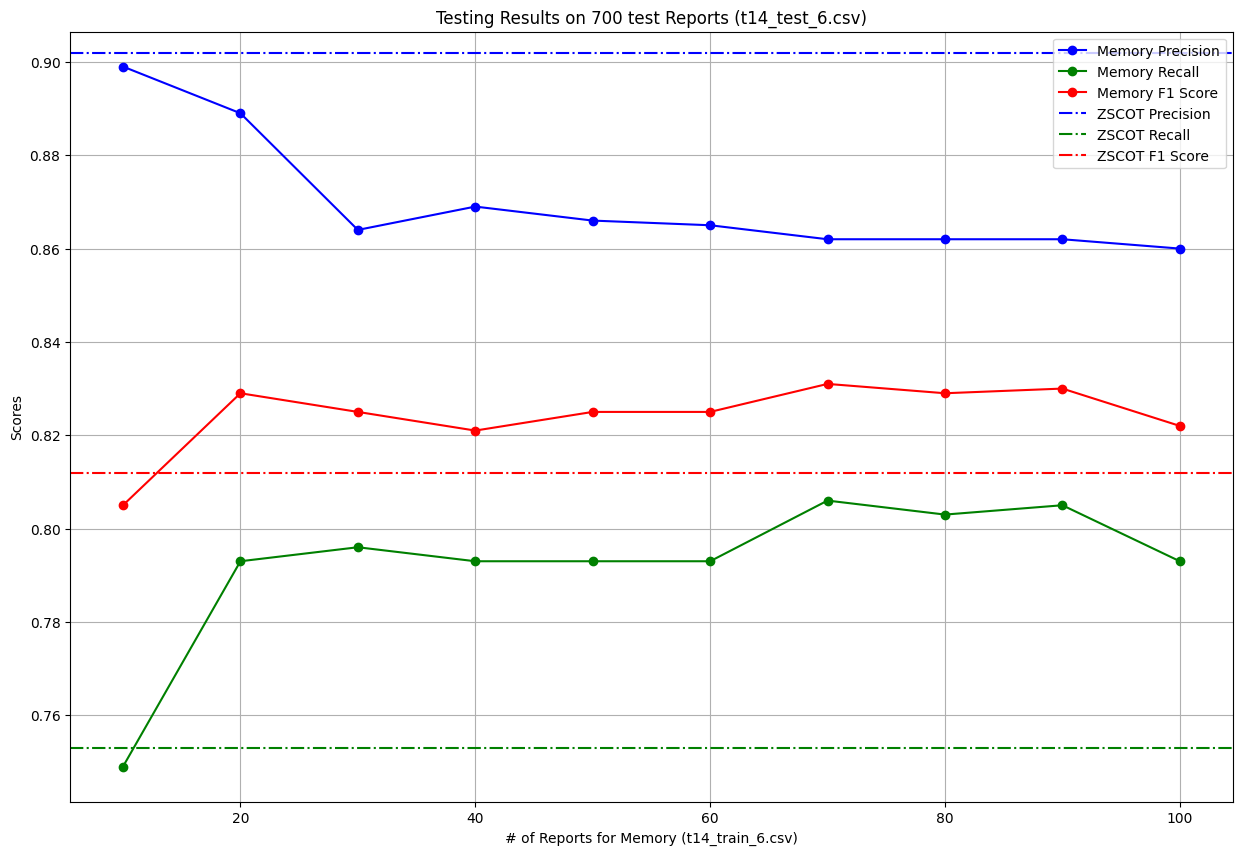

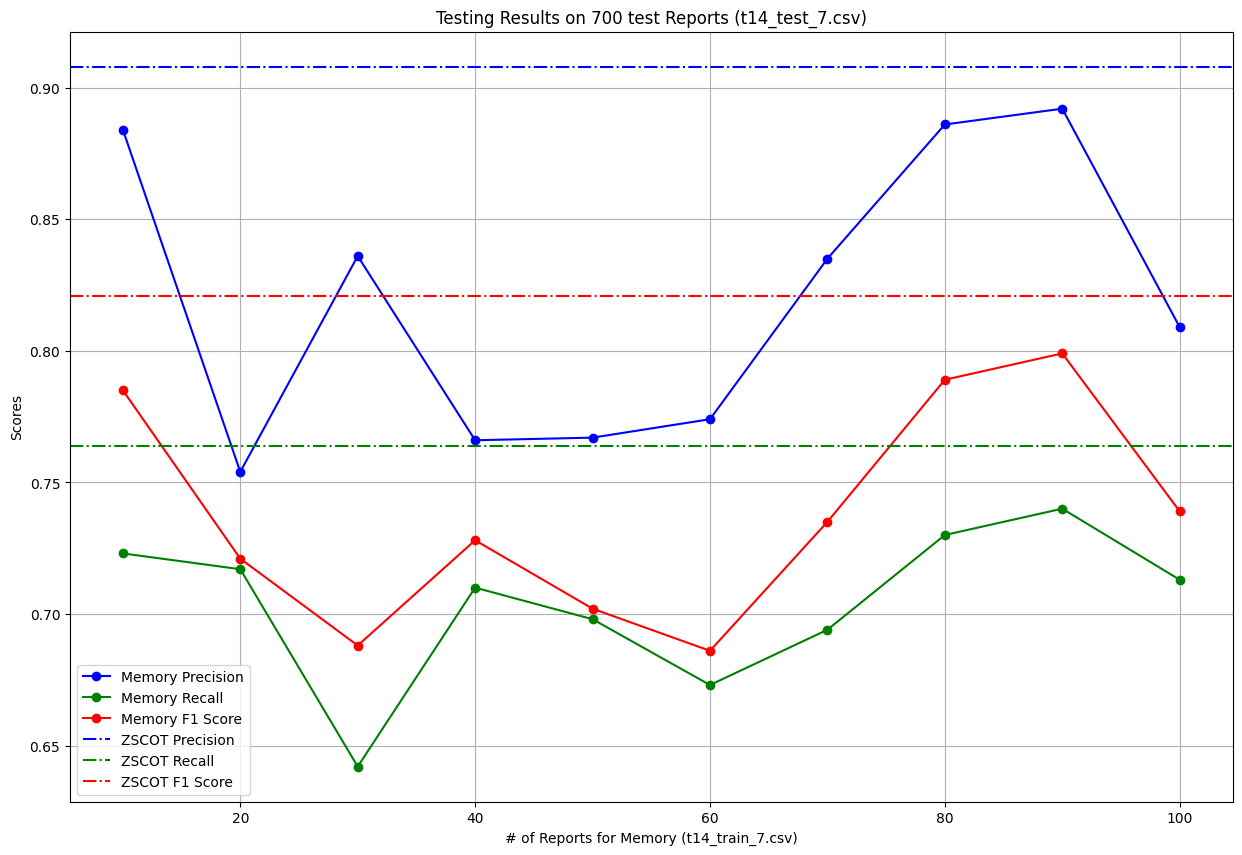

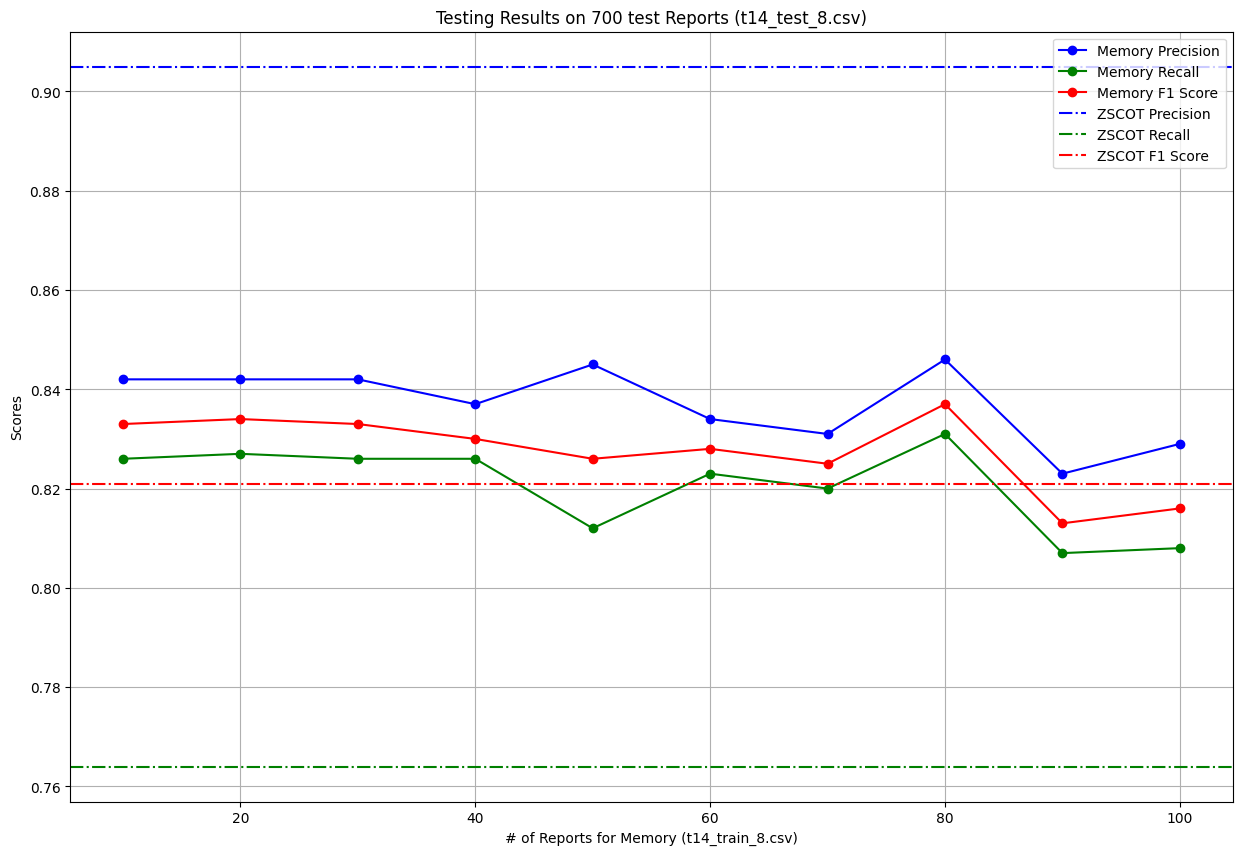

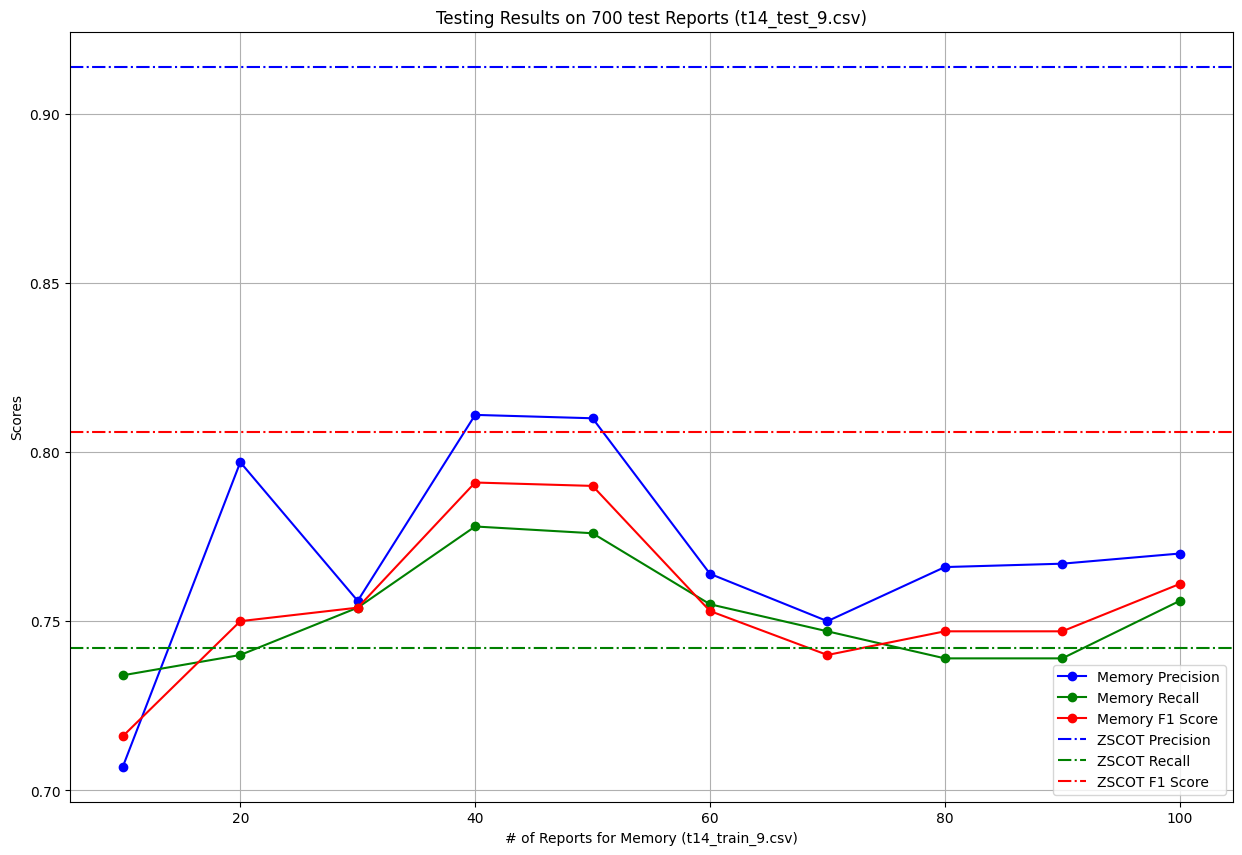

In [5]:
# individual graph

zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")

for run in range(10):
    # t14 training data to extract memory
    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        # if row["cmem_t_is_updated"] == True:
        memory_tup.append((idx+1,row['cmem_t_memory_str']))
    memory_tup = memory_tup[9::10]
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    split_ids = test_df.patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]

    for i, _ in memory_tup:
        if len(test_df[test_df[f"cmem_t_{i}reports_is_parsed"]==False]) > 0:
            print(f"parsing error at memory {i}")


   # gather y-axis data
    precision_lst = []
    recall_lst = []
    f1_lst = []

    zs_precision = t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_precision']
    zs_recall = t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_recall']
    zs_f1 = t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_f1']

    zscot_precision = t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall']['macro_precision']
    zscot_recall = t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall']['macro_recall']
    zscot_f1 = t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall']['macro_f1']

    x_idx = []
    for i, _ in memory_tup:
        x_idx.append(i)
        result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i}reports_ans_str'])['overall']
        precision_lst.append(result['macro_precision'])
        recall_lst.append(result['macro_recall'])
        f1_lst.append(result['macro_f1'])


    plt.figure(figsize=(15, 10))

    plt.plot(x_idx, precision_lst, label='Memory Precision', color='blue', marker='o')
    plt.plot(x_idx, recall_lst, label='Memory Recall', color='green', marker='o')
    plt.plot(x_idx, f1_lst, label='Memory F1 Score', color='red', marker='o')

    # plt.axhline(y=zs_precision, color='blue', linestyle='--', label='ZS Precision')
    # plt.axhline(y=zs_recall, color='green', linestyle='--', label='ZS Recall')
    # plt.axhline(y=zs_f1, color='red', linestyle='--', label='ZS F1 Score')

    plt.axhline(y=zscot_precision, color='blue', linestyle='-.', label='ZSCOT Precision')
    plt.axhline(y=zscot_recall, color='green', linestyle='-.', label='ZSCOT Recall')
    plt.axhline(y=zscot_f1, color='red', linestyle='-.', label='ZSCOT F1 Score')
    
    plt.xlabel(f'# of Reports for Memory (t14_train_{run}.csv)')
    plt.ylabel('Scores')
    plt.title(f'Testing Results on 700 test Reports (t14_test_{run}.csv)')
    plt.legend()
    plt.grid(True)

    plt.show()

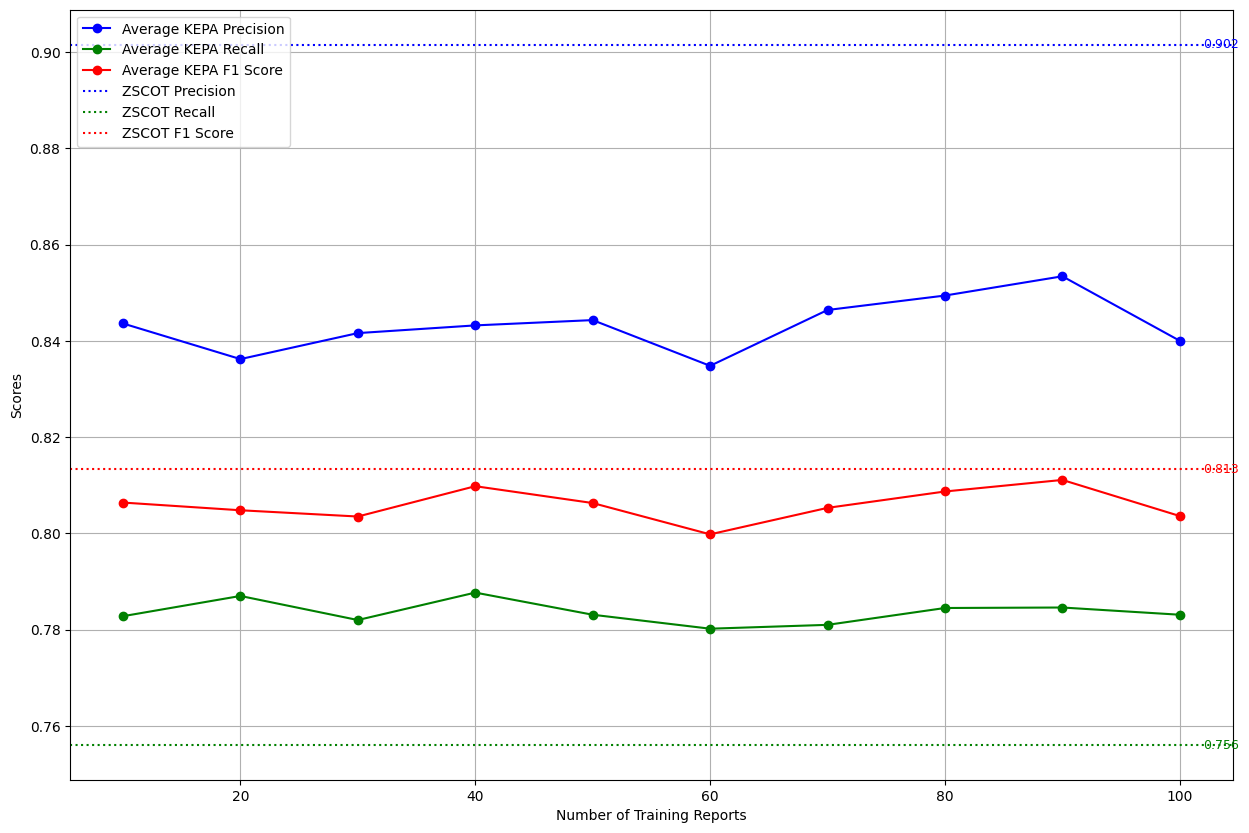

In [20]:
# Average (with new metric)

zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")
ensReas_t = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")

zs_t_results = []
zscot_t_results = []
ensReas_t_results = []

total_run = 10
for run in range(total_run):
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_test_{run}.csv").patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zs_t_results.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall'])

    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]
    zscot_t_results.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall'])
    
    ensReas_t_split = ensReas_t[ensReas_t.patient_filename.isin(split_ids)]
    ensReas_t_results.append(t14_calculate_metrics(ensReas_t_split['t'], ensReas_t_split['sc_ans'])['overall'])
  
zs_precision_avg = sum([rs['macro_precision'] for rs in zs_t_results])/len(zs_t_results)
zs_recall_avg = sum([rs['macro_recall'] for rs in zs_t_results])/len(zs_t_results)
zs_f1_avg = sum([rs['macro_f1'] for rs in zs_t_results])/len(zs_t_results)

zscot_precision_avg = sum([rs['macro_precision'] for rs in zscot_t_results])/len(zscot_t_results)
zscot_recall_avg = sum([rs['macro_recall'] for rs in zscot_t_results])/len(zscot_t_results)
zscot_f1_avg = sum([rs['macro_f1'] for rs in zscot_t_results])/len(zscot_t_results)

ensReas_precision_avg = sum([rs['macro_precision'] for rs in ensReas_t_results])/len(ensReas_t_results)
ensReas_recall_avg = sum([rs['macro_recall'] for rs in ensReas_t_results])/len(ensReas_t_results)
ensReas_f1_avg = sum([rs['macro_f1'] for rs in ensReas_t_results])/len(ensReas_t_results)


x_axis = np.array(range(1, 11)) * 10

memory_precision_cumulative = []
memory_recall_cumulative = []
memory_f1_cumulative = []


for run in range(total_run):
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv")

    for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
        result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i*10}reports_ans_str'])['overall']
        if run == 0:
            memory_precision_cumulative.append(result['macro_precision'])
            memory_recall_cumulative.append(result['macro_recall'])
            memory_f1_cumulative.append(result['macro_f1'])
        else:
            memory_precision_cumulative[i-1] += result['macro_precision']
            memory_recall_cumulative[i-1] += result['macro_recall']
            memory_f1_cumulative[i-1] += result['macro_f1']



# average
precision_avg = [p / total_run for p in memory_precision_cumulative]
recall_avg = [r / total_run for r in memory_recall_cumulative]
f1_avg = [f / total_run for f in memory_f1_cumulative]


plt.figure(figsize=(15, 10))

plt.plot(x_axis, precision_avg, label='Average KEPA Precision', color='blue', marker='o')
plt.plot(x_axis, recall_avg, label='Average KEPA Recall', color='green', marker='o')
plt.plot(x_axis, f1_avg, label='Average KEPA F1 Score', color='red', marker='o')


# plt.axhline(y=zs_precision_avg, color='blue', linestyle='--', label='ZS Precision')
# plt.axhline(y=zs_recall_avg, color='green', linestyle='--', label='ZS Recall')
# plt.axhline(y=zs_f1_avg, color='red', linestyle='--', label='ZS F1 Score')

plt.axhline(y=zscot_precision_avg, color='blue', linestyle=':', label='ZSCOT Precision')
plt.axhline(y=zscot_recall_avg, color='green', linestyle=':', label='ZSCOT Recall')
plt.axhline(y=zscot_f1_avg, color='red', linestyle=':', label='ZSCOT F1 Score')

# plt.axhline(y=ensReas_precision_avg, color='blue', linestyle='-.', label='EnsReas Precision')
# plt.axhline(y=ensReas_recall_avg, color='green', linestyle='-.', label='EnsReas Recall')
# plt.axhline(y=ensReas_f1_avg, color='red', linestyle='-.', label='EnsReas F1 Score')

# plt.text(x_axis[-1] + 2, zs_precision_avg, f'{zs_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
# plt.text(x_axis[-1] + 2, zs_recall_avg, f'{zs_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
# plt.text(x_axis[-1] + 2, zs_f1_avg, f'{zs_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.text(x_axis[-1] + 2, zscot_precision_avg, f'{zscot_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, zscot_recall_avg, f'{zscot_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, zscot_f1_avg, f'{zscot_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

# plt.text(x_axis[-1] + 2, ensReas_precision_avg, f'{ensReas_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
# plt.text(x_axis[-1] + 2, ensReas_recall_avg, f'{ensReas_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
# plt.text(x_axis[-1] + 2, ensReas_f1_avg, f'{ensReas_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.xlabel('Number of Training Reports')
plt.ylabel('Scores')
# plt.title(f'The Average of 10 Results on 700 Test Reports (t14)')
plt.legend()
plt.grid(True)

plt.show()


### N03

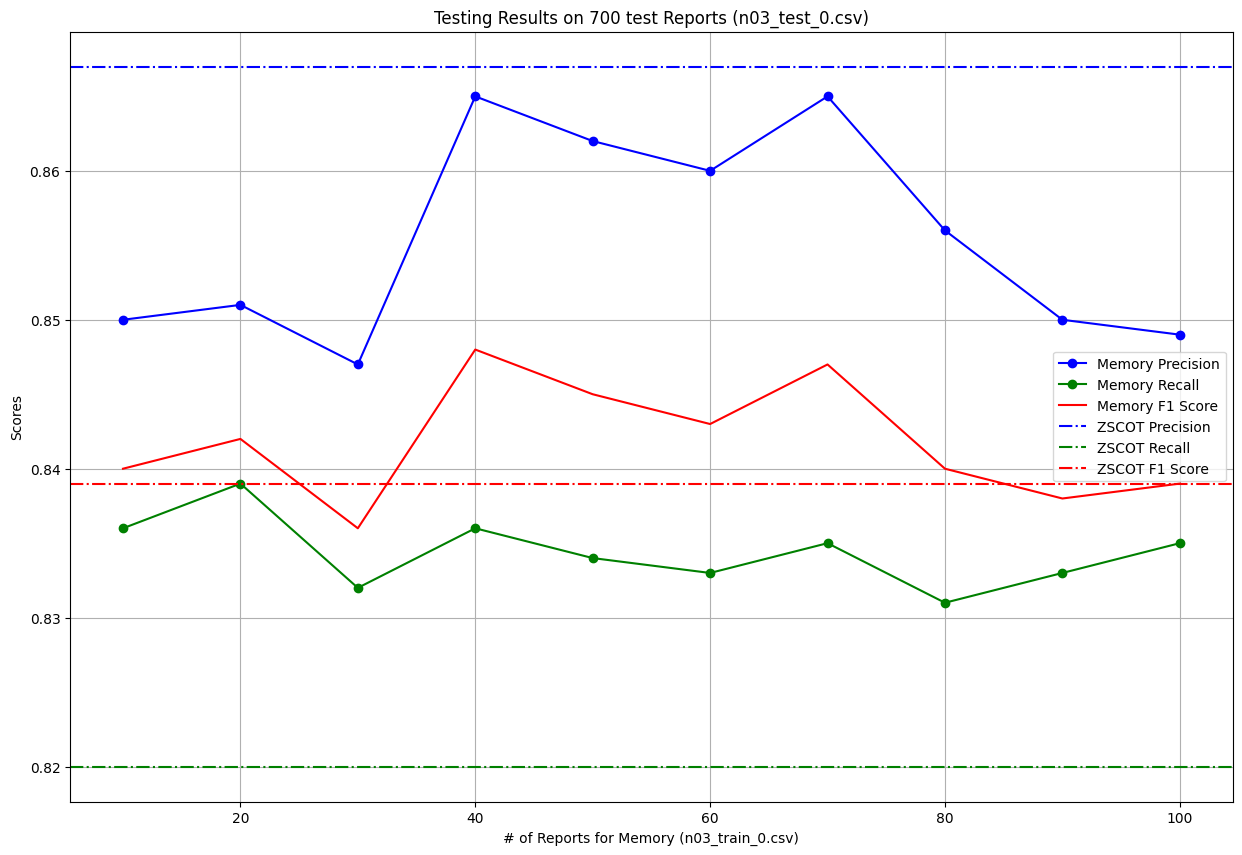

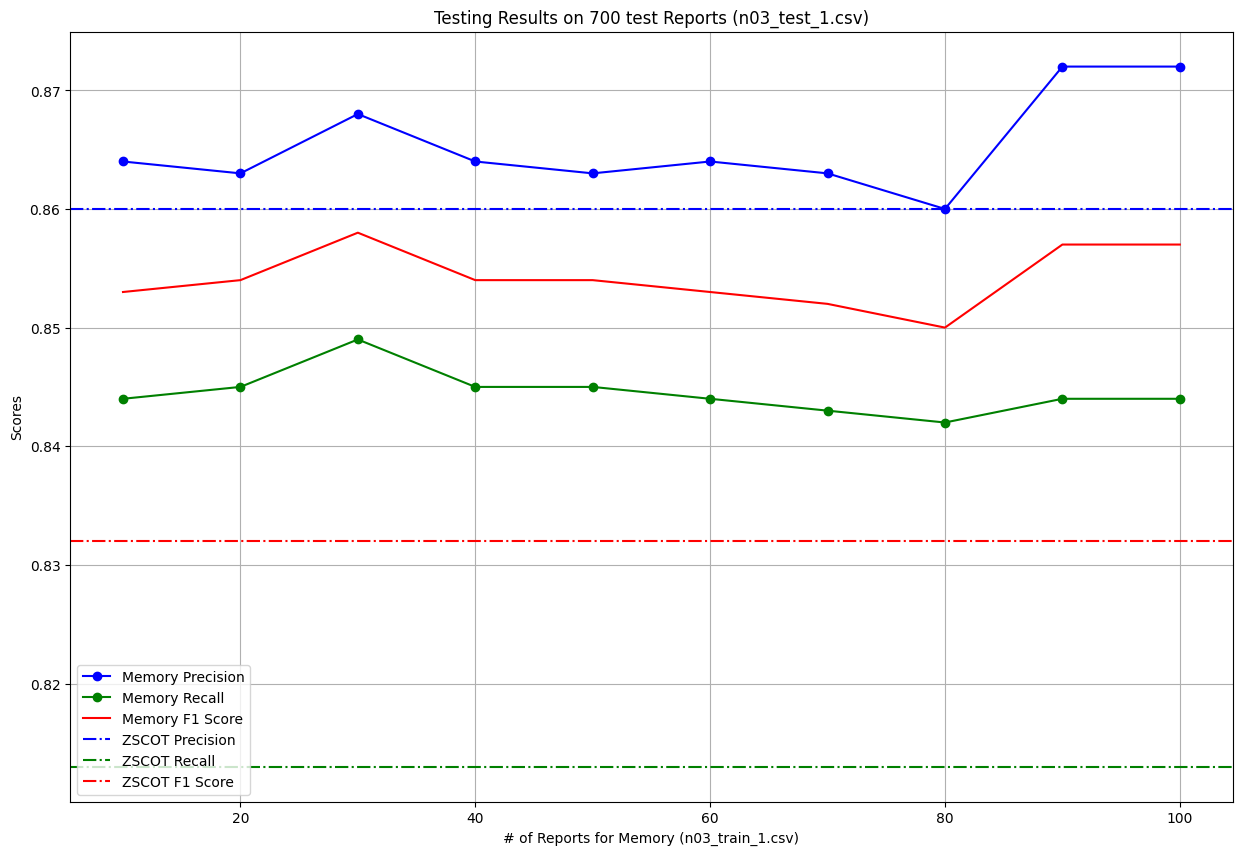

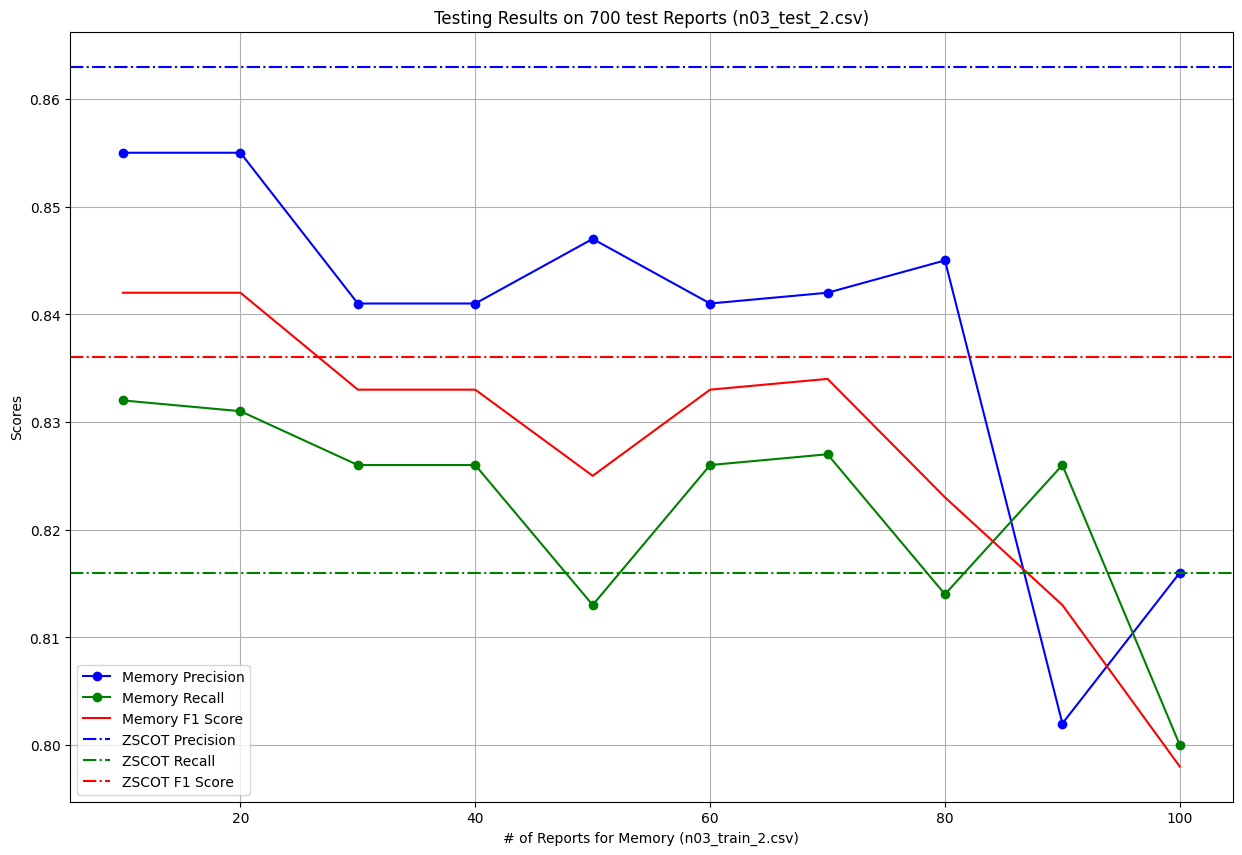

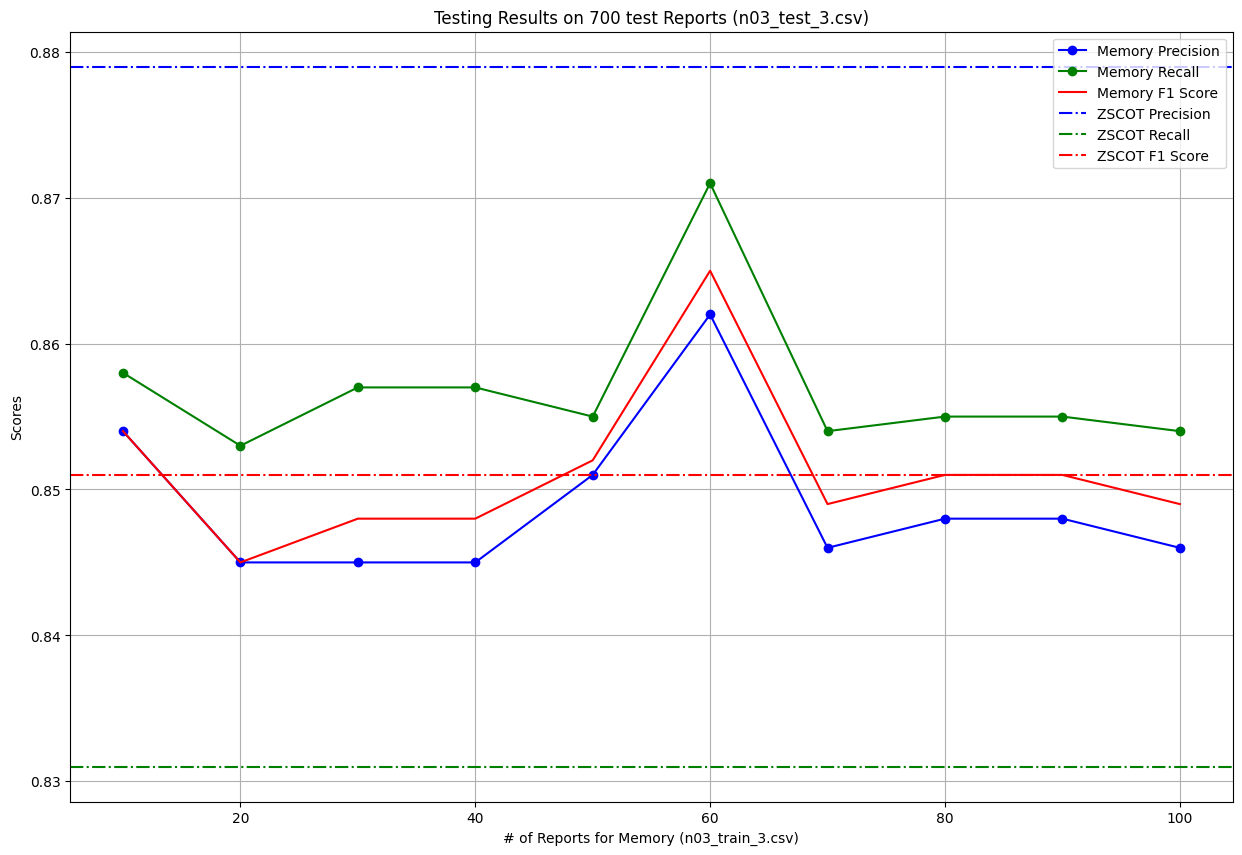

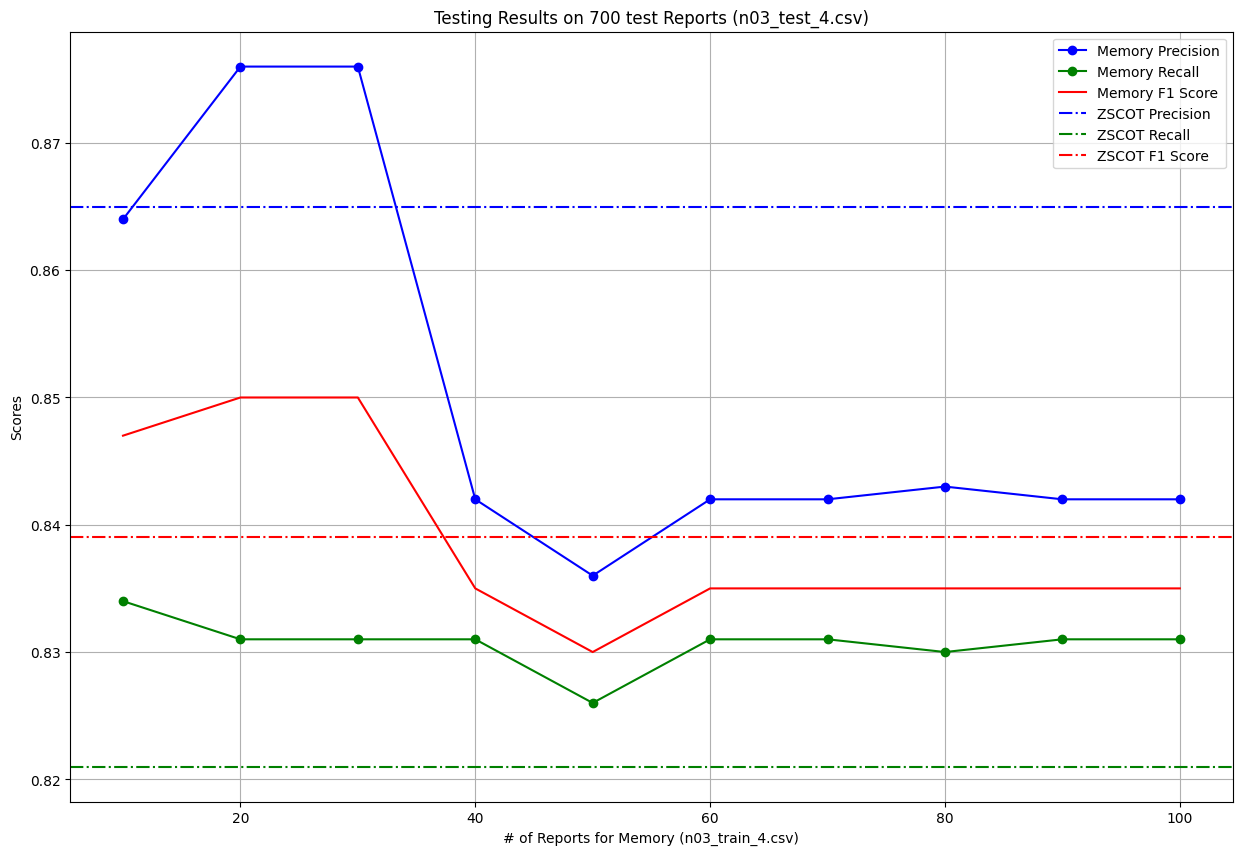

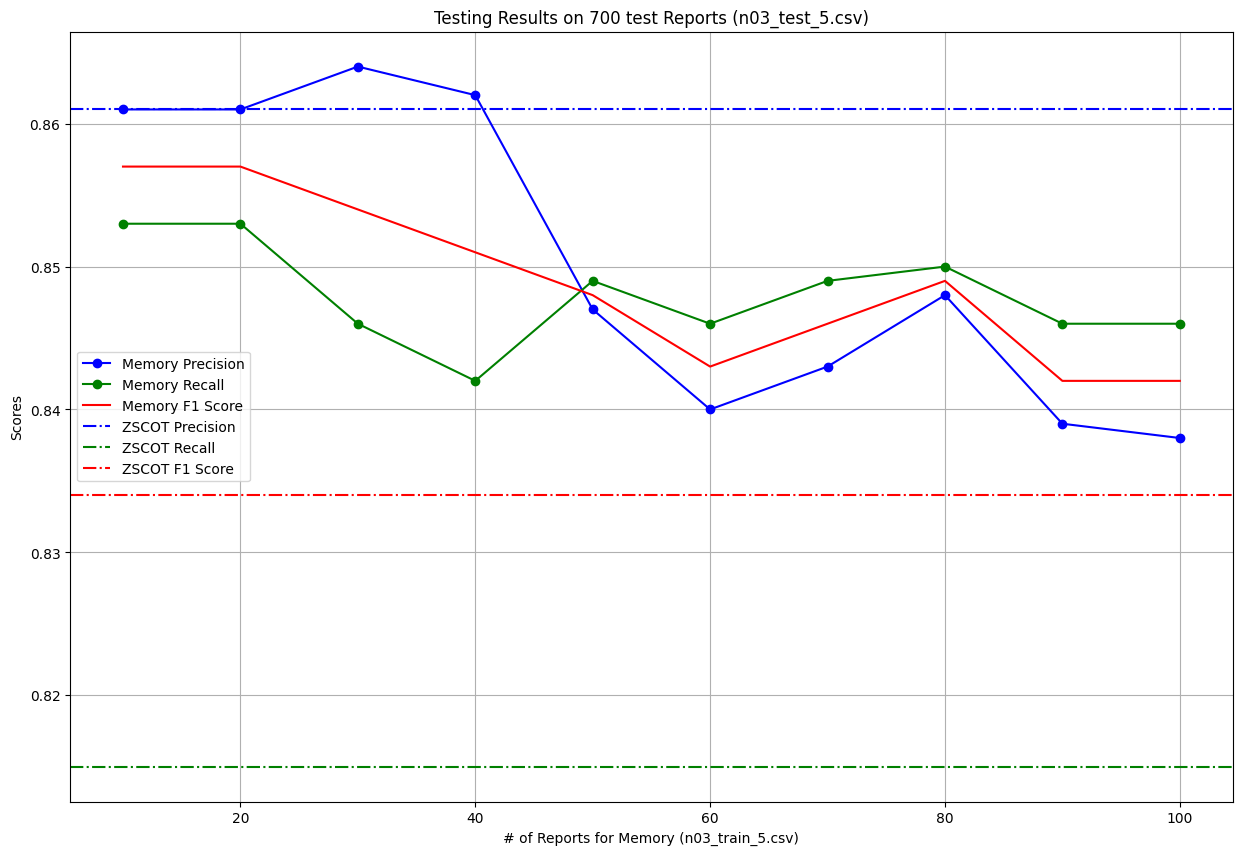

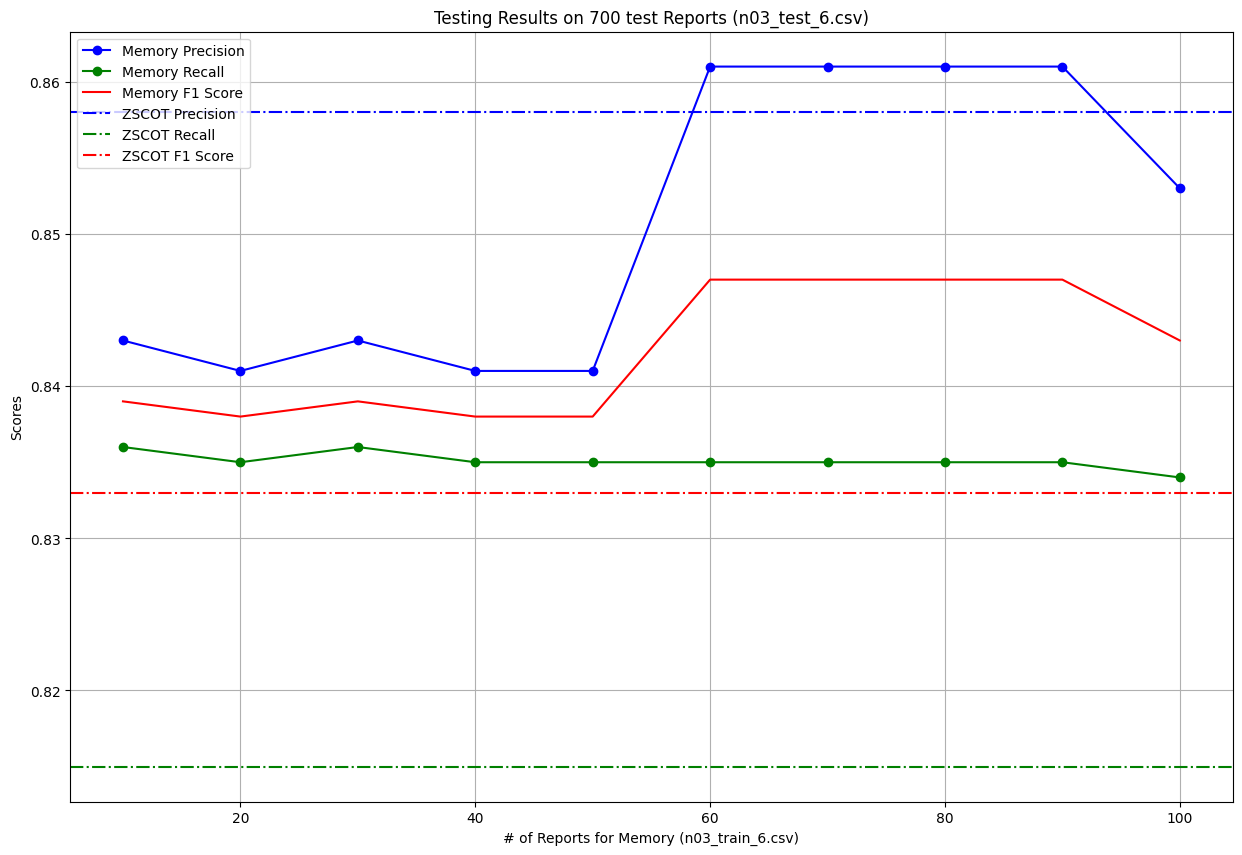

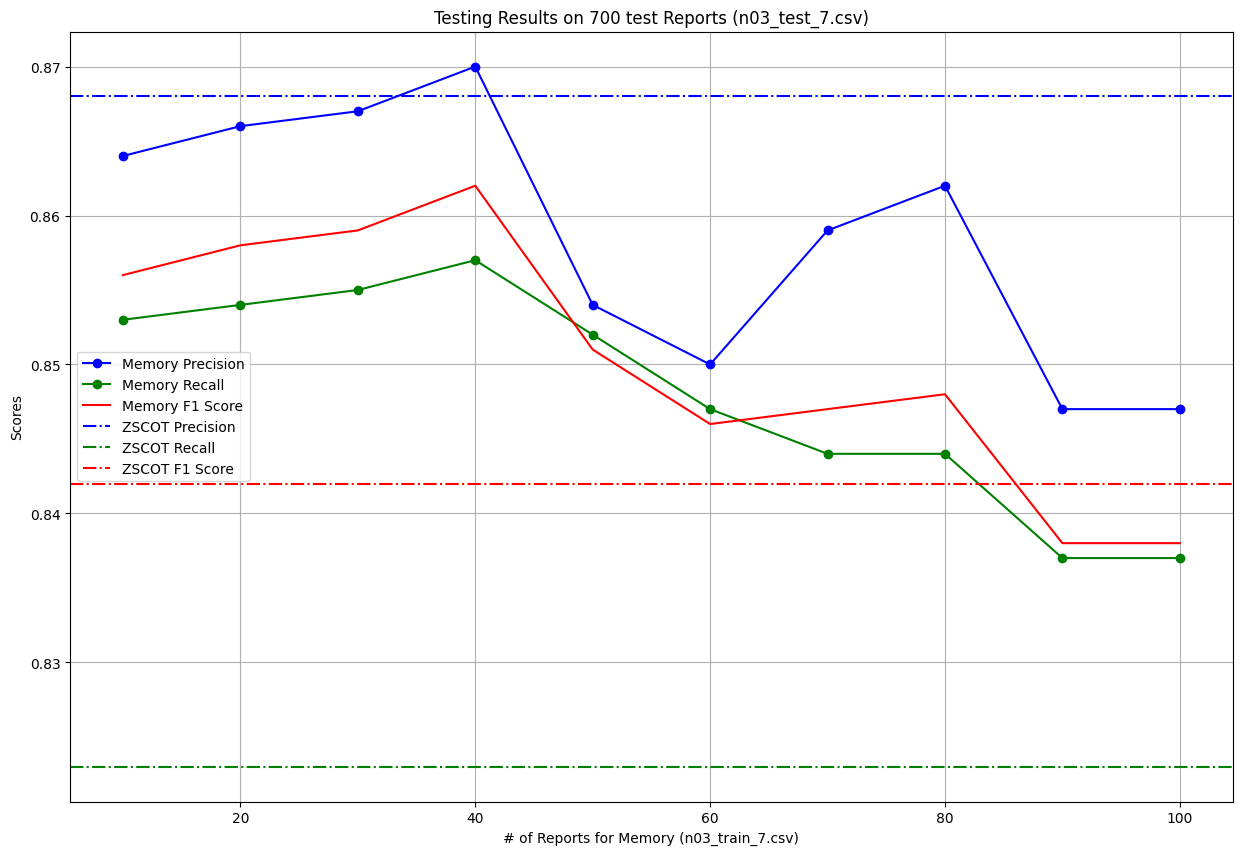

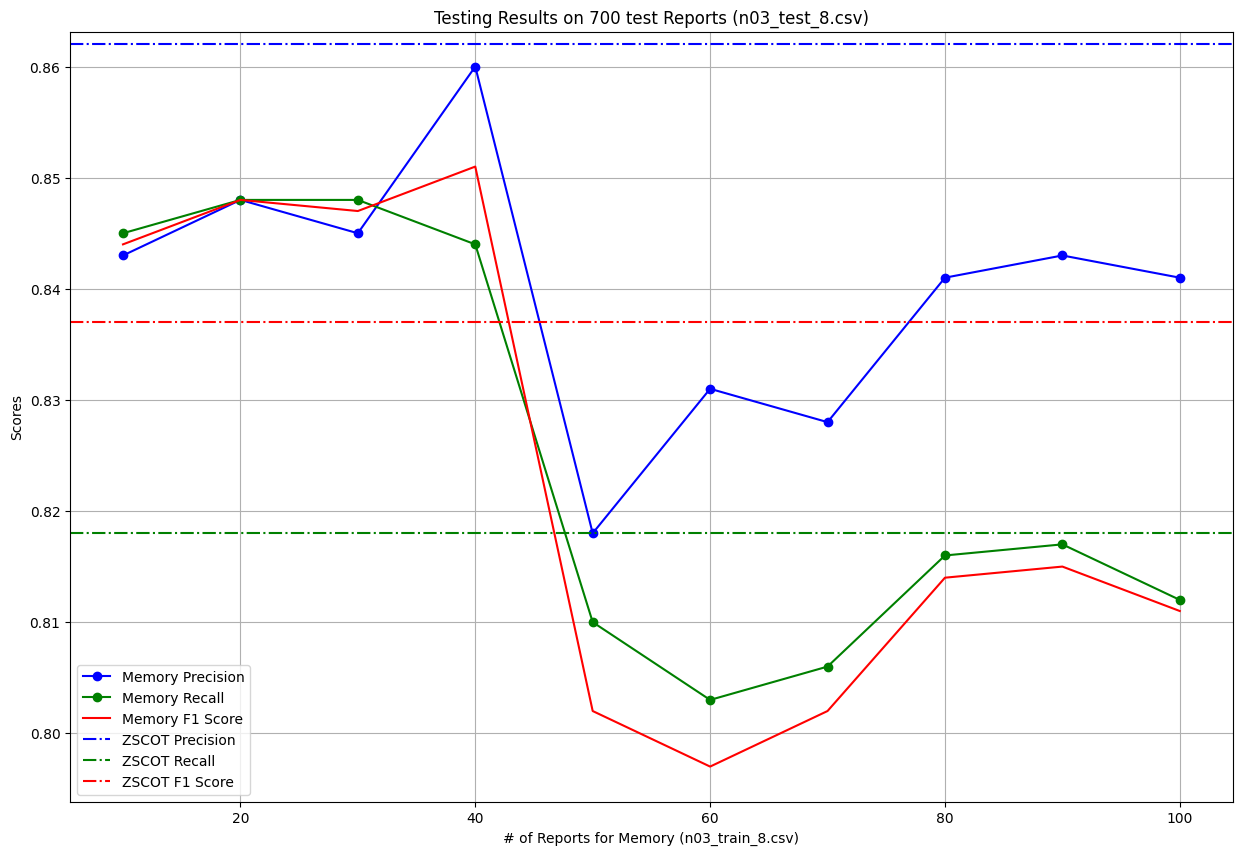

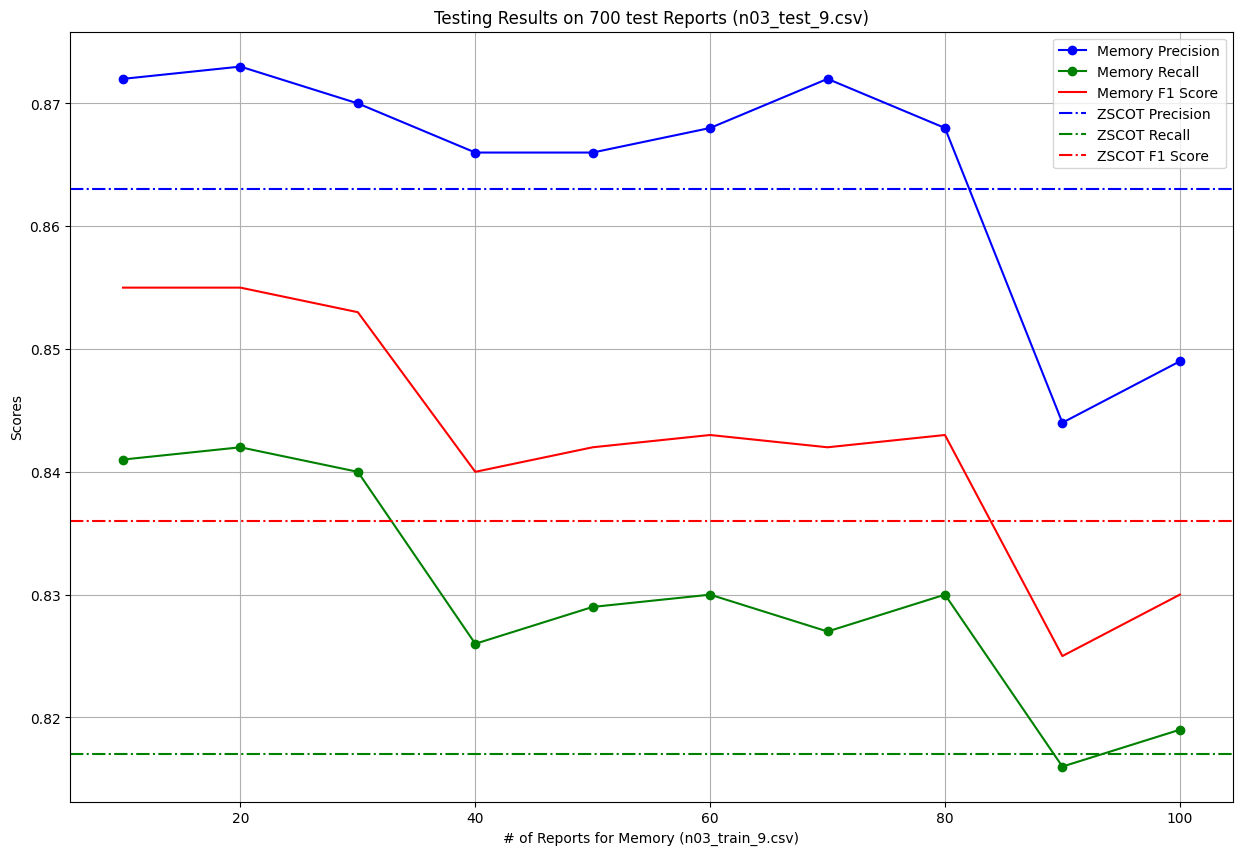

In [21]:
# individual graph

zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")

for run in range(10):
    # n03 training data to extract memory
    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{run}.csv")

    memory_tup = []
    for idx, row in t_train_df.iterrows():
        # if row["cmem_t_is_updated"] == True:
        memory_tup.append((idx+1,row['cmem_n_memory_str']))
    memory_tup = memory_tup[9::10]
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    split_ids = test_df.patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]


    for i, _ in memory_tup:
        if len(test_df[test_df[f"cmem_n_{i}reports_is_parsed"]==False]) > 0:
            print(f"parsing error at memory {i}")


   # gather y-axis data
    precision_lst = []
    recall_lst = []
    f1_lst = []

    zs_precision = n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_precision']
    zs_recall = n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_recall']
    zs_f1 = n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_f1']

    zscot_precision = n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall']['macro_precision']
    zscot_recall = n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall']['macro_recall']
    zscot_f1 = n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall']['macro_f1']

    x_idx = []
    for i, _ in memory_tup:
        x_idx.append(i)
        result = n03_calculate_metrics(test_df['n'], test_df[f'cmem_n_{i}reports_ans_str'])['overall']
        precision_lst.append(result['macro_precision'])
        recall_lst.append(result['macro_recall'])
        f1_lst.append(result['macro_f1'])


    plt.figure(figsize=(15, 10))

    plt.plot(x_idx, precision_lst, label='Memory Precision', color='blue', marker='o')
    plt.plot(x_idx, recall_lst, label='Memory Recall', color='green', marker='o')
    plt.plot(x_idx, f1_lst, label='Memory F1 Score', color='red')
    
    # plt.axhline(y=zs_precision, color='blue', linestyle='--', label='ZS Precision')
    # plt.axhline(y=zs_recall, color='green', linestyle='--', label='ZS Recall')
    # plt.axhline(y=zs_f1, color='red', linestyle='--', label='ZS F1 Score')

    plt.axhline(y=zscot_precision, color='blue', linestyle='-.', label='ZSCOT Precision')
    plt.axhline(y=zscot_recall, color='green', linestyle='-.', label='ZSCOT Recall')
    plt.axhline(y=zscot_f1, color='red', linestyle='-.', label='ZSCOT F1 Score')
    
    plt.xlabel(f'# of Reports for Memory (n03_train_{run}.csv)')
    plt.ylabel('Scores')
    plt.title(f'Testing Results on 700 test Reports (n03_test_{run}.csv)')
    plt.legend()
    plt.grid(True)

    plt.show()

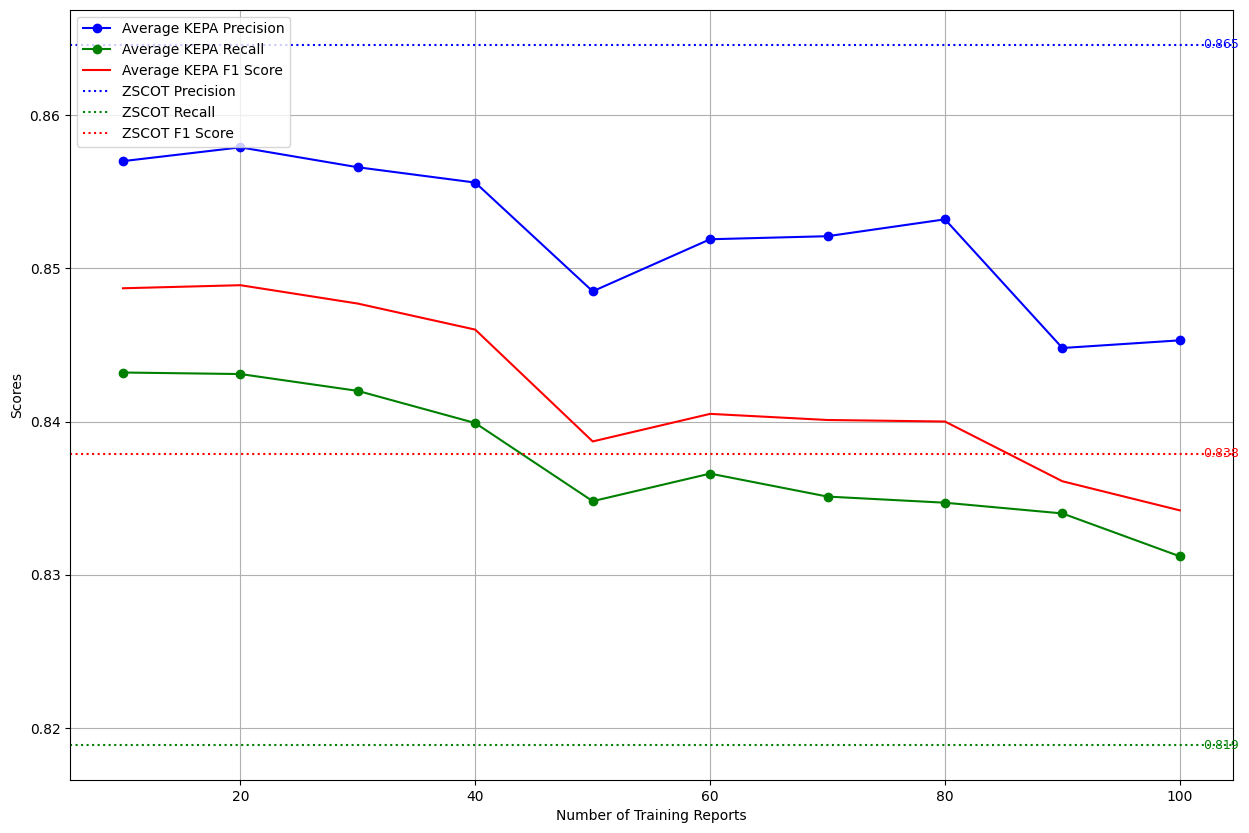

In [23]:
# Average (with new metric)

zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")
ensReas_n = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")

zs_n_results = []
zscot_n_results = []
ensReas_n_results = []

total_run = 10
for run in range(total_run):
    # if run == 8:
    #     continue
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_test_{run}.csv").patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zs_n_results.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall'])

    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]
    zscot_n_results.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall'])

    ensReas_n_split = ensReas_n[ensReas_n.patient_filename.isin(split_ids)]
    ensReas_n_results.append(n03_calculate_metrics(ensReas_n_split['n'], ensReas_n_split['sc_ans'])['overall'])

zs_precision_avg = sum([rs['macro_precision'] for rs in zs_n_results])/len(zs_n_results)
zs_recall_avg = sum([rs['macro_recall'] for rs in zs_n_results])/len(zs_n_results)
zs_f1_avg = sum([rs['macro_f1'] for rs in zs_n_results])/len(zs_n_results)

zscot_precision_avg = sum([rs['macro_precision'] for rs in zscot_n_results])/len(zscot_n_results)
zscot_recall_avg = sum([rs['macro_recall'] for rs in zscot_n_results])/len(zscot_n_results)
zscot_f1_avg = sum([rs['macro_f1'] for rs in zscot_n_results])/len(zscot_n_results)

ensReas_precision_avg = sum([rs['macro_precision'] for rs in ensReas_n_results])/len(ensReas_n_results)
ensReas_recall_avg = sum([rs['macro_recall'] for rs in ensReas_n_results])/len(ensReas_n_results)
ensReas_f1_avg = sum([rs['macro_f1'] for rs in ensReas_n_results])/len(ensReas_n_results)


x_axis = np.array(range(1, 11)) * 10

memory_precision_cumulative = []
memory_recall_cumulative = []
memory_f1_cumulative = []
devided_by = 0
for run in range(total_run):
    # if run == 8:
    #     continue
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv")

    for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
        result = n03_calculate_metrics(test_df['n'], test_df[f'cmem_n_{i*10}reports_ans_str'])['overall']
        if run == 0:
            memory_precision_cumulative.append(result['macro_precision'])
            memory_recall_cumulative.append(result['macro_recall'])
            memory_f1_cumulative.append(result['macro_f1'])
        else:
            memory_precision_cumulative[i-1] += result['macro_precision']
            memory_recall_cumulative[i-1] += result['macro_recall']
            memory_f1_cumulative[i-1] += result['macro_f1']
    devided_by += 1


# average
precision_avg = [p / devided_by for p in memory_precision_cumulative]
recall_avg = [r / devided_by for r in memory_recall_cumulative]
f1_avg = [f / devided_by for f in memory_f1_cumulative]


plt.figure(figsize=(15, 10))

plt.plot(x_axis, precision_avg, label='Average KEPA Precision', color='blue', marker='o')
plt.plot(x_axis, recall_avg, label='Average KEPA Recall', color='green', marker='o')
plt.plot(x_axis, f1_avg, label='Average KEPA F1 Score', color='red')


# plt.axhline(y=zs_precision_avg, color='blue', linestyle='--', label='ZS Precision')
# plt.axhline(y=zs_recall_avg, color='green', linestyle='--', label='ZS Recall')
# plt.axhline(y=zs_f1_avg, color='red', linestyle='--', label='ZS F1 Score')

plt.axhline(y=zscot_precision_avg, color='blue', linestyle=':', label='ZSCOT Precision')
plt.axhline(y=zscot_recall_avg, color='green', linestyle=':', label='ZSCOT Recall')
plt.axhline(y=zscot_f1_avg, color='red', linestyle=':', label='ZSCOT F1 Score')

# plt.axhline(y=ensReas_precision_avg, color='blue', linestyle='-.', label='EnsReas Precision')
# plt.axhline(y=ensReas_recall_avg, color='green', linestyle='-.', label='EnsReas Recall')
# plt.axhline(y=ensReas_f1_avg, color='red', linestyle='-.', label='EnsReas F1 Score')

# plt.text(x_axis[-1] + 2, zs_precision_avg, f'{zs_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
# plt.text(x_axis[-1] + 2, zs_recall_avg, f'{zs_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
# plt.text(x_axis[-1] + 2, zs_f1_avg, f'{zs_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.text(x_axis[-1] + 2, zscot_precision_avg, f'{zscot_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, zscot_recall_avg, f'{zscot_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, zscot_f1_avg, f'{zscot_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

# plt.text(x_axis[-1] + 2, ensReas_precision_avg, f'{ensReas_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
# plt.text(x_axis[-1] + 2, ensReas_recall_avg, f'{ensReas_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
# plt.text(x_axis[-1] + 2, ensReas_f1_avg, f'{ensReas_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.xlabel('Number of Training Reports')
plt.ylabel('Scores')
# plt.title(f'The Average of 10 Results on 700 Test Reports (n03)')
plt.legend()
plt.grid(True)

plt.show()

# Re-run for Error cases

In [ ]:
client = OpenAI(api_key = "empty",
                base_url = "http://localhost:8000/v1")
    
class TestingResponse(BaseModel):
    predictedStage: str = Field(description="predicted cancer stage")
    reasoning: str = Field(description="reasoning to support predicted cancer stage") 

testing_schema = TestingResponse.model_json_schema()

def test_individual_report(dataset: pd.DataFrame, patient_filename: str, memory_tup: tuple, category = 'n'):
    num, memory = memory_tup
    report = dataset[dataset.patient_filename == patient_filename]["text"].values[0]

    if category.lower()[0] == 'n':
        prompt = testing_predict_prompt_n03.format(memory=memory, report=report)
    else:
        prompt = testing_predict_prompt_t14.format(memory=memory, report=report)
    
    prompt = system_instruction + "\n" + prompt
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model = "mistralai/Mixtral-8x7B-Instruct-v0.1",
        messages = messages,
        extra_body = {"guided_json": testing_schema},
        temperature = 0.1)
    # response = json.loads(response.choices[0].message.content.replace("\\", "\\\\"))
    response = json.loads(response.choices[0].message.content)

    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_{num}reports_is_parsed"] = True
    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_{num}reports_ans_str"] = response["predictedStage"]
    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_{num}reports_reasoning"] = response["reasoning"]

    return dataset

In [ ]:
# T14
for run in range(10):
    print(f"{run}th split")

    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        memory_tup.append((idx+1,row['cmem_t_memory_str']))
    memory_tup = memory_tup[9::10]

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    for num, memory in memory_tup:
        print(f"{num}th memory")
        for idx in range(len(test_df)):     
            patient_filename = test_df.loc[idx, "patient_filename"]
            if not isinstance(test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_{num}reports_ans_str"].values.item(), str):
                print(idx) 
                print("before: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_{num}reports_ans_str"].values.item())
                test_individual_report(test_df, patient_filename, (num, memory), 't')
                print("after: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_{num}reports_ans_str"].values.item())
                print("label: ", test_df.loc[test_df["patient_filename"] == patient_filename, "t"].values.item())
    
    test_df.to_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv", index=False)

In [ ]:
# N03
for run in range(10):
    print(f"{run}th split")

    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        memory_tup.append((idx+1,row['cmem_n_memory_str']))
    memory_tup = memory_tup[9::10]

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    for num, memory in memory_tup:
        print(f"{num}th memory")
        for idx in range(len(test_df)):     
            patient_filename = test_df.loc[idx, "patient_filename"]
            if not isinstance(test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_{num}reports_ans_str"].values.item(), str):
                print(idx) 
                print("before: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_{num}reports_ans_str"].values.item())
                test_individual_report(test_df, patient_filename, (num, memory), 'n')
                print("after: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_{num}reports_ans_str"].values.item())
                print("label: ", test_df.loc[test_df["patient_filename"] == patient_filename, "n"].values.item())
    
    test_df.to_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv", index=False)

# Check the Difference in Performance Based on the Order of Fields in the Schema

In [ ]:
# run = 6

# test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv")
# for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
#     result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i*10}reports_ans_str'])['overall']
#     print(result)


# test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs_revised.csv")
# for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
#     if len(test_df[test_df[f"cmem_t_{i*10}reports_is_parsed"]==False]) > 0:
#         print(len(test_df[test_df[f"cmem_t_{i*10}reports_is_parsed"]==False]))
#     print(t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i*10}reports_ans_str'])['overall'])

In [ ]:
# n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_5_outof_10runs_reordered.csv")
# for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
#     result = n03_calculate_metrics(n_df['n'], n_df[f'cmem_n_{i*10}reports_ans_str'])['overall']
#     print(result)

# n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_5_outof_10runs.csv")
# for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
#     result = n03_calculate_metrics(n_df['n'], n_df[f'cmem_n_{i*10}reports_ans_str'])['overall']
#     print(result)

# Plot Memory length

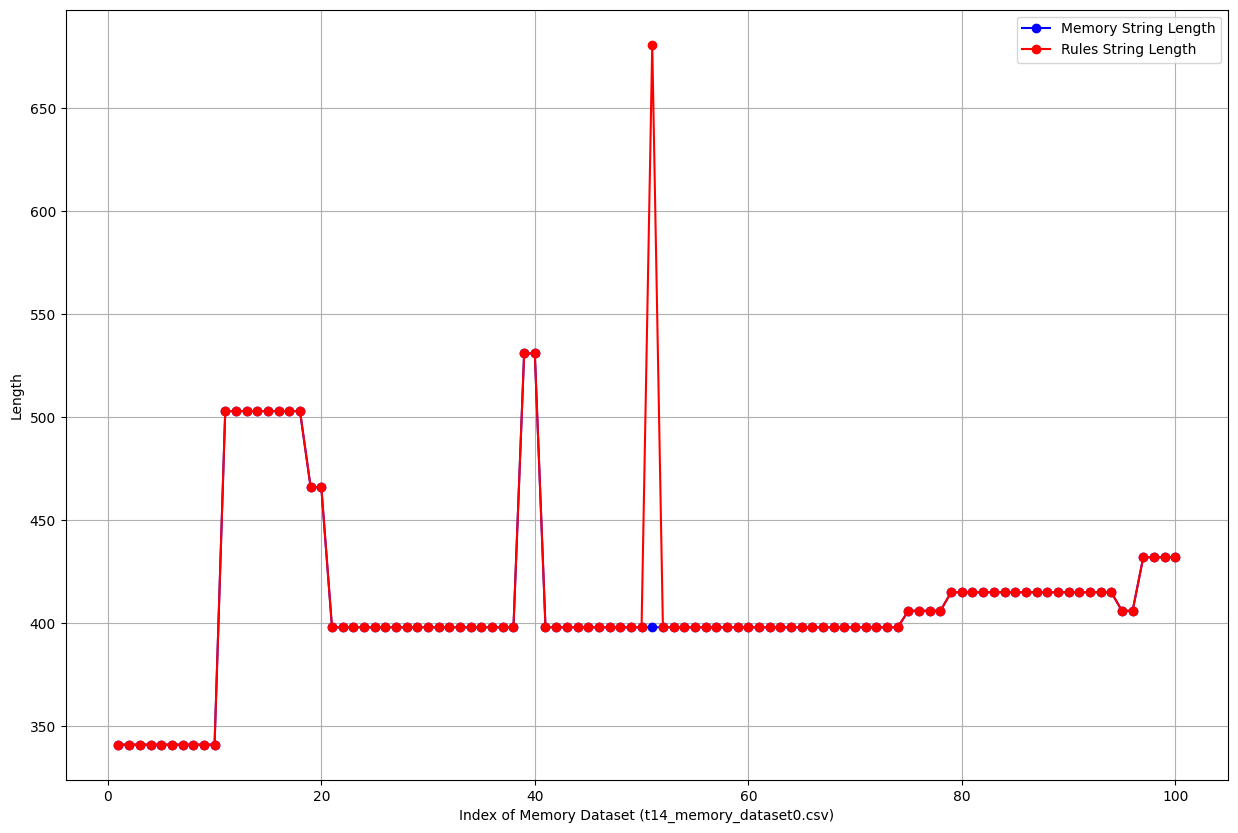

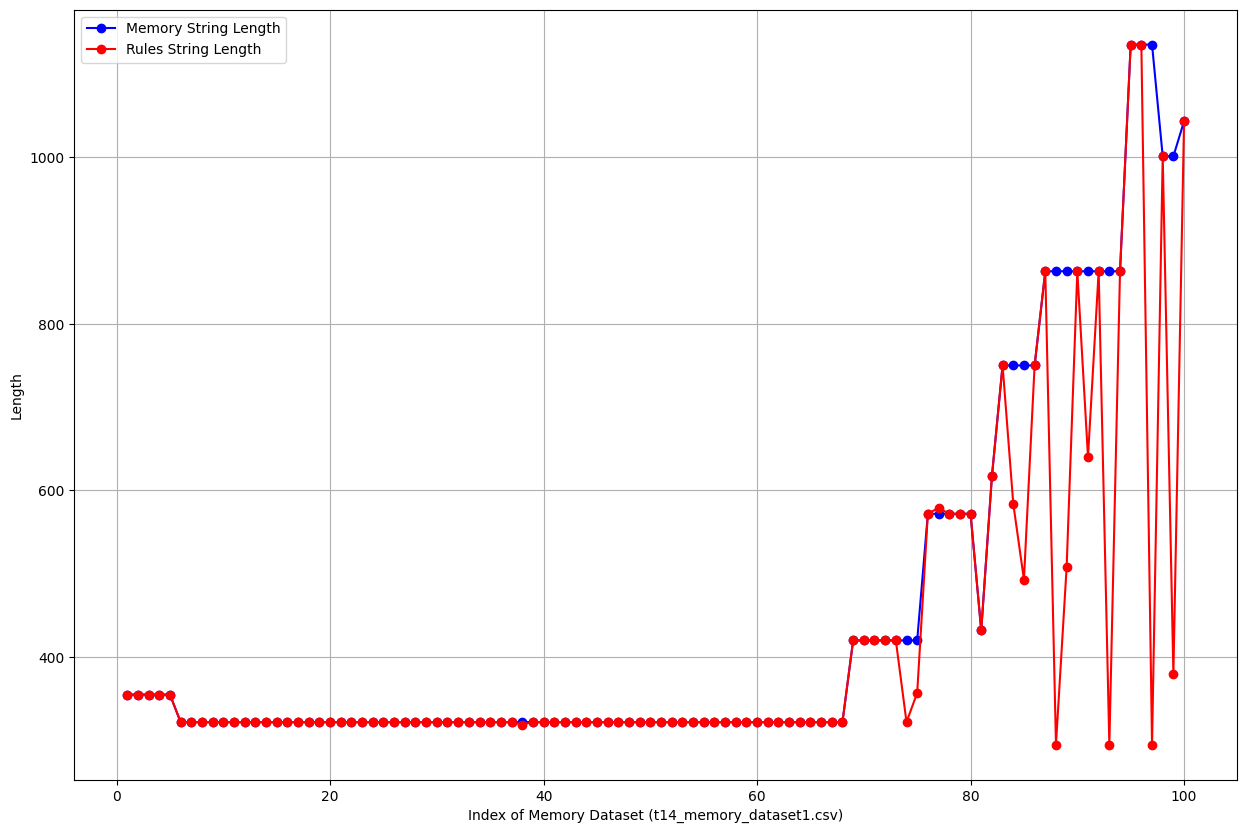

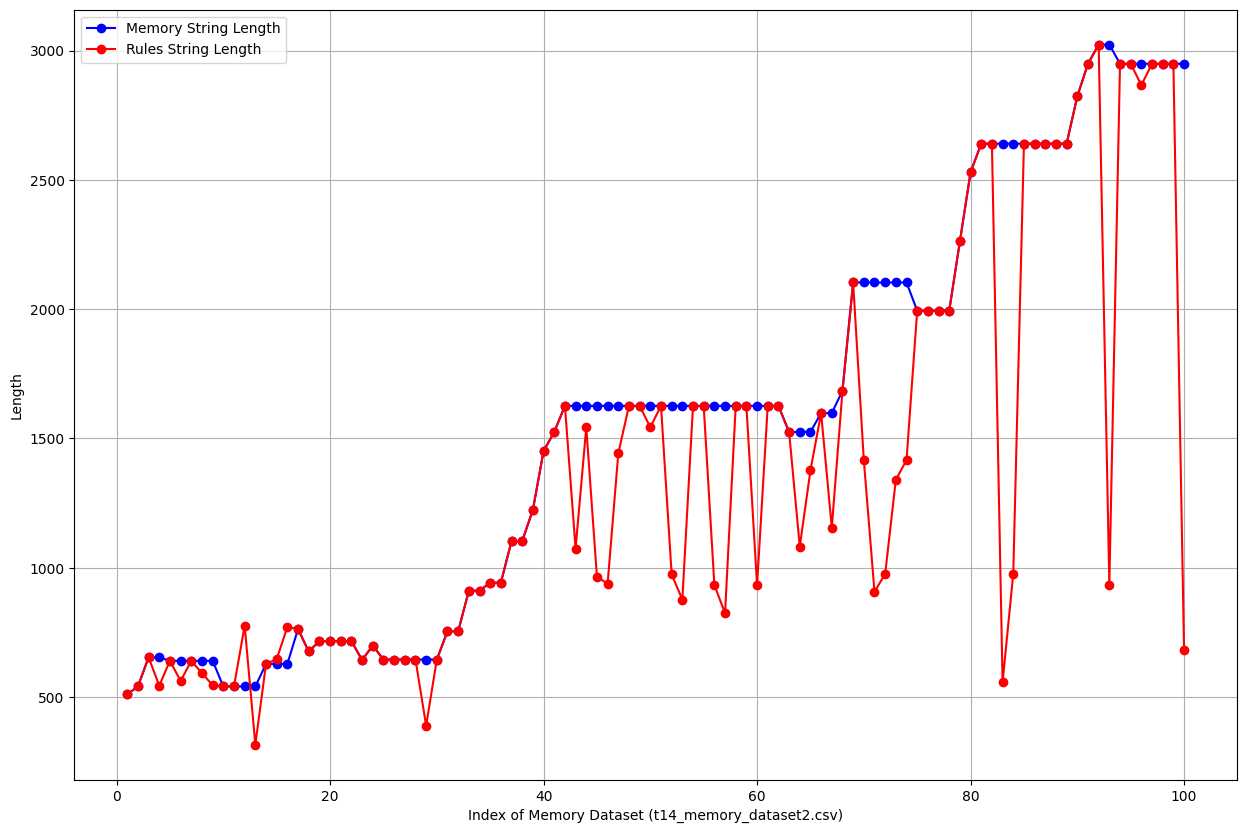

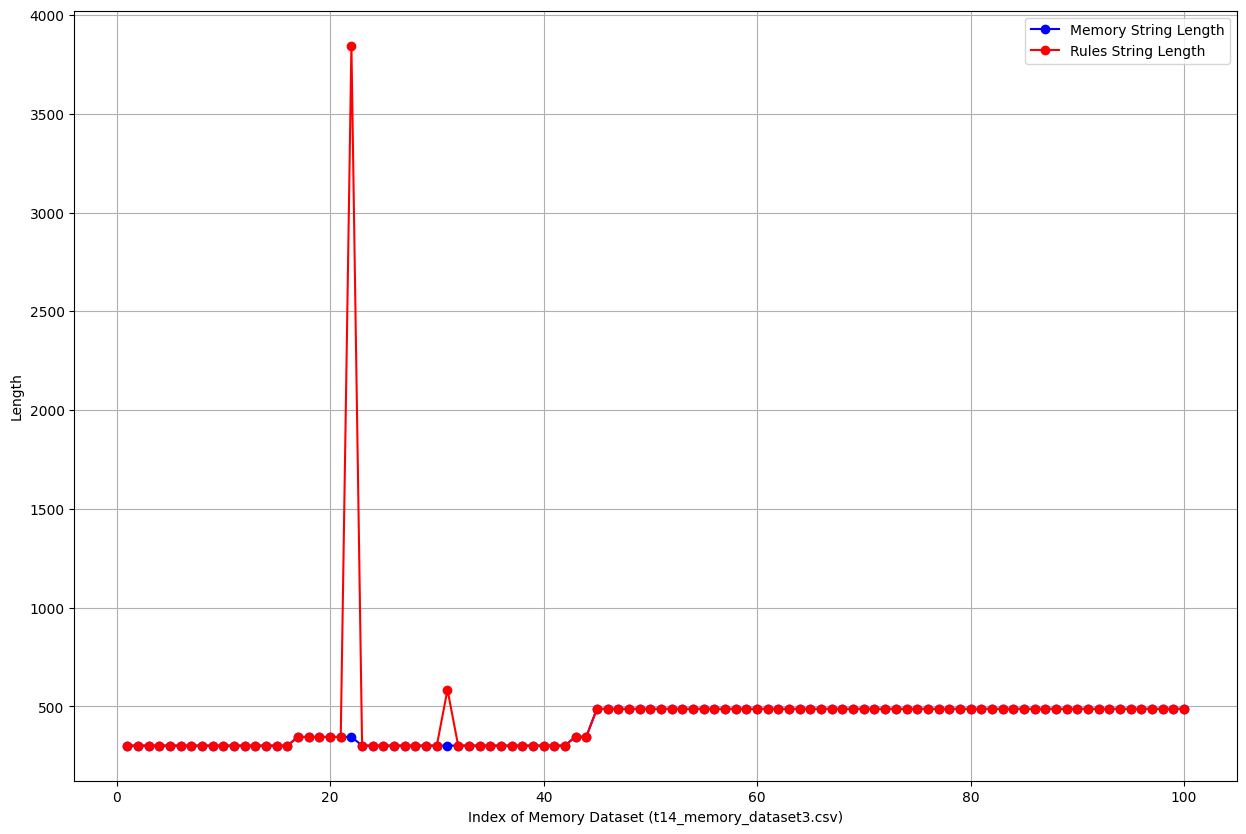

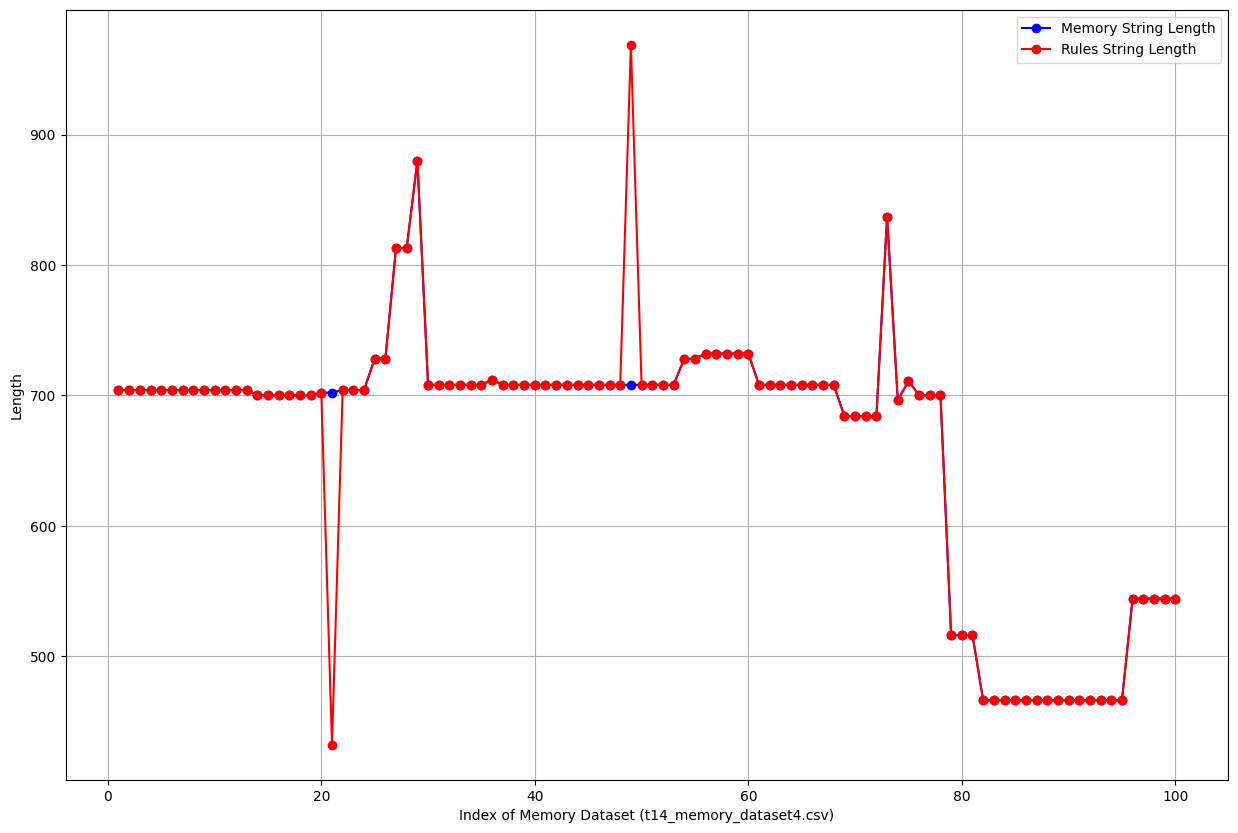

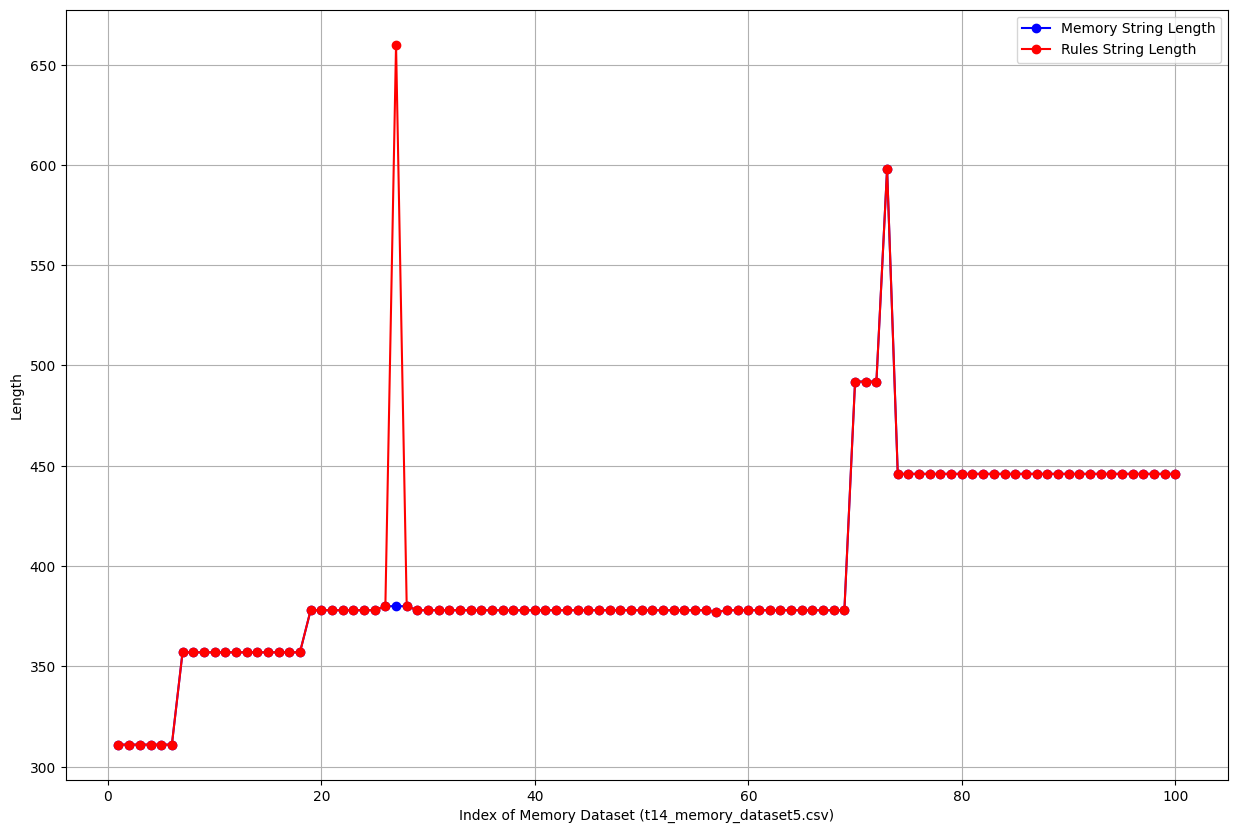

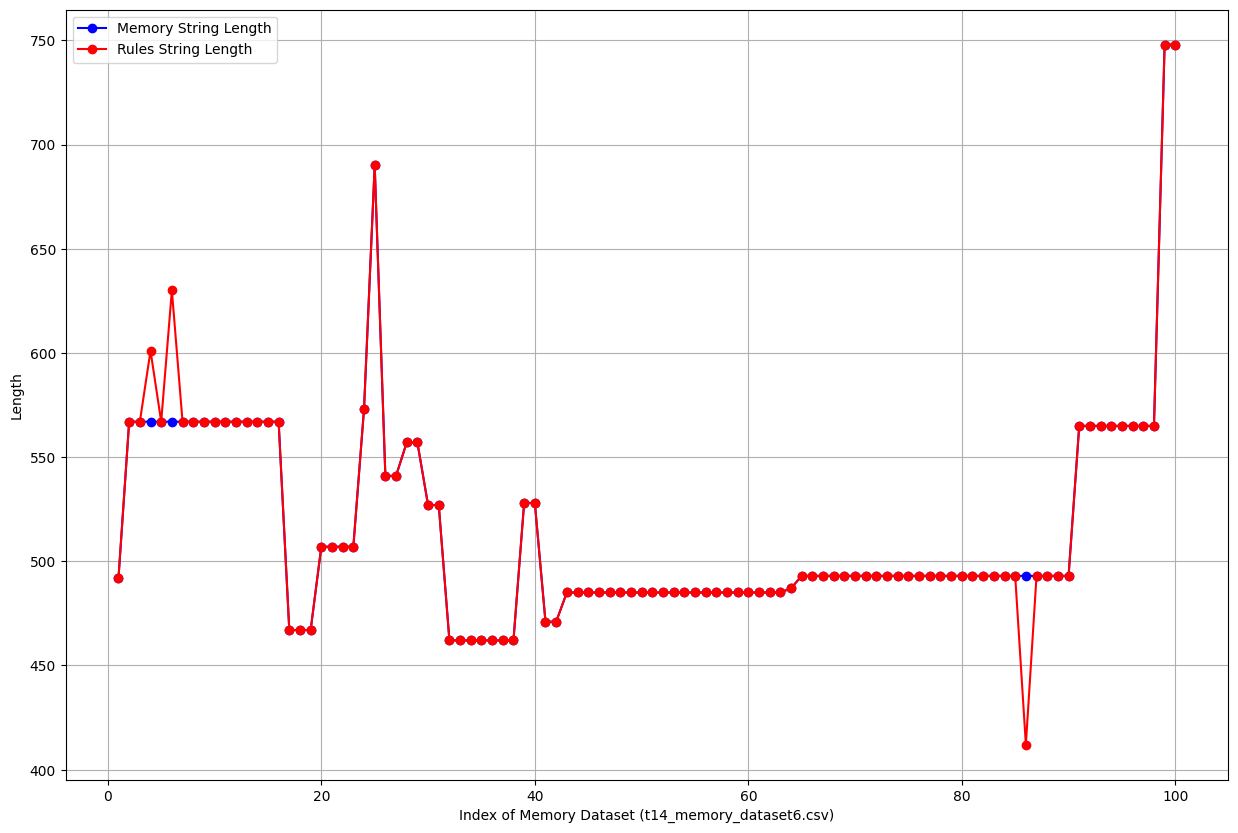

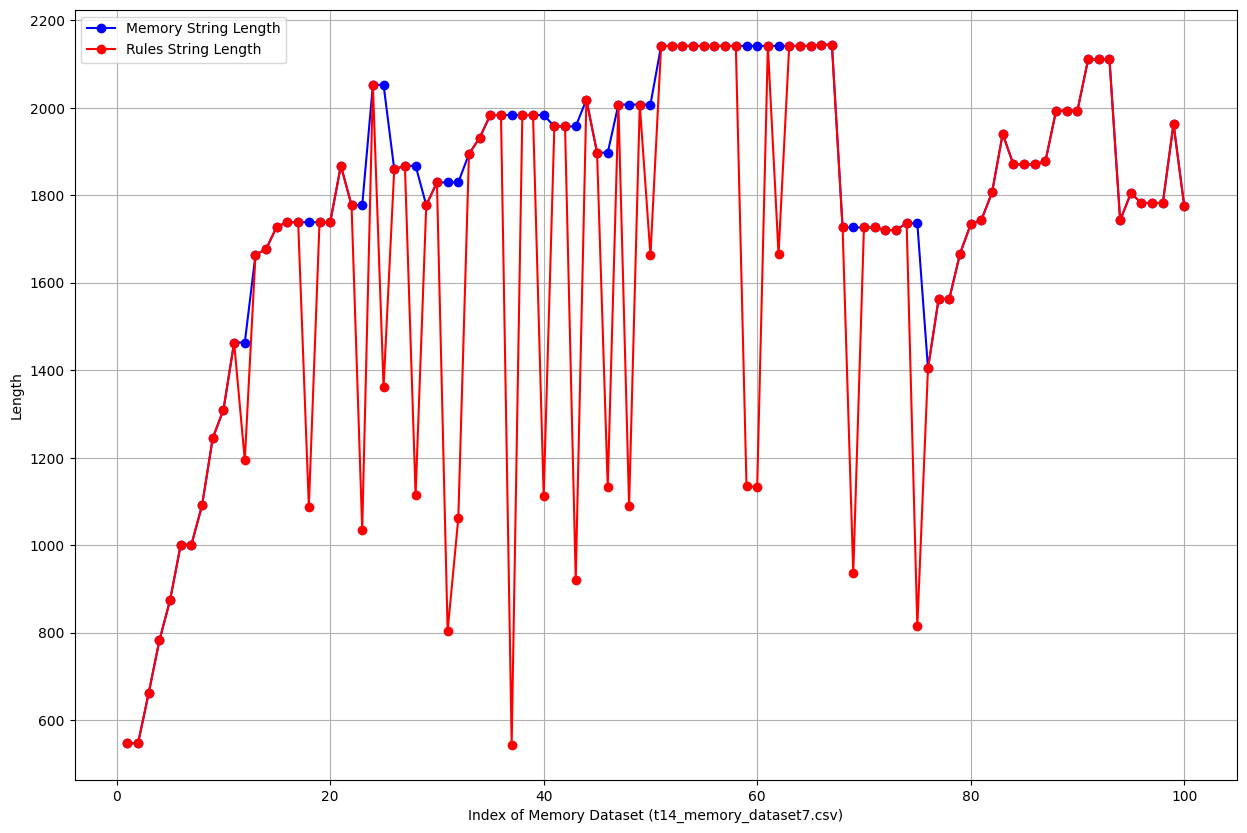

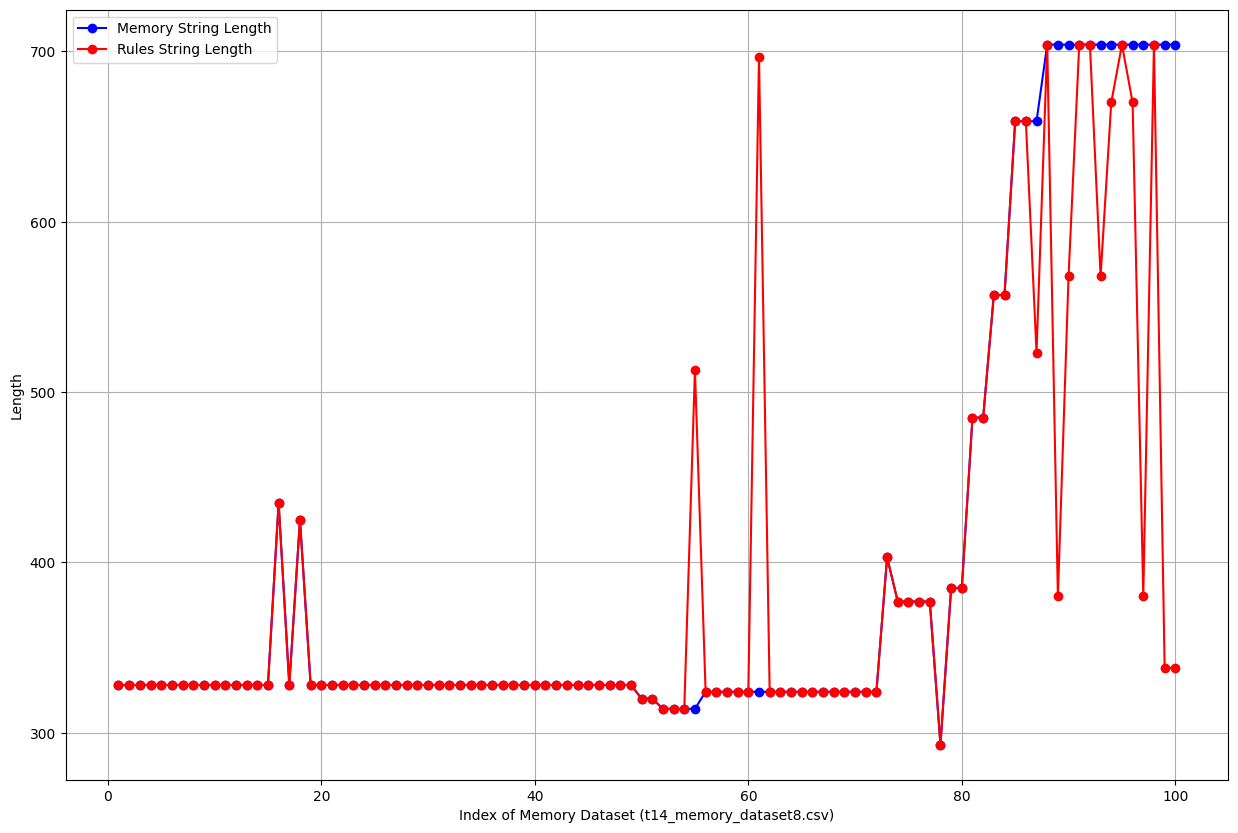

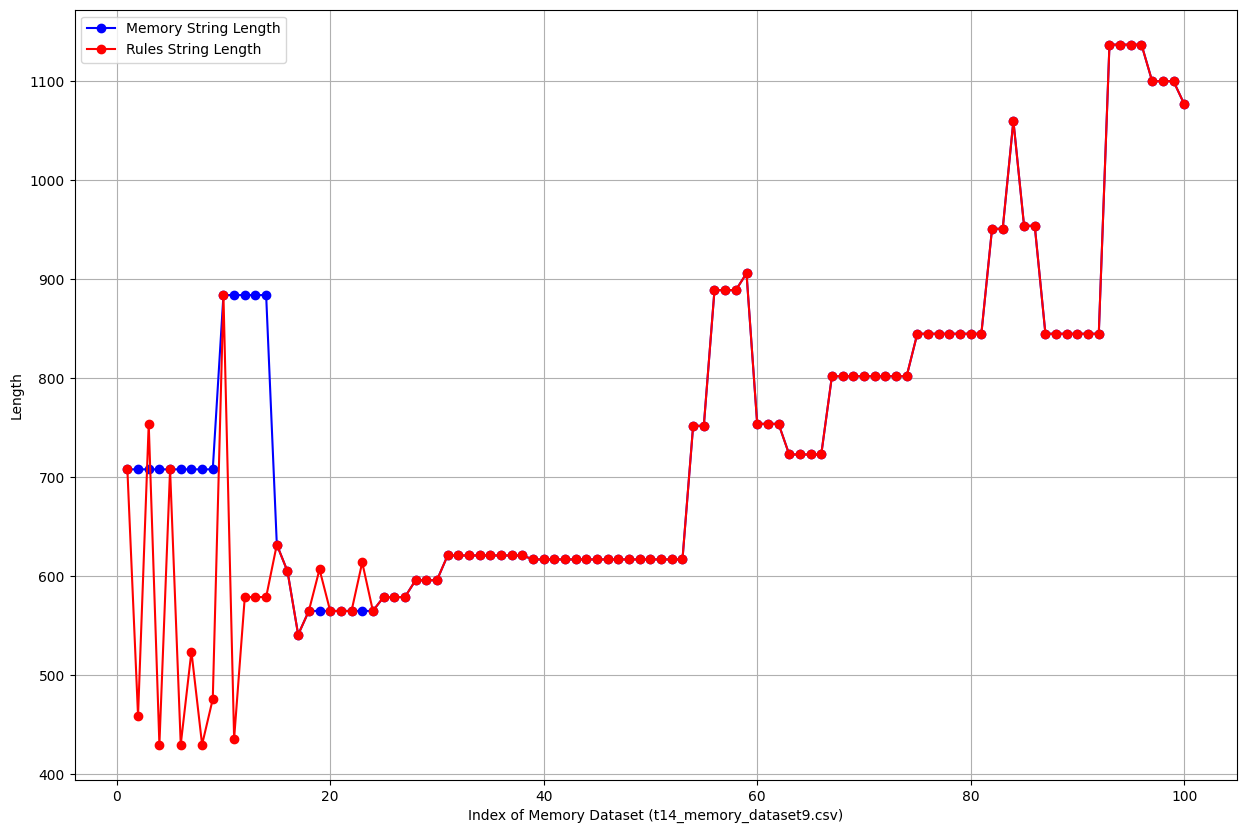

In [23]:
# individual memory string length for T14

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")
    x_indices = []
    y_str_length_mem = []
    y_str_length_rules = []
 
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_str_length_mem.append(len(row['cmem_t_memory_str']))
        y_str_length_rules.append(len(row['cmem_t_rules_str']))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_str_length_mem, label='Memory String Length', color='blue', marker='o')
    plt.plot(x_indices, y_str_length_rules, label='Rules String Length', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (t14_memory_dataset{i}.csv)')
    plt.ylabel('Length')
    # plt.title(f'Length of Memory and Rules')
    plt.legend()
    plt.grid(True)

    plt.show()

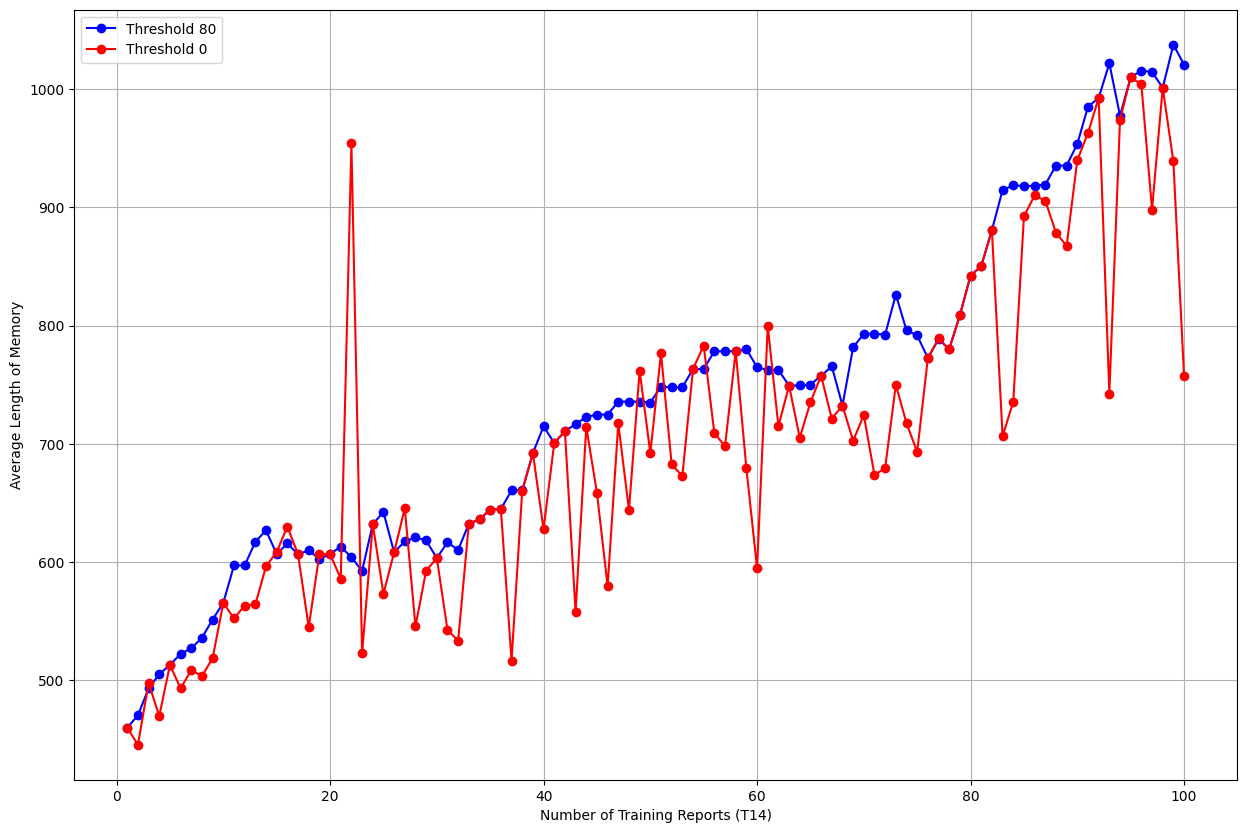

In [24]:
# average memory string length for T14
y_str_length_mem_arr = np.array([0]*100)
y_str_length_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_str_length_mem_arr[idx] += len(row['cmem_t_memory_str'])
        y_str_length_rules_arr[idx] += len(row['cmem_t_rules_str']) 

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_str_length_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_str_length_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports (T14)')
plt.ylabel('Average Length of Memory')
# plt.title(f'Length of Memory and Rules')
plt.legend()
plt.grid(True)

plt.show()


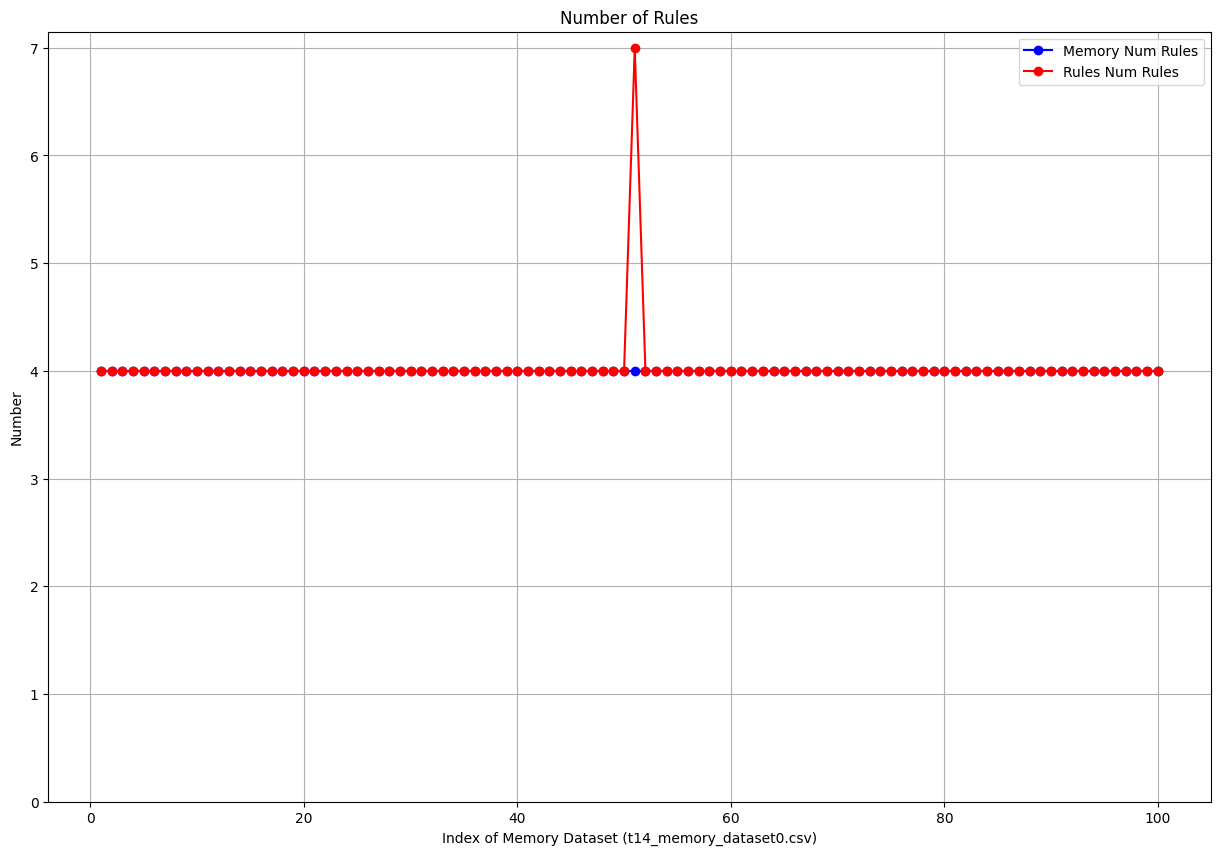

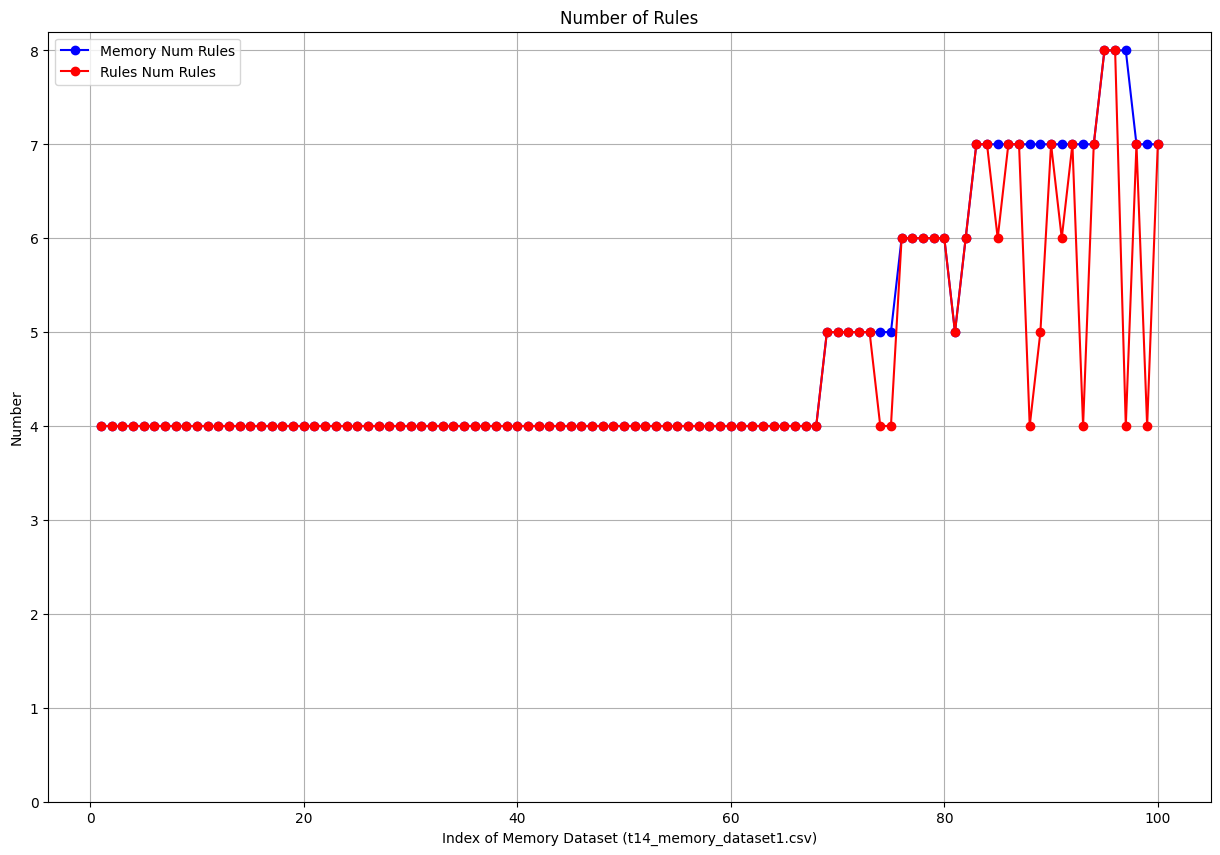

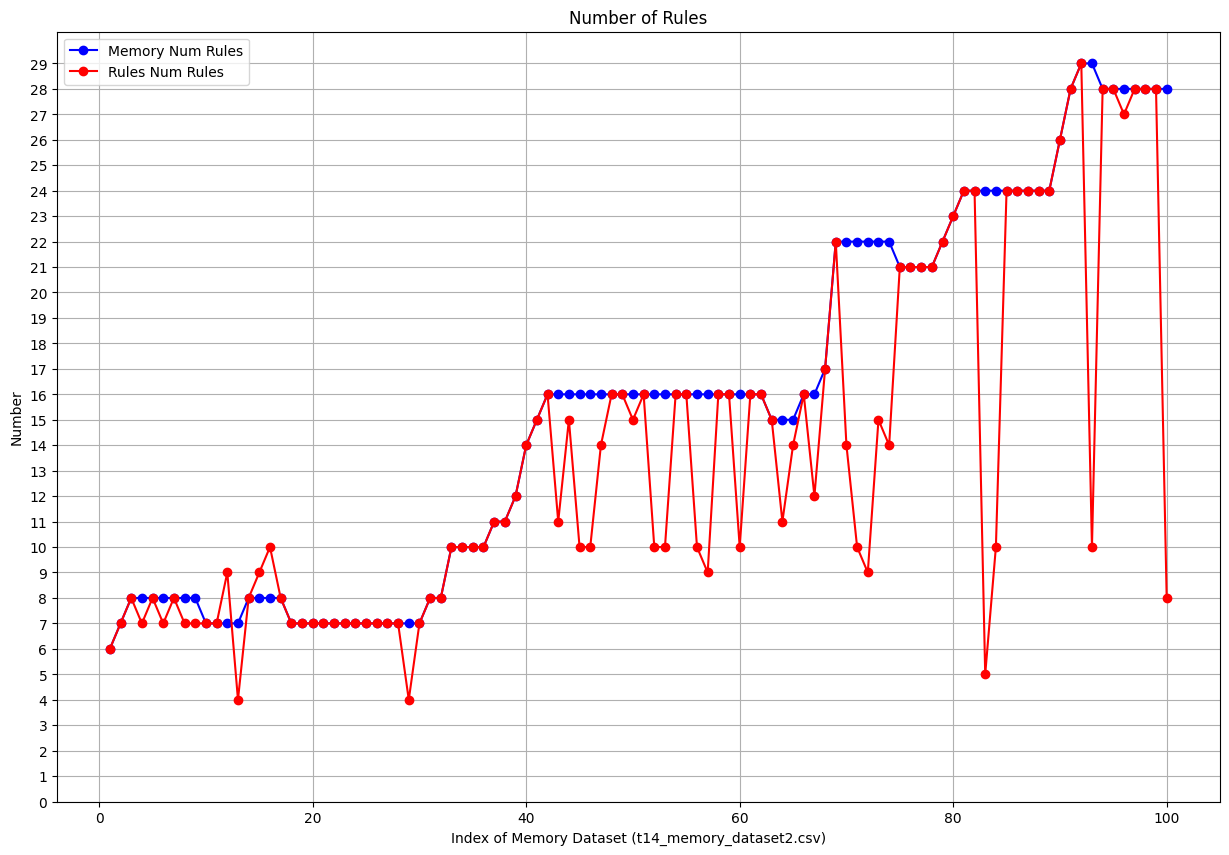

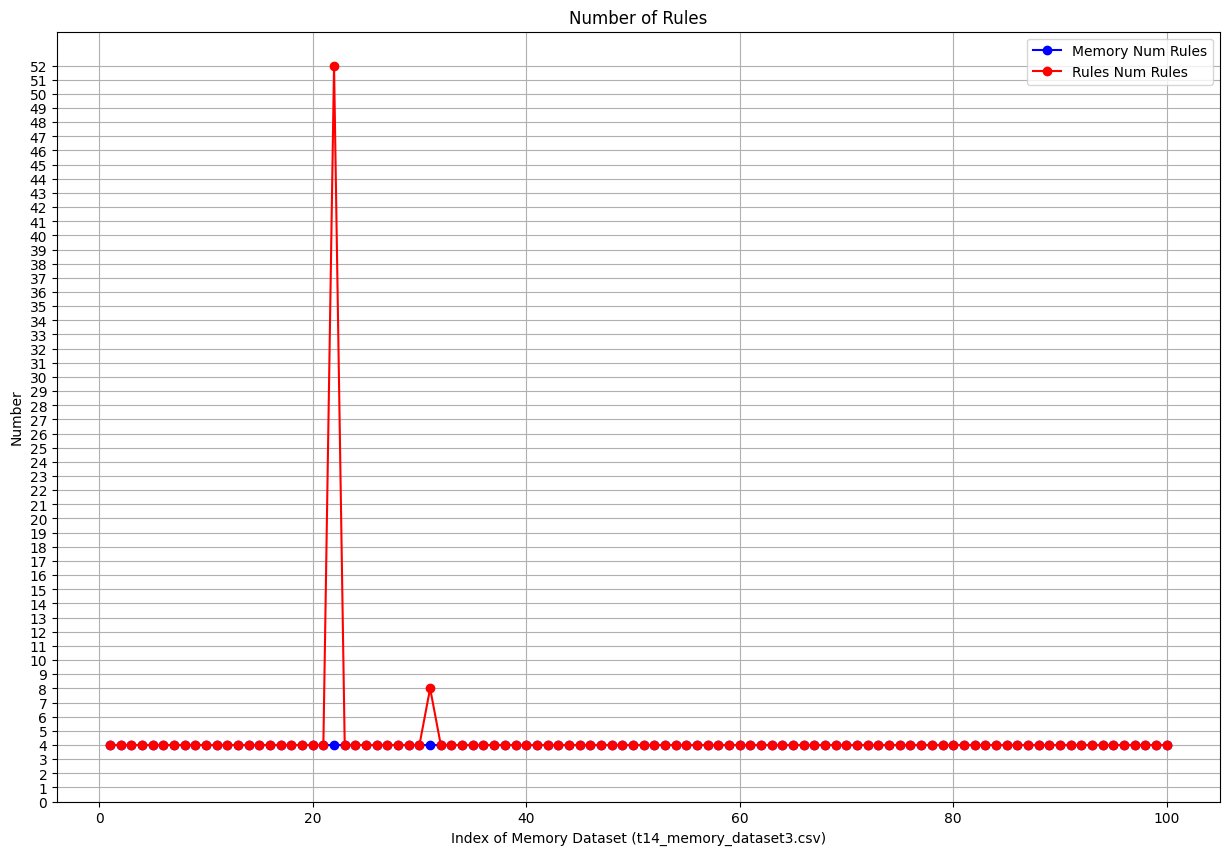

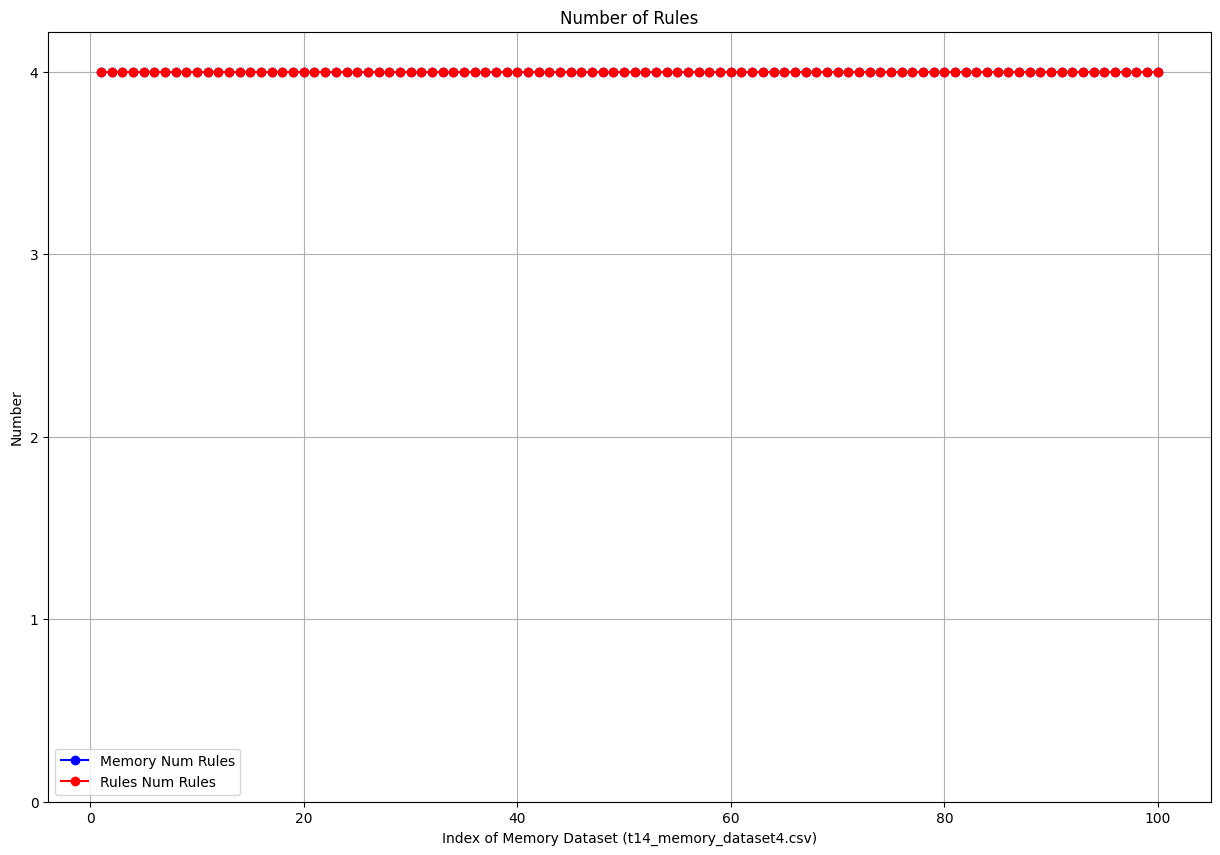

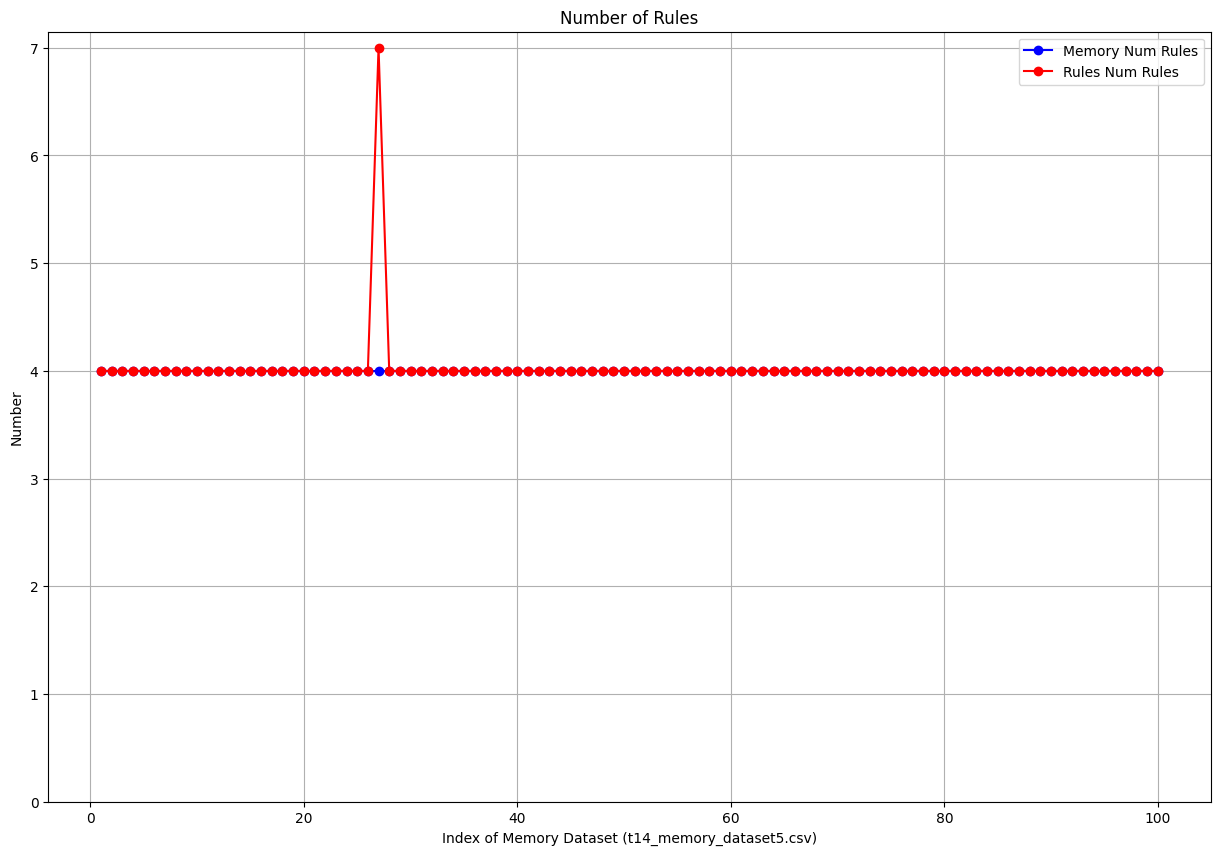

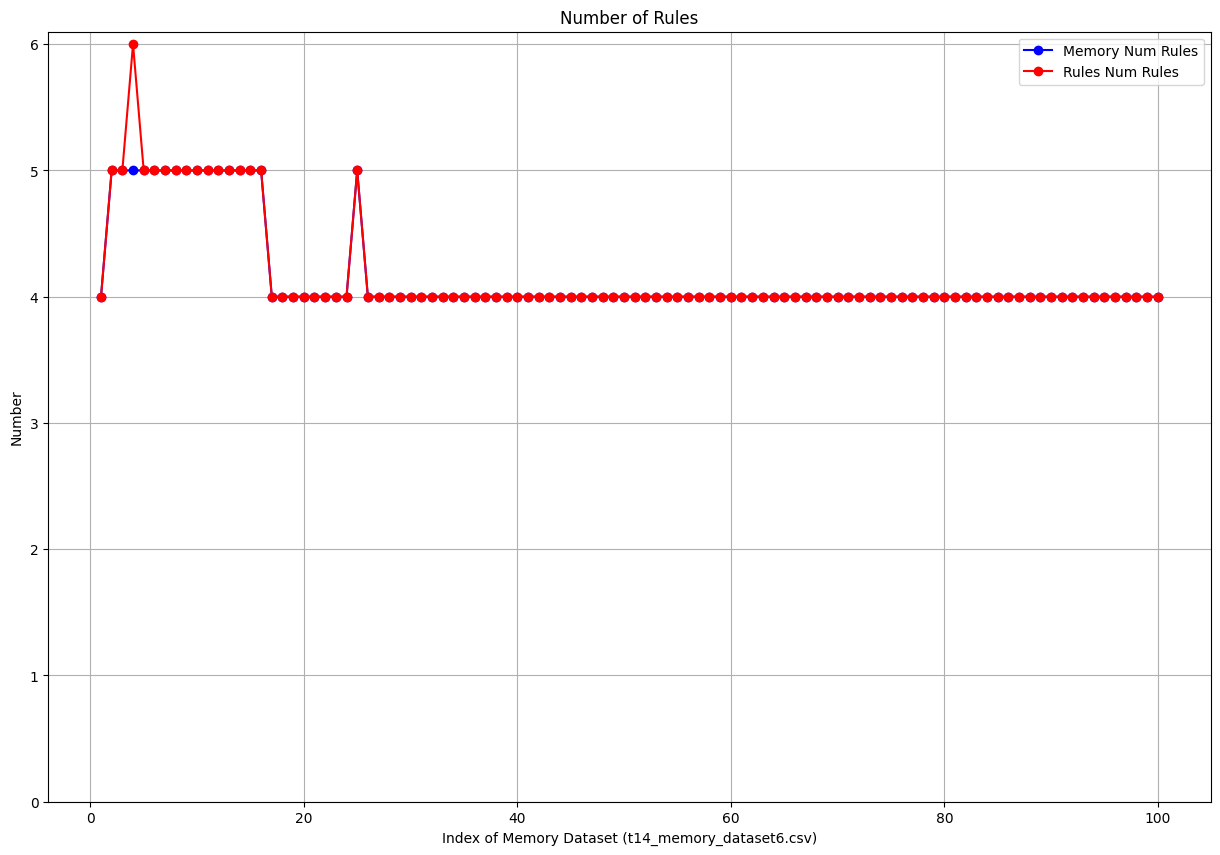

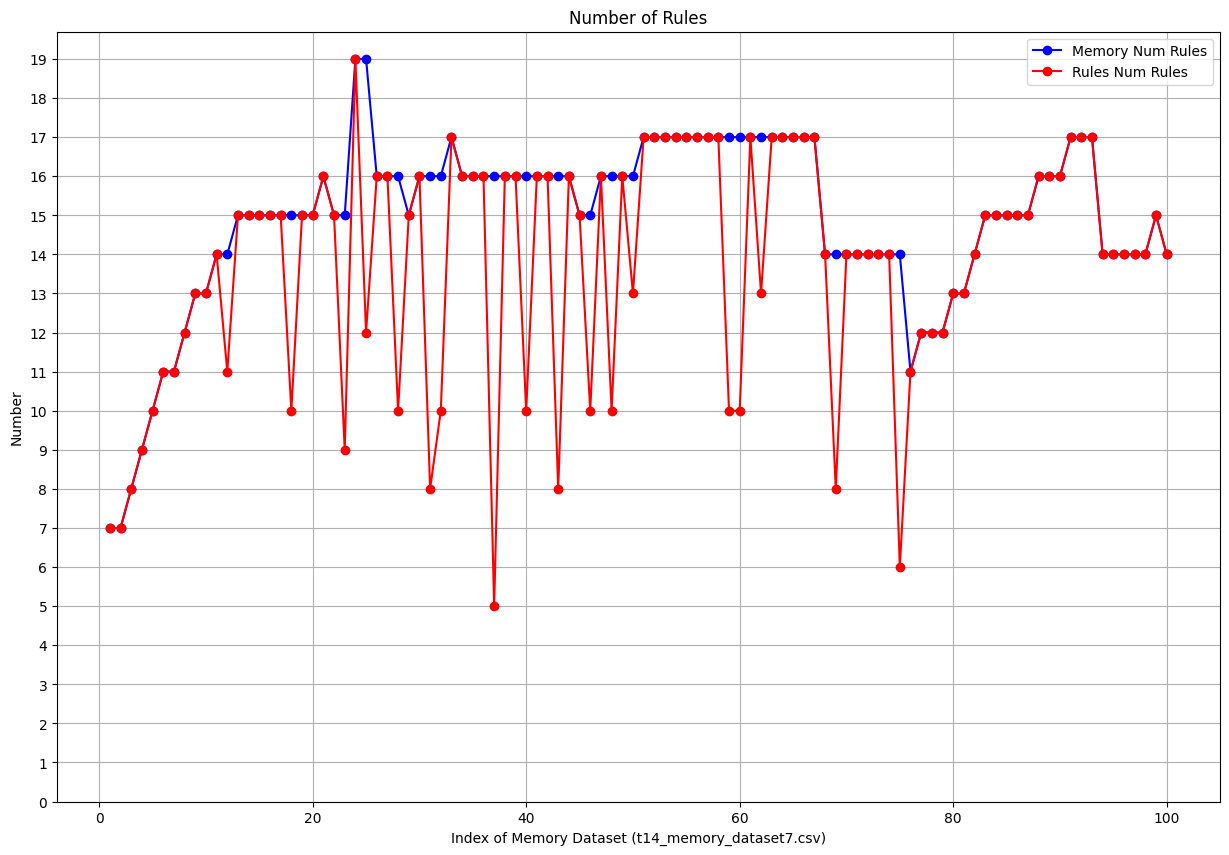

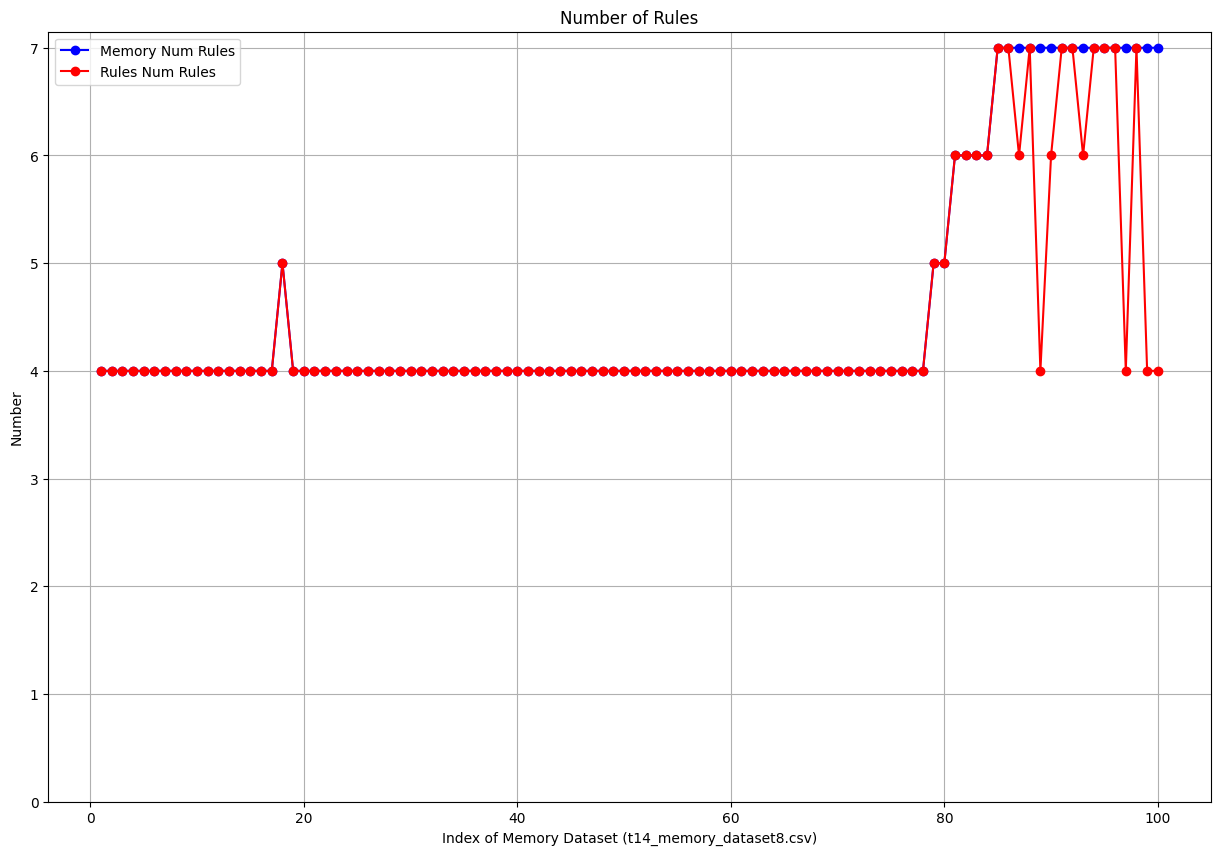

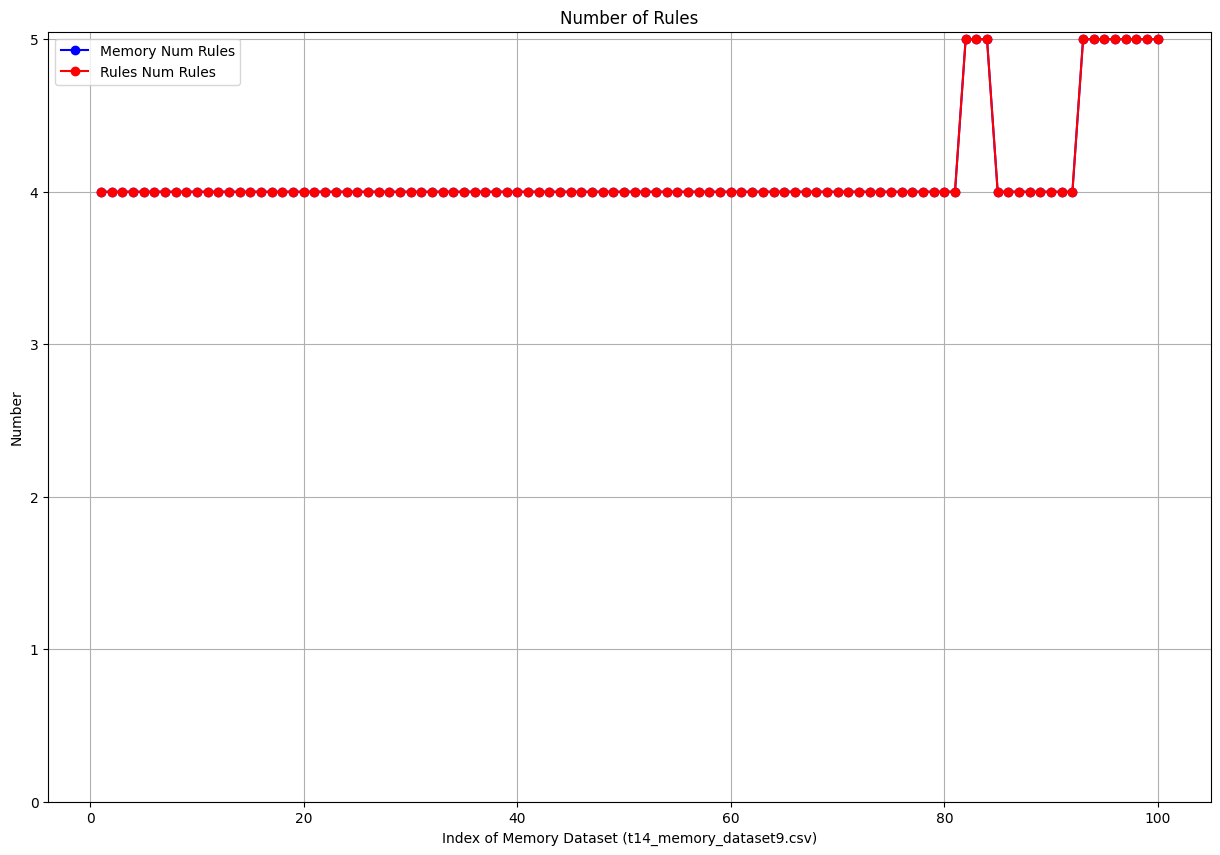

In [25]:
# individual number of rules in memory for T14
for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")
    x_indices = []

    y_num_rules_mem = []
    y_num_rules_rules = []
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_num_rules_mem.append(len(row['cmem_t_memory_str'].split("\n")))
        y_num_rules_rules.append(len(row['cmem_t_rules_str'].split("\n")))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_num_rules_mem, label='Memory Num Rules', color='blue', marker='o')
    plt.plot(x_indices, y_num_rules_rules, label='Rules Num Rules', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (t14_memory_dataset{i}.csv)')
    plt.ylabel('Number')
    plt.title(f'Number of Rules')
    plt.legend()
    plt.grid(True)

    max_y = max(max(y_num_rules_mem), max(y_num_rules_rules))
    plt.yticks(range(0, int(max_y) + 1))

    plt.show()

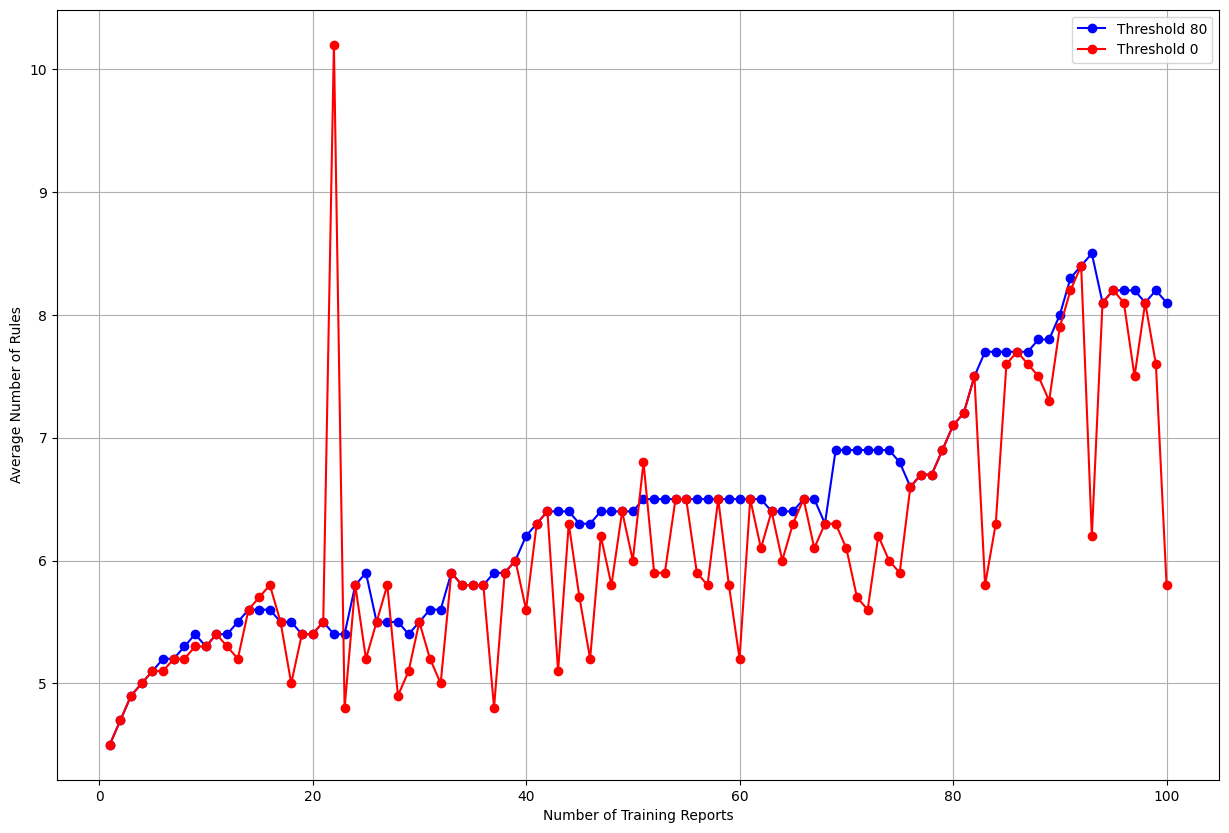

In [26]:
# average number of rules in memory for T14
y_num_rules_mem_arr = np.array([0]*100)
y_num_rules_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_num_rules_mem_arr[idx] += len(row['cmem_t_memory_str'].split("\n"))
        y_num_rules_rules_arr[idx] += len(row['cmem_t_rules_str'].split("\n"))

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_num_rules_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_num_rules_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports')
plt.ylabel('Average Number of Rules')

plt.legend()
plt.grid(True)

plt.show()

### n

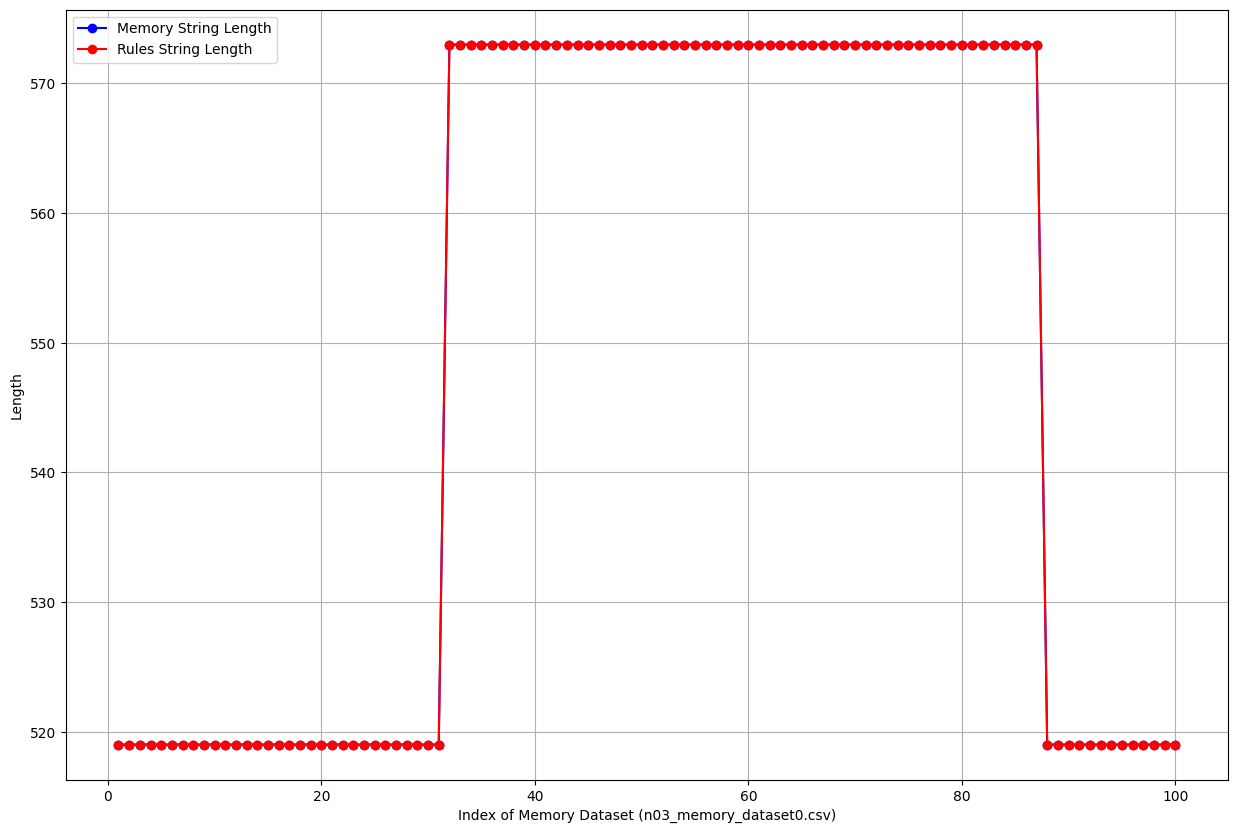

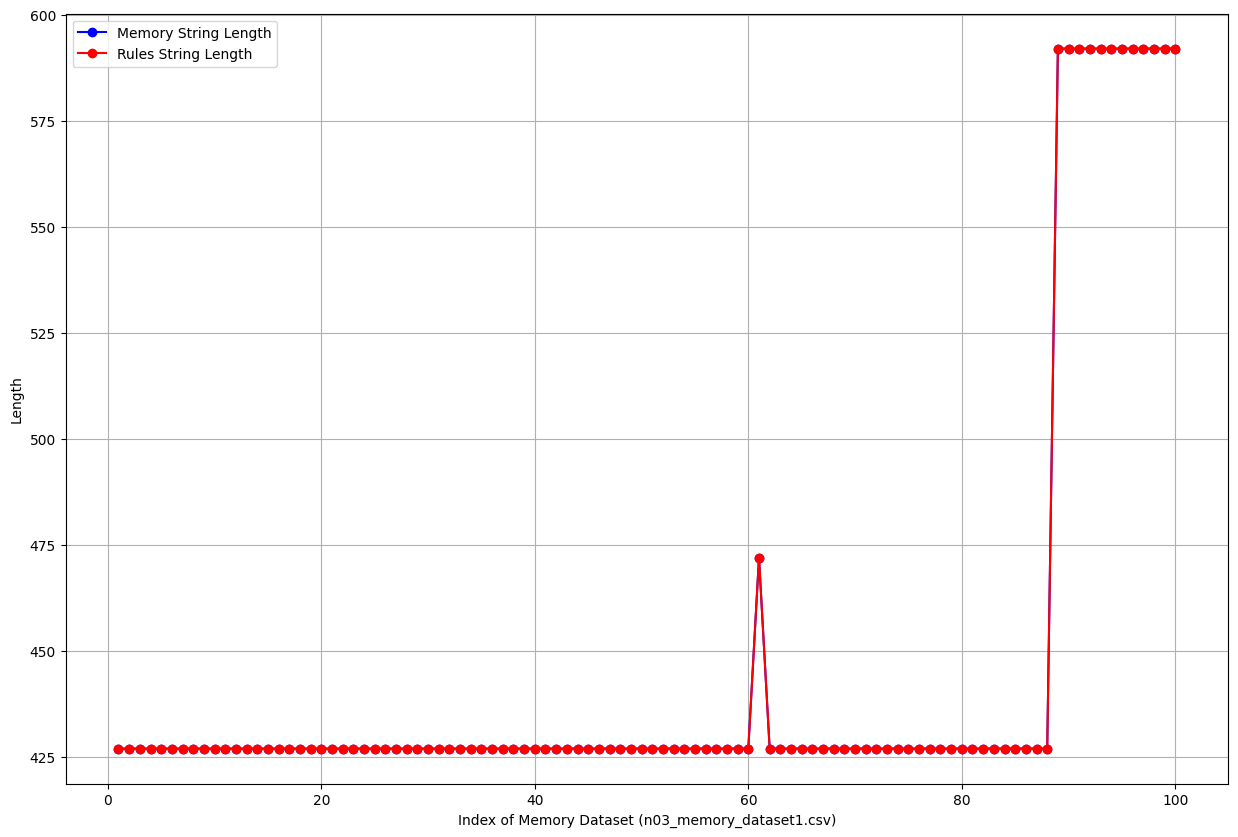

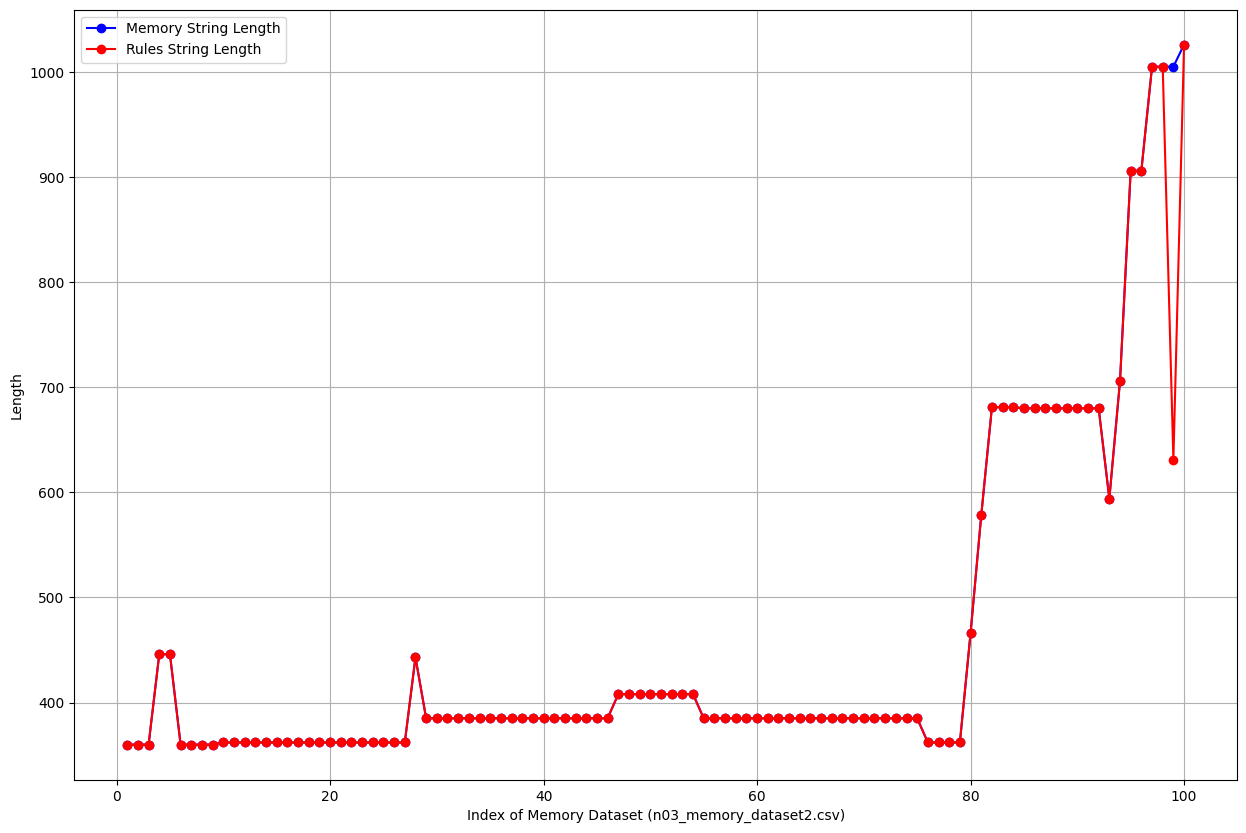

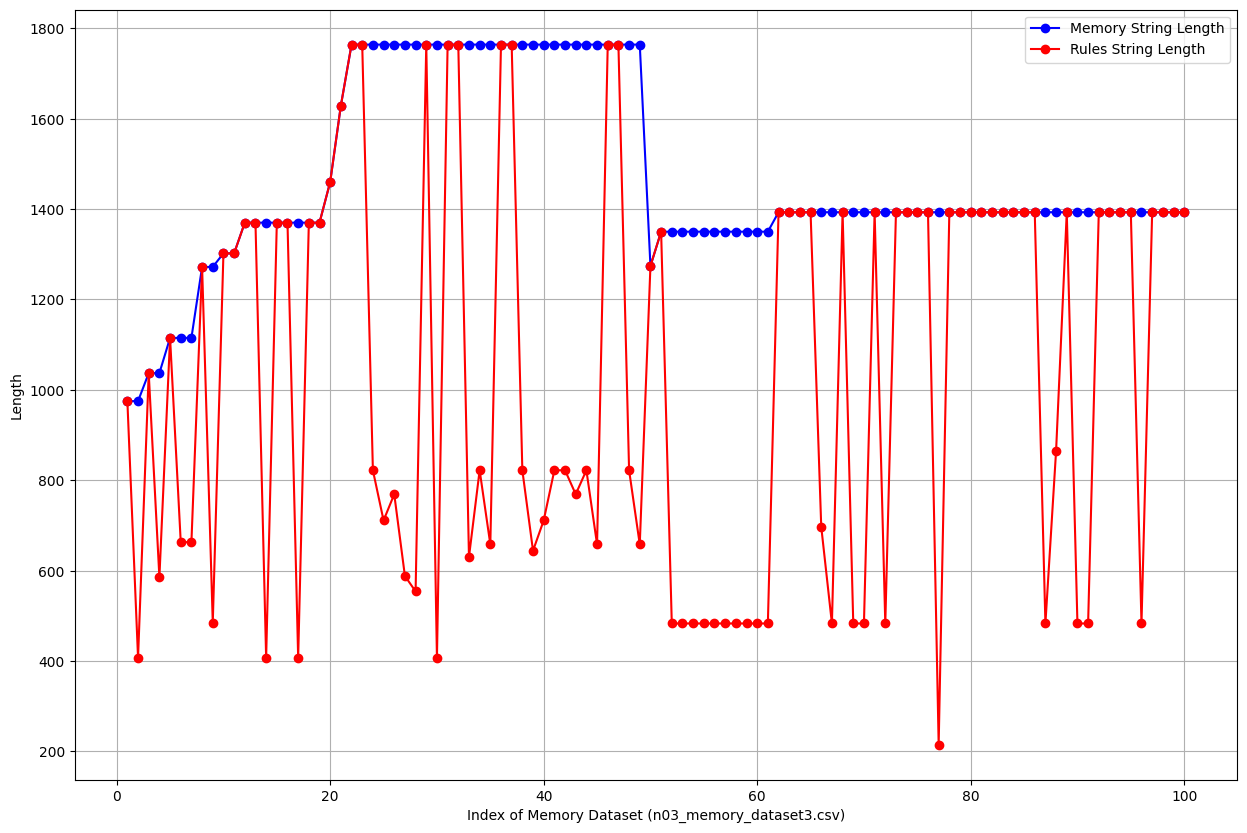

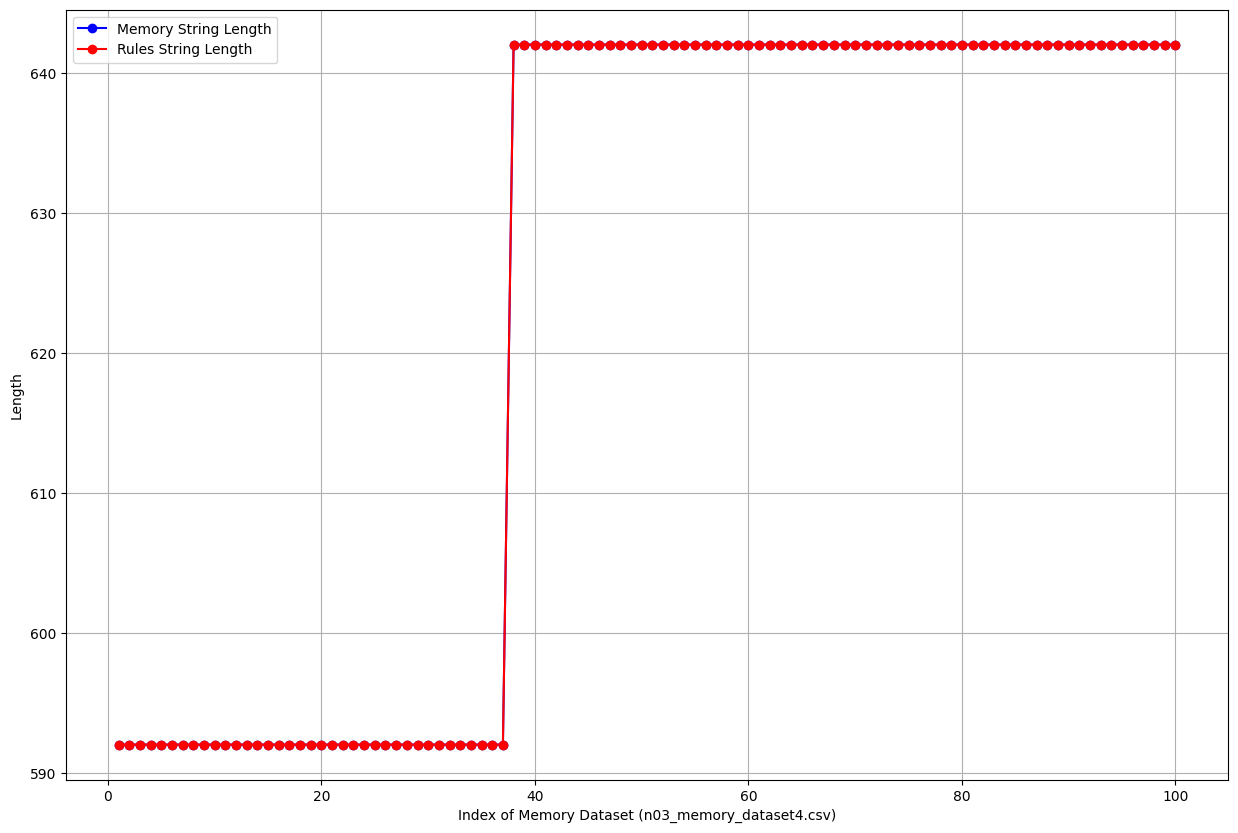

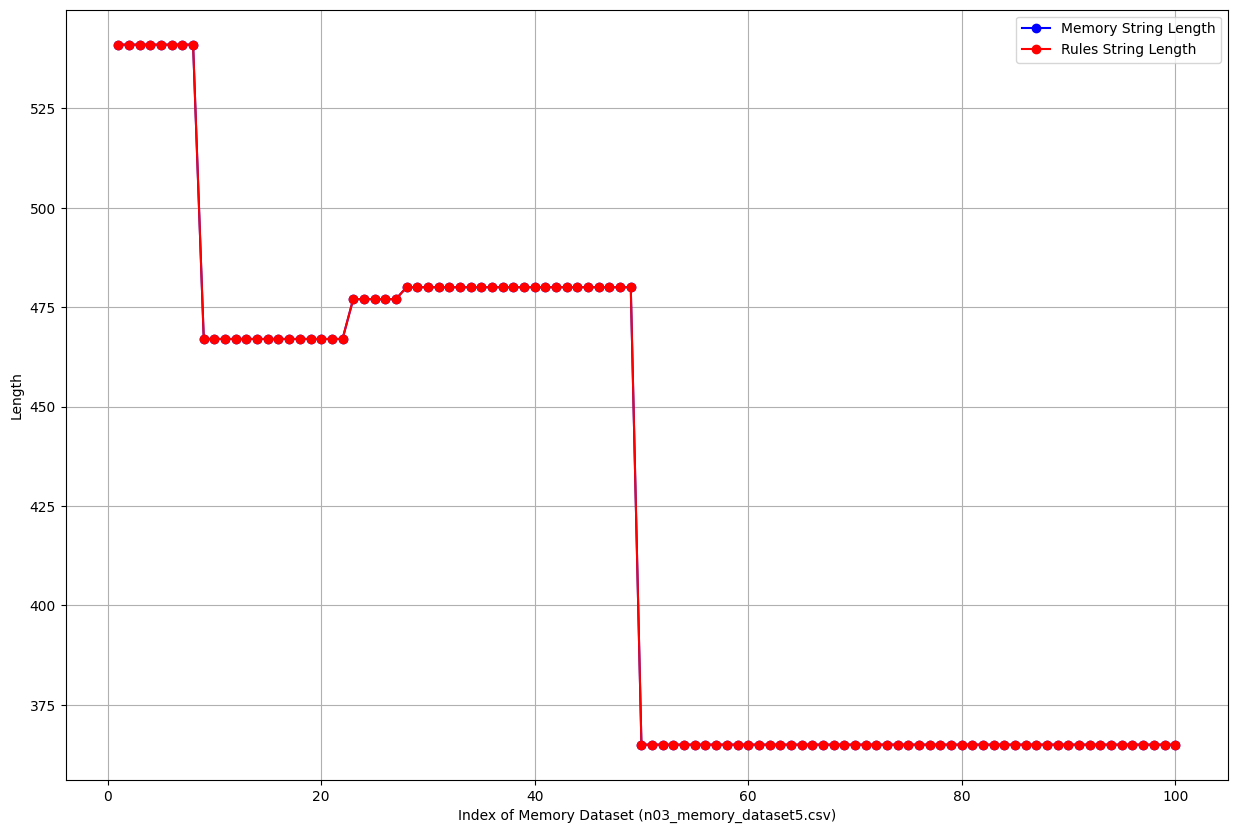

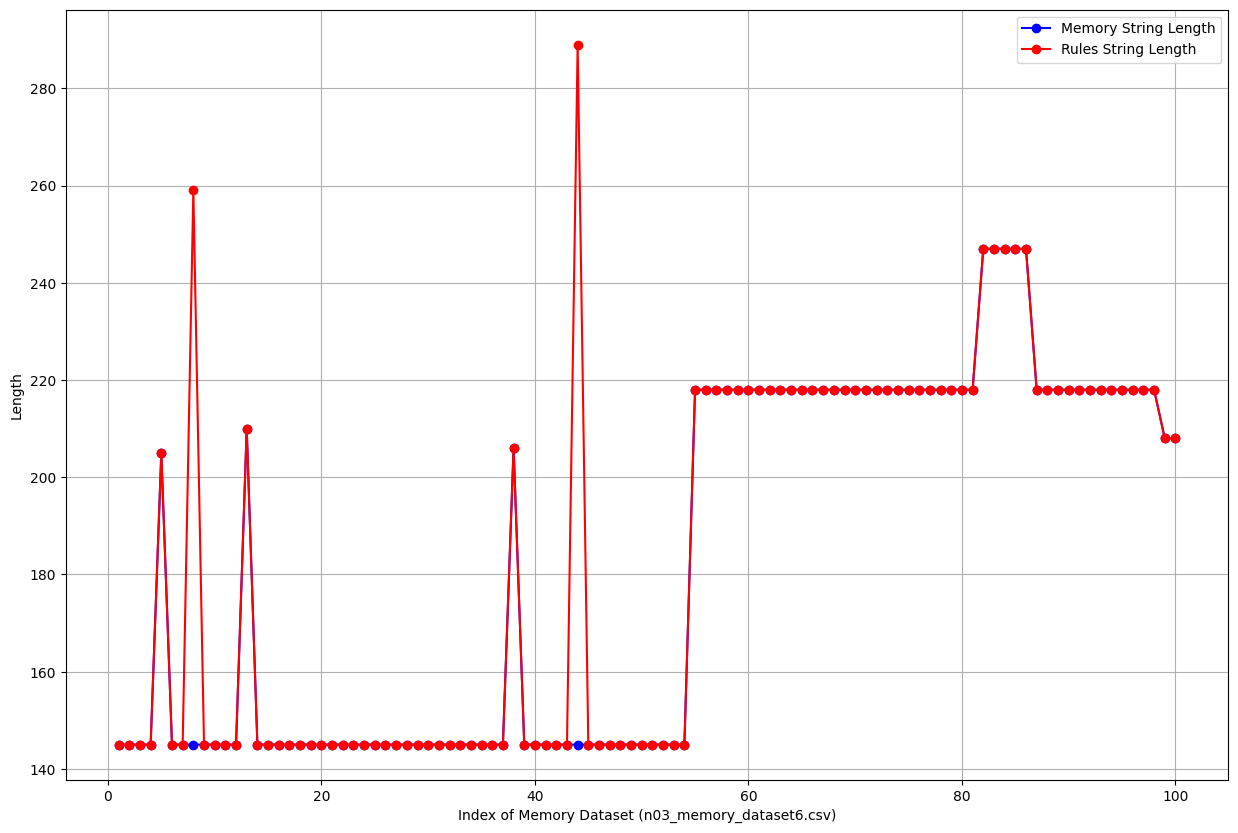

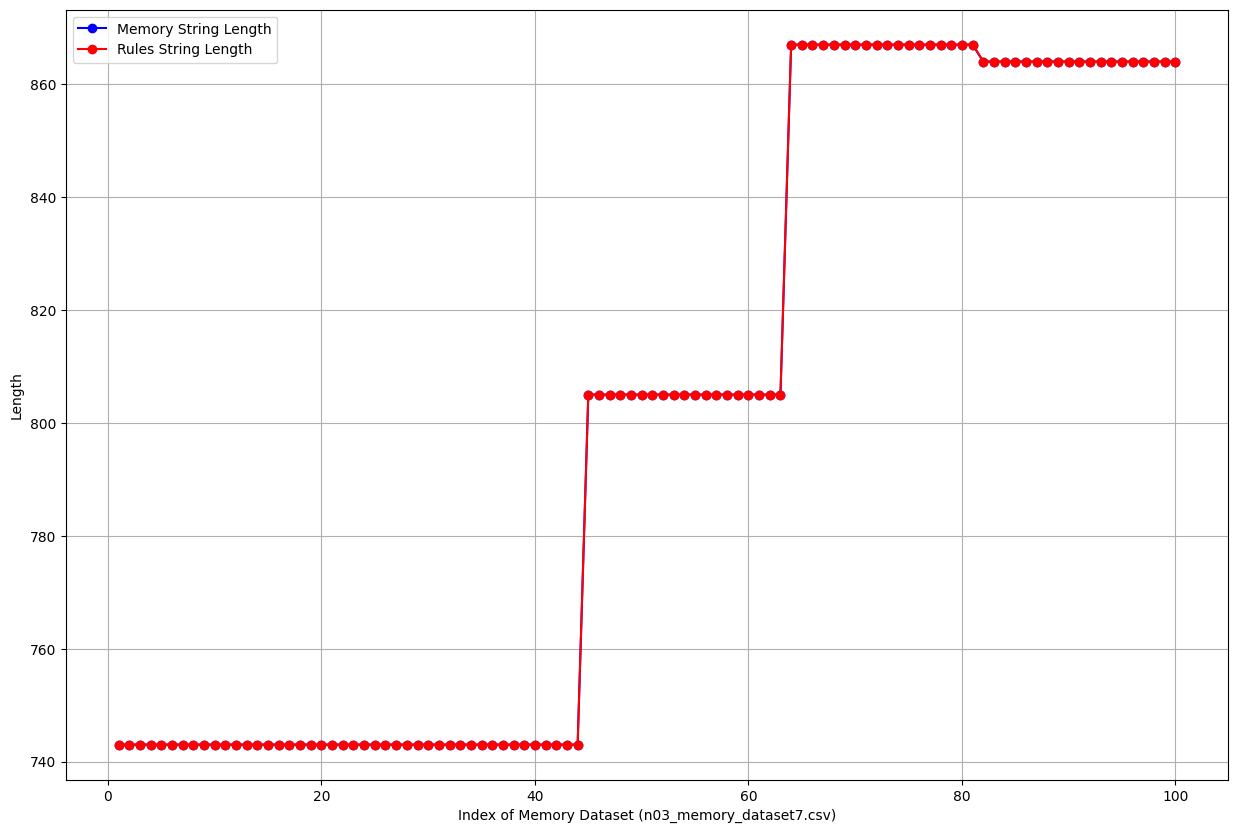

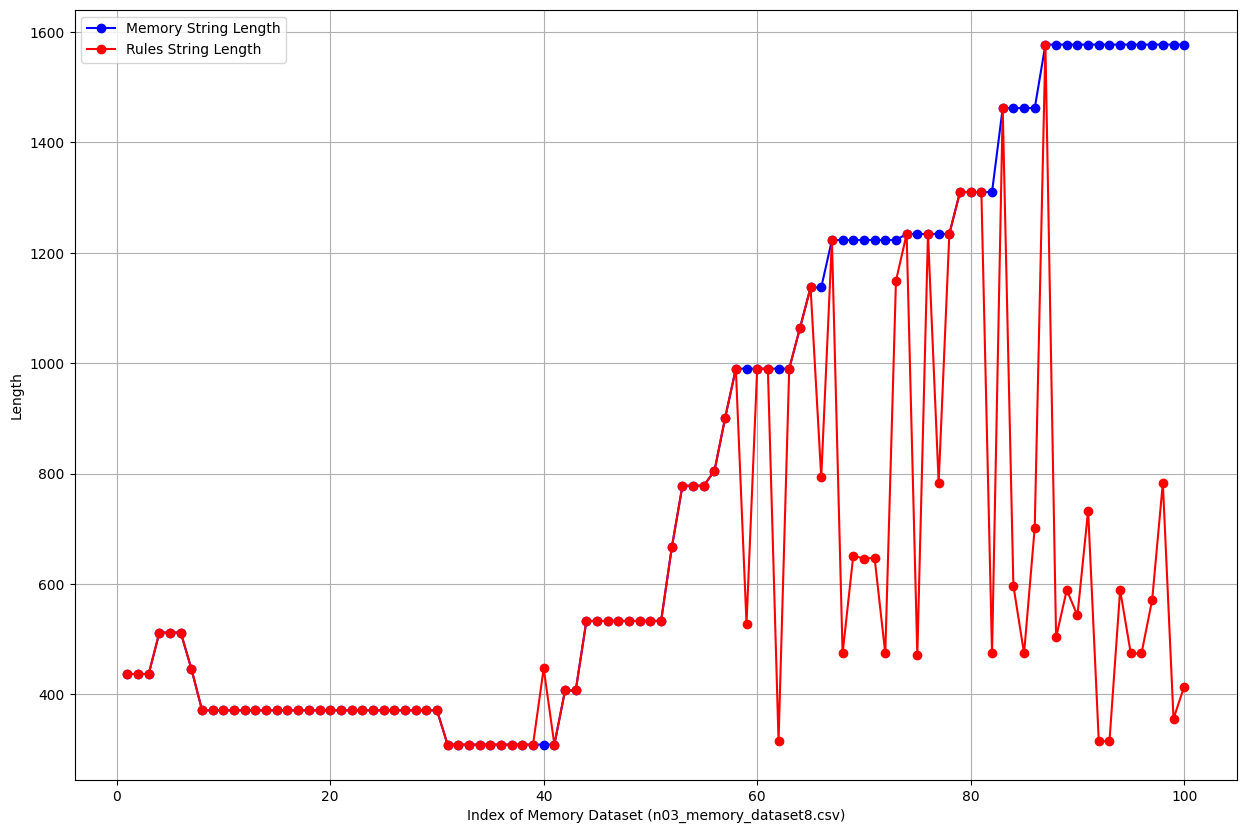

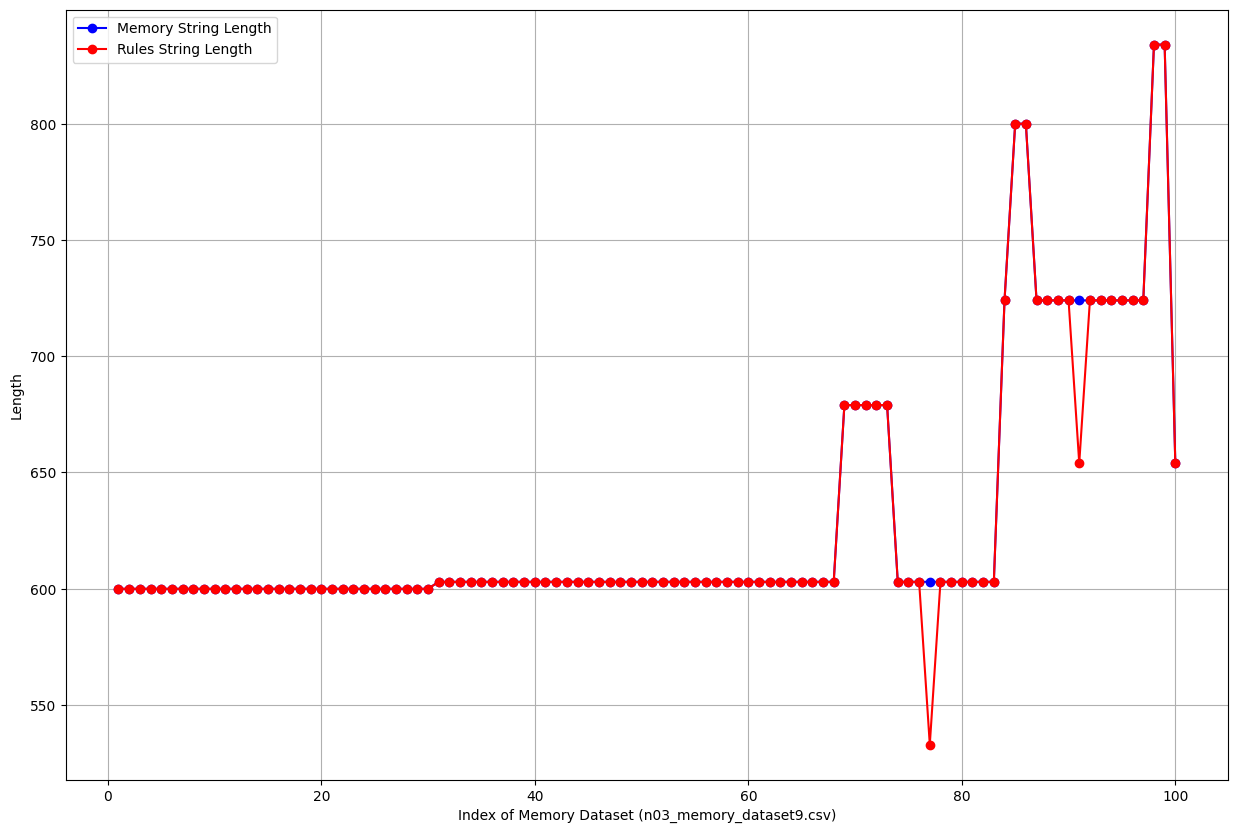

In [27]:
# individual memory string length for N03
for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv")
    x_indices = []
    y_str_length_mem = []
    y_str_length_rules = []
 
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_str_length_mem.append(len(row['cmem_n_memory_str']))
        y_str_length_rules.append(len(row['cmem_n_rules_str']))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_str_length_mem, label='Memory String Length', color='blue', marker='o')
    plt.plot(x_indices, y_str_length_rules, label='Rules String Length', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (n03_memory_dataset{i}.csv)')
    plt.ylabel('Length')
    # plt.title(f'Length of Memory and Rules')
    plt.legend()
    plt.grid(True)

    plt.show()

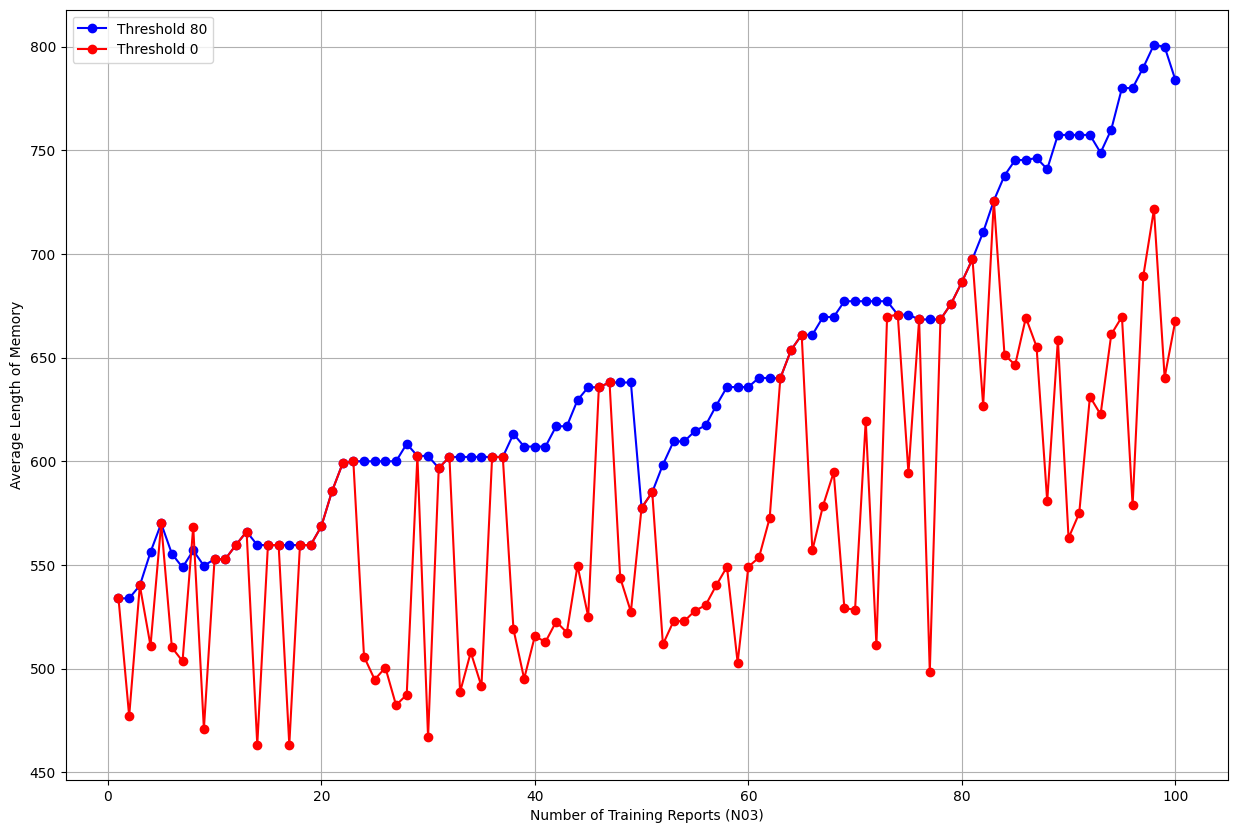

In [28]:
# average memory string length for N03
y_str_length_mem_arr = np.array([0]*100)
y_str_length_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_str_length_mem_arr[idx] += len(row['cmem_n_memory_str'])
        y_str_length_rules_arr[idx] += len(row['cmem_n_rules_str']) 

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_str_length_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_str_length_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports (N03)')
plt.ylabel('Average Length of Memory')
# plt.title(f'Length of Memory and Rules')
plt.legend()
plt.grid(True)

plt.show()


# Create format instruction

In [ ]:
# class TrainingResponse(BaseModel):
#     reasoning: str = Field(description="reasoning to support predicted cancer stage")
#     predictedStage: str = Field(description="predicted cancer stage")
#     rules: List[str] = Field(description="list of rules") 

# class TestingResponse(BaseModel):
#     reasoning: str = Field(description="reasoning to support predicted cancer stage") 
#     predictedStage: str = Field(description="predicted cancer stage")
     

In [ ]:
# type(TrainingResponse.model_json_schema())

In [ ]:
# parser = PydanticOutputParser(pydantic_object=TestingResponse)
# format_instruction=parser.get_format_instructions()
# print(type(format_instruction))
# print(format_instruction)

In [ ]:
# res=TestingResponse.model_validate_json('{\n  "predictedStage": "T2",\n  "reasoning": "The largest dimension of the tumor is 3.7 cm, which falls within the range for T2 (greater than 2 cm but not greater than 5 cm)."\n}')

In [ ]:
# res.reasoning